# Variational Quantum Eigensolver (VQE) for NH₃: A Comprehensive Study

## Introduction: Quantum Computing in Chemistry

The intersection of quantum computing and chemistry represents one of the most promising applications of near-term quantum devices. Classical computational chemistry, while powerful, faces fundamental limitations when dealing with strongly correlated electron systems due to the exponential scaling of the many-body Schrödinger equation. The dimensionality of the Hilbert space grows as 2^N for N electrons, making exact solutions intractable for systems beyond a few dozen electrons.

Quantum computers, operating on quantum mechanical principles themselves, offer a natural framework for simulating quantum systems. The key insight is that quantum systems can efficiently represent and manipulate the exponentially large state spaces that arise in quantum chemistry.

## The Variational Quantum Eigensolver (VQE)

The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm specifically designed for near-term quantum devices (NISQ era). VQE leverages the variational principle of quantum mechanics: the expectation value of the Hamiltonian in any trial state provides an upper bound to the true ground state energy.

The algorithm operates through several key components:

1. **Quantum State Preparation**: A parameterized quantum circuit (ansatz) prepares trial wavefunctions |ψ(θ)⟩
2. **Energy Evaluation**: The quantum computer measures ⟨ψ(θ)|H|ψ(θ)⟩ 
3. **Classical Optimization**: A classical optimizer adjusts parameters θ to minimize the energy
4. **Iterative Refinement**: Steps 1-3 repeat until convergence

This hybrid approach is particularly well-suited to current quantum hardware limitations, as it requires only shallow circuits and can tolerate moderate levels of noise through statistical averaging.

## Notebook Structure and Methodology

This notebook is structured as follows:

1. **Overview on VQE in Qiskit**: 

    1.1. **Hamiltonian construction and qubit mapping**: Building the NH₃ molecular Hamiltonian and mapping it to qubits using parity encoding with symmetry reduction

    1.2. **Hamiltonian truncation**: Reducing computational complexity by keeping only the most significant Pauli terms while maintaining chemical accuracy

    1.3. **Choosing ansätze**: Comparing three quantum circuit designs - EfficientSU2, UCCSD, and Hamiltonian Variational Ansatz for trial wavefunction preparation

    1.4. **SPSA optimizer**: Implementing gradient-free optimization using simultaneous perturbation stochastic approximation for noise-resilient parameter updates

    1.5. **L-BFGS-B optimizer**: Deploying quasi-Newton optimization with bounds for faster convergence in noiseless or low-noise environments

2. **PennyLane and Qiskit comparison**: Cross-validation of VQE implementations using identical custom ansätze to benchmark framework performance and accuracy

3. **Effect of custom ansatz depth**: Systematic study of how circuit layer count (1-5 layers) affects convergence behavior and final energy accuracy across multiple random initializations

4. **Effect of different initial parameters on convergence**: Analysis of parameter initialization sensitivity by comparing convergence trajectories from different random starting points

5. **Effect of different initialization types on convergence**: Comprehensive evaluation of five initialization strategies (zeros, small_normal, uniform, pm_pi_over2, sobol) and their impact on optimization success

6. **Noise model tentative**: Investigation of realistic quantum noise effects.

7. **Results**: Synthesis of findings for VQE implementation in quantum


---
# Imports

In [1]:
# ============================================================================
# STANDARD LIBRARY IMPORTS
# ============================================================================
import json
import os
import pickle
import time
import random
import gc
from datetime import datetime
import glob

# ============================================================================
# SCIENTIFIC COMPUTING LIBRARIES
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize as pl_minimize
from scipy.sparse.linalg import eigsh
from joblib import Parallel, delayed

# ============================================================================
# QISKIT ECOSYSTEM
# ============================================================================
import qiskit
import qiskit_nature
import qiskit_aer
import qiskit_algorithms

# Qiskit Core
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import efficient_su2, hamiltonian_variational_ansatz, RYGate
from qiskit.primitives import StatevectorEstimator

# Qiskit Algorithms
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA, SLSQP
from qiskit_algorithms.utils import algorithm_globals

# Qiskit Aer
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

# Qiskit Nature
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems.eigenstate_result import EigenstateResult

# ============================================================================
# PENNYLANE ECOSYSTEM
# ============================================================================
import pennylane as qml
from pennylane.qchem import Molecule as pl_Molecule, molecular_hamiltonian as pl_molecular_hamiltonian
from pennylane.qchem import hf_state as pl_hf_state

# JAX (used with PennyLane)
import jax
from jax import numpy as np
from jax import jit as pl_jit, value_and_grad as pl_value_and_grad
import jax.random as pl_random

# ============================================================================
# CUSTOM UTILITIES
# ============================================================================
from utils.functions import *

# ============================================================================
# VERSION INFORMATION
# ============================================================================
print(f"Qiskit version: {qiskit.__version__}")
print(f"Qiskit Nature version: {qiskit_nature.__version__}")
print(f"Qiskit Aer version: {qiskit_aer.__version__}")
print(f"Qiskit Algorithms version: {qiskit_algorithms.__version__}")
print(f"PennyLane version: {qml.version()}")

# ============================================================================
# CONFIGURATION & SETTINGS
# ============================================================================
# JAX configuration
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

# Qiskit Nature settings
qiskit_nature.settings.use_pauli_sum_op = False

# Random seeds for reproducibility
np.random.seed(5052000)
random.seed(5052000)
os.environ["PYTHONHASHSEED"] = "5052000"

# Matplotlib settings
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 120
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 9


Qiskit version: 2.0.3
Qiskit Nature version: 0.7.2
Qiskit Aer version: 0.17.1
Qiskit Algorithms version: 0.4.0
PennyLane version: 0.42.3


## 1. Hamiltonian Construction and Qubit Mapping

### 1.1 The Electronic Structure Problem

When modeling a molecule, we need to describe how electrons move and interact within the nuclear framework. The total electronic energy is mathematically represented by a Hamiltonian operator, a quantum mechanical description of the system's energy.

For NH₃ (ammonia), this involves:
- **10 electrons** moving around 4 nuclei (1 nitrogen + 3 hydrogens)
- **Complex electron-electron interactions** that make the problem computationally challenging
- **Molecular orbitals** that describe where electrons are likely to be found

### 1.2 From Electrons to Qubits

Since quantum computers operate with qubits (not electrons), we need a **mapping strategy** to translate our electron problem into a qubit problem while preserving the underlying physics.

**Two main approaches:**
- **Jordan-Wigner mapping**: Direct one-to-one correspondence (1 orbital = 1 qubit)
- **Parity mapping**: Tracks electron number parity in orbital groups, often more efficient

The parity mapping is particularly advantageous because it can exploit molecular symmetries.

### 1.3 Exploiting Symmetry for Efficiency

Molecules possess inherent symmetries that we can leverage:
- **Particle number conservation**: Total electron count remains constant
- **Spin symmetry**: Total spin angular momentum is preserved
- **Point group symmetries**: Molecular geometry imposes additional constraints

These symmetries allow us to **eliminate redundant qubits** through a process called tapering.

### 1.4 Results for NH₃

**Before optimization**: 14 qubits required (Jordan-Wigner mapping)  
**After parity mapping + tapering**: 12 qubits required

This reduction means:
- Shorter quantum circuits
- Fewer quantum operations
- Better noise resilience
- Identical final physics and energies

---
# Qiskit framework
---

In [2]:
dist = 1.08 # Bond distance in Angstroms
ang = 106.8 # Bond angle in degrees

# Custom function to wrap the pipeline to get qubit operator and other info
qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(bond_length=dist, bond_angle=ang, freeze_core=True, verbose=True)

TAPERED QUBIT MAPPER PROCESS
1. Original Problem Size:
   - Spatial orbitals: 7
   - Spin orbitals (N): 14
   - Electrons: (4, 4)

2. After TaperedQubitMapper:
   - Qubit operator type: SparsePauliOp
   - Number of qubits required: 12
   - Number of terms in Hamiltonian: 1682
   - Symmetries found: 0
   - Qubits saved: 2

3. Summary:
   Jordan-Wigner would require: 14 qubits
   Tapered Parity requires: 12 qubits


## 2. Hamiltonian Truncation for Computational Efficiency

### 2.1 The Challenge: Too Many Terms

Our NH₃ system generates 1,682 individual terms (Pauli operators), each representing different electron interactions. On a quantum computer, this means:
- Extensive measurement overhead  
- Longer computation times
- More opportunities for errors

### 2.2 The Solution: Smart Truncation

Our truncation strategy:
1. Rank all terms by coefficient magnitude
2. Keep only terms allowing to maintain chemical accuracy (1.6 × 10⁻³ Hartree)
3. Discard negligible terms that don't significantly impact the physics

### 2.3 Practical Benefits

For NH₃: 1,682 terms → ~339 terms

This dramatic reduction provides:
- Faster simulations: Fewer circuit evaluations
- Better focus: Computing resources spent on important physics
- Maintained accuracy: Chemical precision preserved
- Reduced noise: Shorter circuits = less decoherence in noisy models

Full Hamiltonian energy: -55.51493544 Ha, computed in 2.3 s
k=  1, Energy: -51.54616773 Ha, Err: 3968.768 mHa, Weight kept: 35.537%, Time: 0.0 s
k=  2, Energy: -52.23283357 Ha, Err: 3282.102 mHa, Weight kept: 37.089%, Time: 0.0 s
k=  3, Energy: -52.91949941 Ha, Err: 2595.436 mHa, Weight kept: 38.641%, Time: 0.0 s
k=  4, Energy: -53.33919703 Ha, Err: 2175.738 mHa, Weight kept: 39.589%, Time: 0.0 s
k=  5, Energy: -53.75889465 Ha, Err: 1756.041 mHa, Weight kept: 40.538%, Time: 0.0 s
k=  6, Energy: -54.17859220 Ha, Err: 1336.343 mHa, Weight kept: 41.486%, Time: 0.0 s
k=  7, Energy: -54.59828975 Ha, Err: 916.646 mHa, Weight kept: 42.435%, Time: 0.0 s
k=  8, Energy: -55.00390481 Ha, Err: 511.031 mHa, Weight kept: 43.352%, Time: 0.0 s
k=  9, Energy: -55.40951987 Ha, Err: 105.416 mHa, Weight kept: 44.268%, Time: 0.0 s
k= 10, Energy: -55.22953481 Ha, Err: 285.401 mHa, Weight kept: 44.675%, Time: 0.0 s
k= 11, Energy: -55.07414879 Ha, Err: 440.787 mHa, Weight kept: 45.026%, Time: 0.0 s
k= 12, Ene

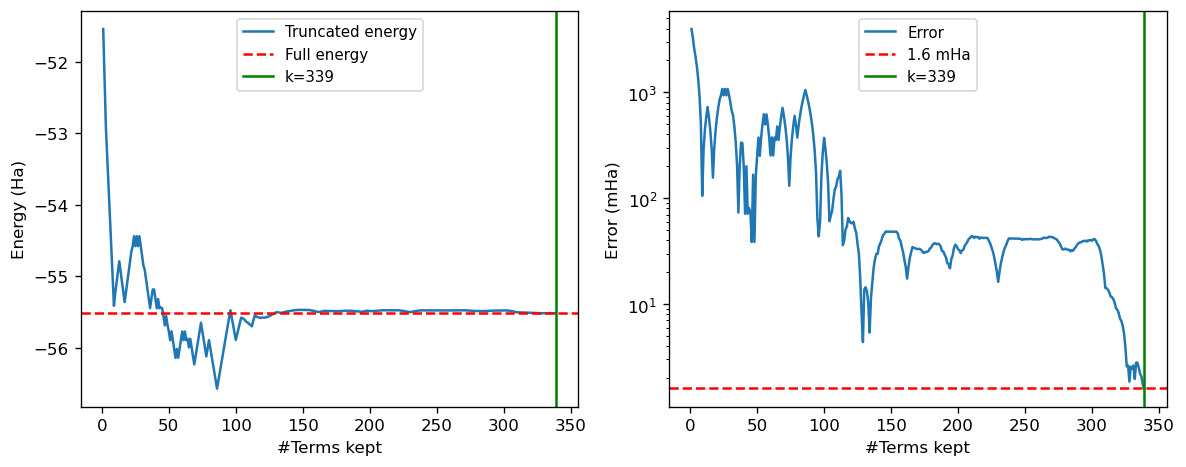

In [3]:
# Custom function to get the number of terms of the hamiltonian to keep
k = find_truncate_terms(qubit_op, problem, error_threshold=1.6e-3, weight_threshold=None, verbose=True, plot=True)

# k = 339 # chemical accuracy

# k = 1001 # chemical accuracy and > 0.9 weight fraction

In [4]:
# Truncate the Hamiltonian to the top k terms
trunc_op = truncate_hamiltonian(qubit_op, k, verbose=True)

Truncation summary:
  Original terms: 1682
  Truncated terms: 339
  Weight kept: 84.626%
  Largest term: 15.723162
  Smallest kept term: 0.015906


## 3. Quantum Circuit Ansätze: Choosing the Right Trial Wavefunction

The ansatz is the template quantum circuit that generates our trial wavefunctions during VQE optimization. It directly determines both the accuracy we can achieve and the computational cost we must pay.

### 3.1 Design Considerations

When choosing an ansatz, we must balance:
- **Expressibility**: Can it represent the true ground state?
- **Trainability**: Can optimization algorithms find good parameters?
- **Circuit depth**: How many quantum gates are needed?
- **Hardware compatibility**: Will it work on real quantum devices?

### 3.2 EfficientSU2: The Practical Choice

**Philosophy**: Hardware-efficient design optimized for near-term quantum devices.

**Structure**:
- Alternating layers of single-qubit rotations (RY gates)
- Entangling CNOT gates in circular topology
- Shallow circuits that minimize decoherence

### 3.3 UCCSD: The Quantum Chemistry Standard

**Philosophy**: Based on established quantum chemistry methods (Coupled Cluster theory).

**Structure**:
- Starts from Hartree-Fock reference state
- Systematically adds single and double electron excitations
- Guarantees accurate results for weakly correlated systems

### 3.4 Hamiltonian Variational Ansatz: Physics-Inspired Design

**Philosophy**: Let the molecular Hamiltonian itself guide the circuit structure.

**Structure**:
- Each Pauli term in the Hamiltonian becomes a parameterized gate
- Circuit directly mirrors the underlying physics
- Number of parameters scales with Hamiltonian complexity

In [5]:
circuit1 = efficient_su2(trunc_op.num_qubits)

num_params1 = circuit1.num_parameters
print(f"Number of parameters in the ansatz: {num_params1}")

Number of parameters in the ansatz: 96


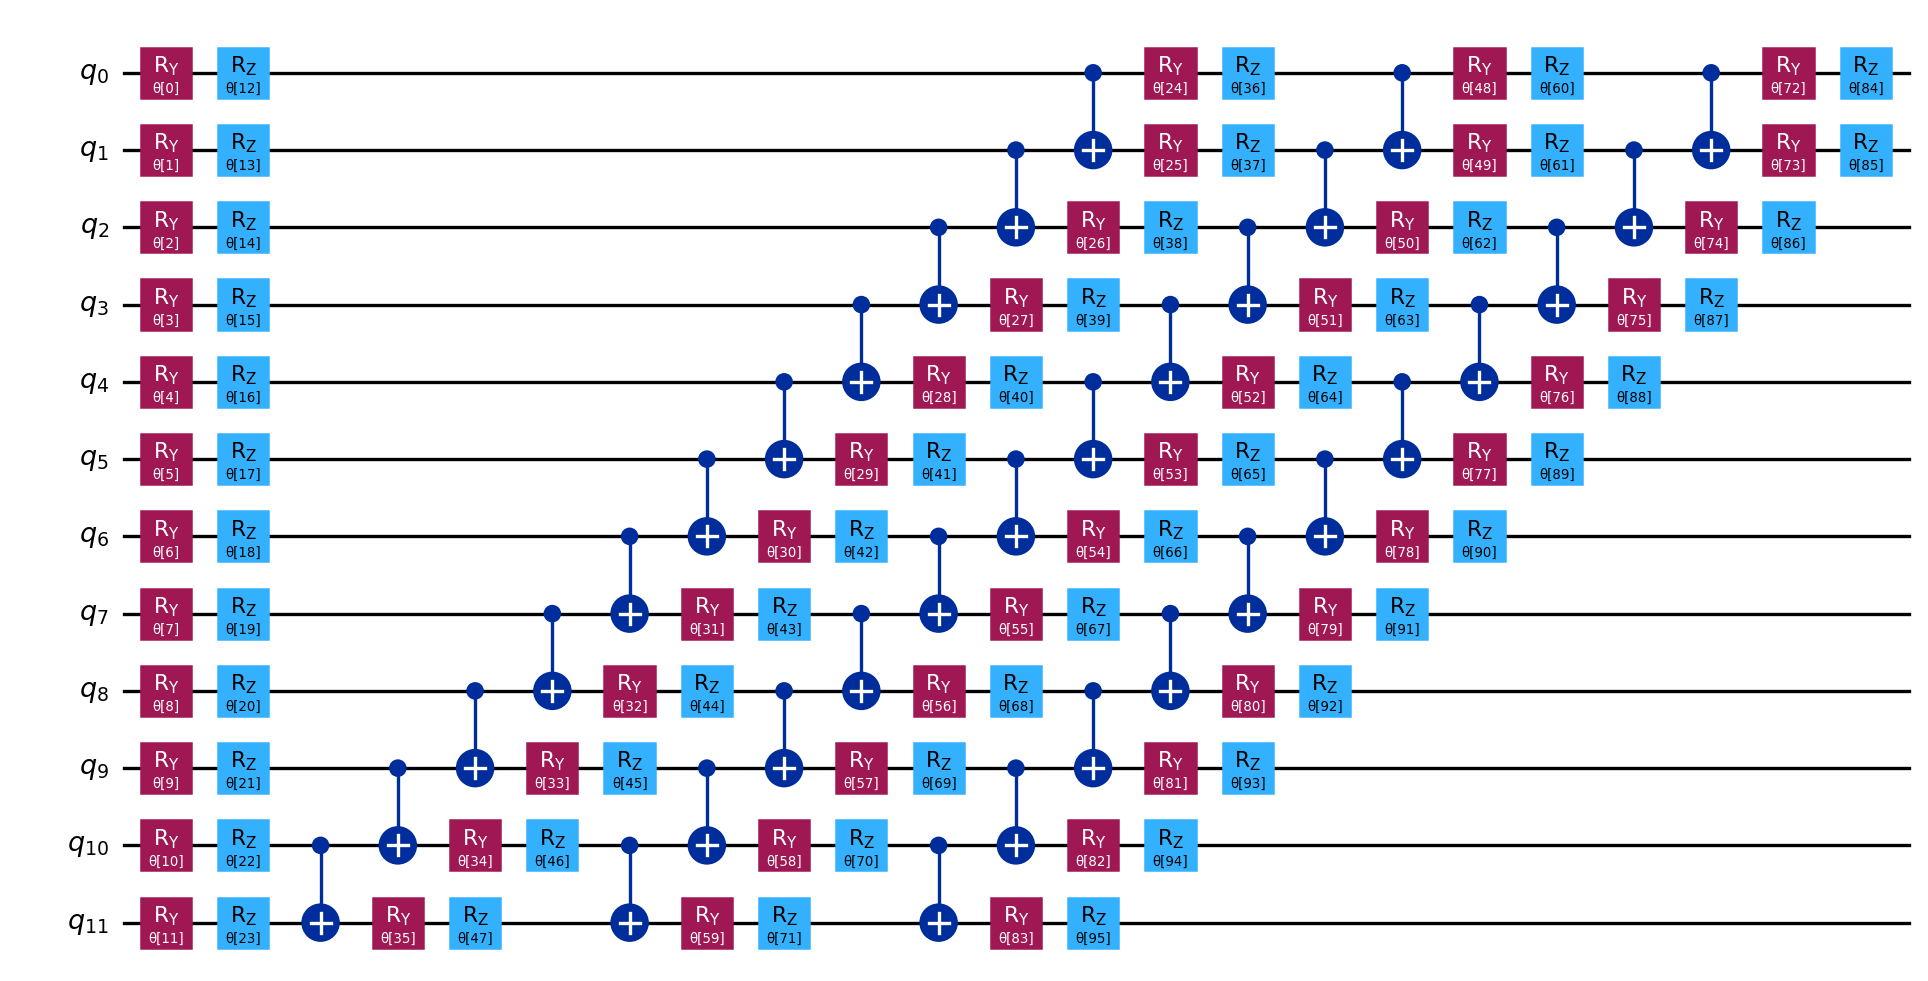

In [6]:
circuit1.draw('mpl')

### Hartree-Fock Reference State

The Hartree-Fock state represents the foundational starting point for quantum chemistry calculations on quantum computers. It provides the best possible single-determinant approximation to the molecular ground state, where electrons are treated as independent particles in a mean-field potential created by all other electrons.

The HF approximation gives us a reasonable first guess that already incorporates the correct particle number, spin, and spatial symmetries of the molecular system, making it an ideal quantum state initialization for subsequent variational refinement.

In UCCSD, the HF reference state serves as the starting wavefunction that is then systematically improved by applying unitary coupled cluster operators that create single and double excitations from the mean-field ground state.

In [7]:
circuit2 = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

num_params2 = circuit2.num_parameters
print(f"Number of parameters in the ansatz: {num_params2}")

Number of parameters in the ansatz: 204


### 3.4 Hamiltonian Variational Ansatz: Physics-Guided Circuit Design

**Idea**  
The Hamiltonian Variational Ansatz (HVA) builds a quantum circuit directly from the problem’s Hamiltonian.
Rather than starting from a generic “hardware-efficient” pattern of gates, HVA converts the actual physics of the system into a sequence of parameterized quantum gates.

**How It Works**  
Suppose the Hamiltonian can be written as  
$$
H = \sum_{k=1}^{K} H_k ,
$$  
where each group $H_k$ is a sum of Pauli operators that **commute with each other**, but different groups do **not** commute: $[H_k, H_{k'}] \neq 0$.  
The HVA circuit is then

$$
U(\boldsymbol\theta)
  = \prod_{r=1}^{R}
      \left(
         \prod_{k=K}^{1} e^{-i \theta_{k,r} H_k}
      \right).
$$

* **Layers**: The index $r=1,\dots,R$ counts how many times we repeat the full set of commuting groups.  
* **Parameters**: Each angle $\theta_{k,r}$ adjusts the influence of the corresponding interaction term $H_k$.  
* **Exact Exponentials**: The gates implement $e^{-i\theta H_k}$ exactly, so every parameter has a clear physical meaning.

**Why It Matters**
- **Direct Mapping from Physics**: Every gate represents a real interaction, such as electron–electron repulsion or kinetic energy.  
- **Adjustable Depth**: The number of repetitions $R$ controls the circuit depth while respecting the Hamiltonian’s structure.  
- **Automatic Grouping**: The library can automatically divide the Hamiltonian into commuting sets.

In [8]:
circuit3 = hamiltonian_variational_ansatz(trunc_op)

num_params3 = circuit3.num_parameters
print(f"Number of parameters in the ansatz: {num_params3}")

Number of parameters in the ansatz: 15


## 4. Classical Optimization: SPSA (Simultaneous Perturbation Stochastic Approximation)

SPSA is a gradient-free optimizer widely used in VQE because it handles noise well and requires minimal circuit evaluations.

### 4.1 Core Concept

Instead of computing separate derivatives for each parameter (which would require 2×N circuit evaluations), SPSA perturbs all parameters simultaneously in random ±1 directions and estimates the gradient from just two energy evaluations:

**Mathematical formulation:**

$$
\hat{g}(\theta)
   = \frac{f(\theta + c \,\Delta) - f(\theta - c \,\Delta)}
           {2c}\,\Delta^{-1}
$$

Where:

- $c$ is a small perturbation step size  
- $\Delta$ is a random vector with entries $\pm 1$  
- $\Delta^{-1}$ represents the element-wise inverse of the perturbation vector

**Key advantage**: Cost remains at exactly 2 evaluations per iteration, regardless of parameter count.

### 4.2 Implementation Details for Qiskit

**Challenge**: Qiskit's original VQE implementation called the callback function for every tiny SPSA perturbation, leading to confusing logging where `params` arrived as single-element arrays instead of full parameter vectors.

**Solution**: I modified the VQE callback mechanism to report once per iteration with the complete parameter vector:

```python
if self.callback is not None:
    eval_count += 1
    self.callback(eval_count, parameters[0], values[0], estimator_result.metadata)
```

This change provides clear convergence monitoring while preserving SPSA's internal gradient estimation process.

In [9]:
iterations = 2500
spsa = SPSA(maxiter=iterations)

In [10]:
counts = []
values = []
parameters = []

# Custom callback function to store intermediate results
def store_intermediate_result(eval_count, parameters_array, mean, std):
    counts.append(eval_count)
    values.append(mean)
    parameters.append(parameters_array.tolist())
    print(f"Eval count: {eval_count},  Energy: {mean:.6f}")
    

### AerEstimator

It is a Qiskit tool that calculates the expected values of operators for a given quantum circuit.  
In practice, it takes your ansatz circuit and Hamiltonian, simulates the circuit and returns the expected energy.

In [11]:
# Create the estimator that will be used for noiseless simulation
noiseless_estimator = AerEstimator()

In [12]:
# Calculate reference energy with exact eigensolver
solver = NumPyMinimumEigensolver()
raw_result_exact = solver.compute_minimum_eigenvalue(operator=trunc_op)
result_exact = problem.interpret(raw_result_exact)
ref_value = result_exact.total_energies[0].real
print(f"Reference value: {ref_value:.5f} Ha")

Reference value: -55.51335 Ha


### VQE using EfficientSU2 with SPSA

In [13]:
# Run the VQE algorithm with SPSA optimizer (load data if already computed)
if check_results_file('results/vqe_result_efficient_su2_SPSA.json', dist=dist, ang=ang, k=k):
    print("Results file already exists. Loading existing results.")
    existing_results = load_vqe_results('results/vqe_result_efficient_su2_SPSA.json')

    result_vqe1 = existing_results['vqe_result']
    counts1 = existing_results['counts']
    raw_values1 = existing_results['raw_values']
    parameters1 = existing_results['parameters']

else:
    print("No existing results file found. Running VQE...")
    counts = []
    values = []
    parameters = []

    vqe1 = VQE(noiseless_estimator, circuit1, optimizer=spsa, callback=store_intermediate_result)
    raw_result_vqe1 = vqe1.compute_minimum_eigenvalue(operator=trunc_op)
    result_vqe1 = problem.interpret(raw_result_vqe1).total_energies[0].real

    counts1 = counts.copy()
    raw_values1 = values.copy()
    parameters1 = parameters.copy()

    result_vqe1_dict = create_dict('efficient_su2', result_vqe1, ref_value, counts1, raw_values1, parameters1, dist, ang, k)

    save_vqe_results(result_vqe1_dict, filename='results/vqe_result_efficient_su2_SPSA.json', new_params=True)

print(f"VQE on Aer qasm simulator (no noise): {result_vqe1:.5f}")
print(f"Delta from reference energy value is {(result_vqe1 - ref_value):.5f}")
print(f"Total evaluations: {len(counts1)}")

Results file already exists. Loading existing results.
Results loaded from results/vqe_result_efficient_su2_SPSA.json
VQE on Aer qasm simulator (no noise): -54.85168
Delta from reference energy value is 0.66167
Total evaluations: 2502


### VQE using UCCSD with SPSA

In [14]:
if check_results_file('results/vqe_result_uccsd_SPSA.json', dist=dist, ang=ang, k=k):
    print("Results file already exists. Loading existing results.")
    existing_results = load_vqe_results('results/vqe_result_uccsd_SPSA.json')

    result_vqe2 = existing_results['vqe_result']
    counts2 = existing_results['counts']
    raw_values2 = existing_results['raw_values']
    parameters2 = existing_results['parameters']
    
else:
    print("No existing results file found. Running VQE...")
    counts = []
    values = []
    parameters = []

    vqe2 = VQE(noiseless_estimator, circuit2.decompose(reps=2), optimizer=spsa, callback=store_intermediate_result)
    raw_result_vqe2 = vqe2.compute_minimum_eigenvalue(operator=trunc_op)
    result_vqe2 = problem.interpret(raw_result_vqe2).total_energies[0].real

    counts2 = counts.copy()
    raw_values2 = values.copy()
    parameters2 = parameters.copy()
    
    result_vqe2_dict = create_dict('uccsd', result_vqe2, ref_value, counts2, raw_values2, parameters2, dist, ang, k)

    save_vqe_results(result_vqe2_dict, filename='results/vqe_result_uccsd_SPSA.json', new_params=True)

print(f"Total ground state energy = {result_vqe2:.4f}")
print(f"Delta from reference energy value is {(result_vqe2 - ref_value):.5f}")
print(f"Total evaluations: {len(counts2)}")

Results file already exists. Loading existing results.
Results loaded from results/vqe_result_uccsd_SPSA.json
Total ground state energy = -55.4308
Delta from reference energy value is 0.08251
Total evaluations: 2502


### VQE using Hamiltonian Variatonal Ansatz with SPSA

In [15]:
if check_results_file('results/vqe_result_hva_SPSA.json', dist=dist, ang=ang, k=k):
    print("Results file already exists. Loading existing results.")
    existing_results = load_vqe_results('results/vqe_result_hva_SPSA.json')

    result_vqe3 = existing_results['vqe_result']
    counts3 = existing_results['counts']
    raw_values3 = existing_results['raw_values']
    parameters3 = existing_results['parameters']
else:
    print("No existing results file found. Running VQE...")
    counts = []
    values = []
    parameters = []

    vqe3 = VQE(noiseless_estimator, circuit3, optimizer=spsa, callback=store_intermediate_result)
    raw_result_vqe3 = vqe3.compute_minimum_eigenvalue(operator=trunc_op)
    result_vqe3 = problem.interpret(raw_result_vqe3).total_energies[0].real

    counts3 = counts.copy()
    raw_values3 = values.copy()
    parameters3 = parameters.copy()
    
    result_vqe3_dict = create_dict('hva', result_vqe3, ref_value, counts3, raw_values3, parameters3, dist, ang, k)

    save_vqe_results(result_vqe3_dict, filename='results/vqe_result_hva_SPSA.json', new_params=True)

print(f"VQE on Aer qasm simulator (no noise): {result_vqe3:.5f}")
print(f"Delta from reference energy value is {(result_vqe3 - ref_value):.5f}")
print(f"Total evaluations: {len(counts3)}")

Results file already exists. Loading existing results.
Results loaded from results/vqe_result_hva_SPSA.json
VQE on Aer qasm simulator (no noise): -50.68105
Delta from reference energy value is 4.83230
Total evaluations: 2502


In [16]:
# Since we saved intermediate value directly in the callback
# we need to interpret them in order to get meaningful energy values
values1 = interpret_values(raw_values1, problem)
values2 = interpret_values(raw_values2, problem)
values3 = interpret_values(raw_values3, problem)

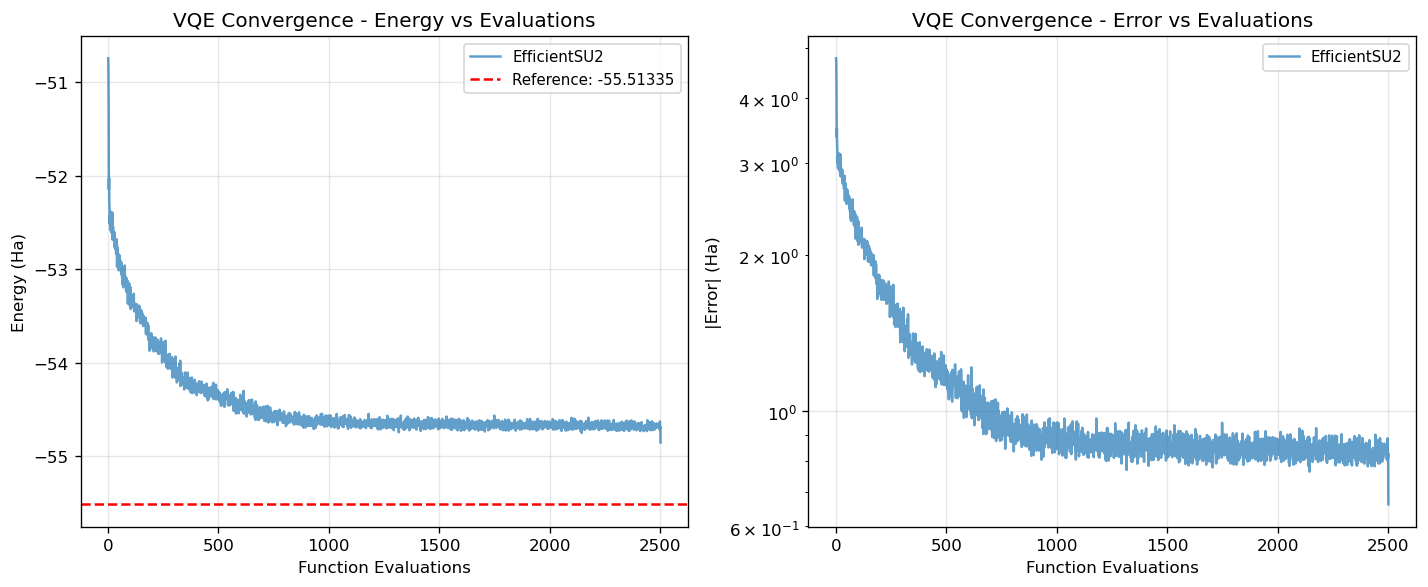

In [17]:
# Now we plot the convergence of the three ansatzes
plot_convergence(counts1, values1, ref_value, label='EfficientSU2')


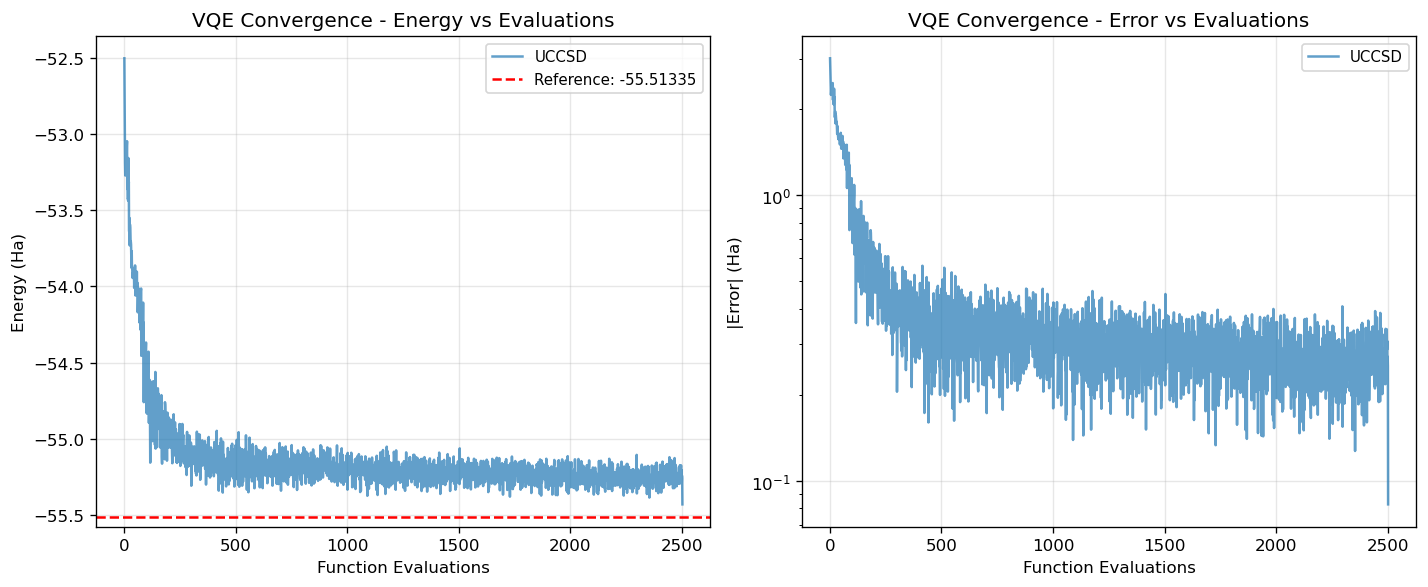

In [18]:
plot_convergence(counts2, values2, ref_value, label='UCCSD')

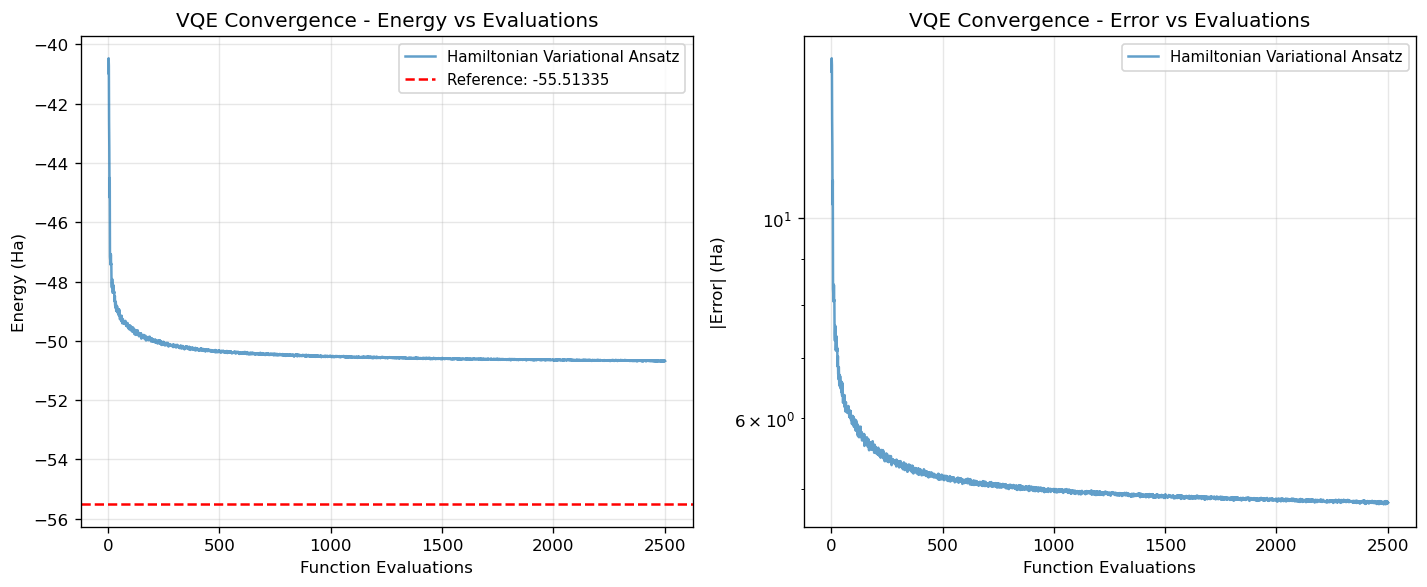

In [19]:
plot_convergence(counts3, values3, ref_value, label='Hamiltonian Variational Ansatz')

### Parameters Convergence

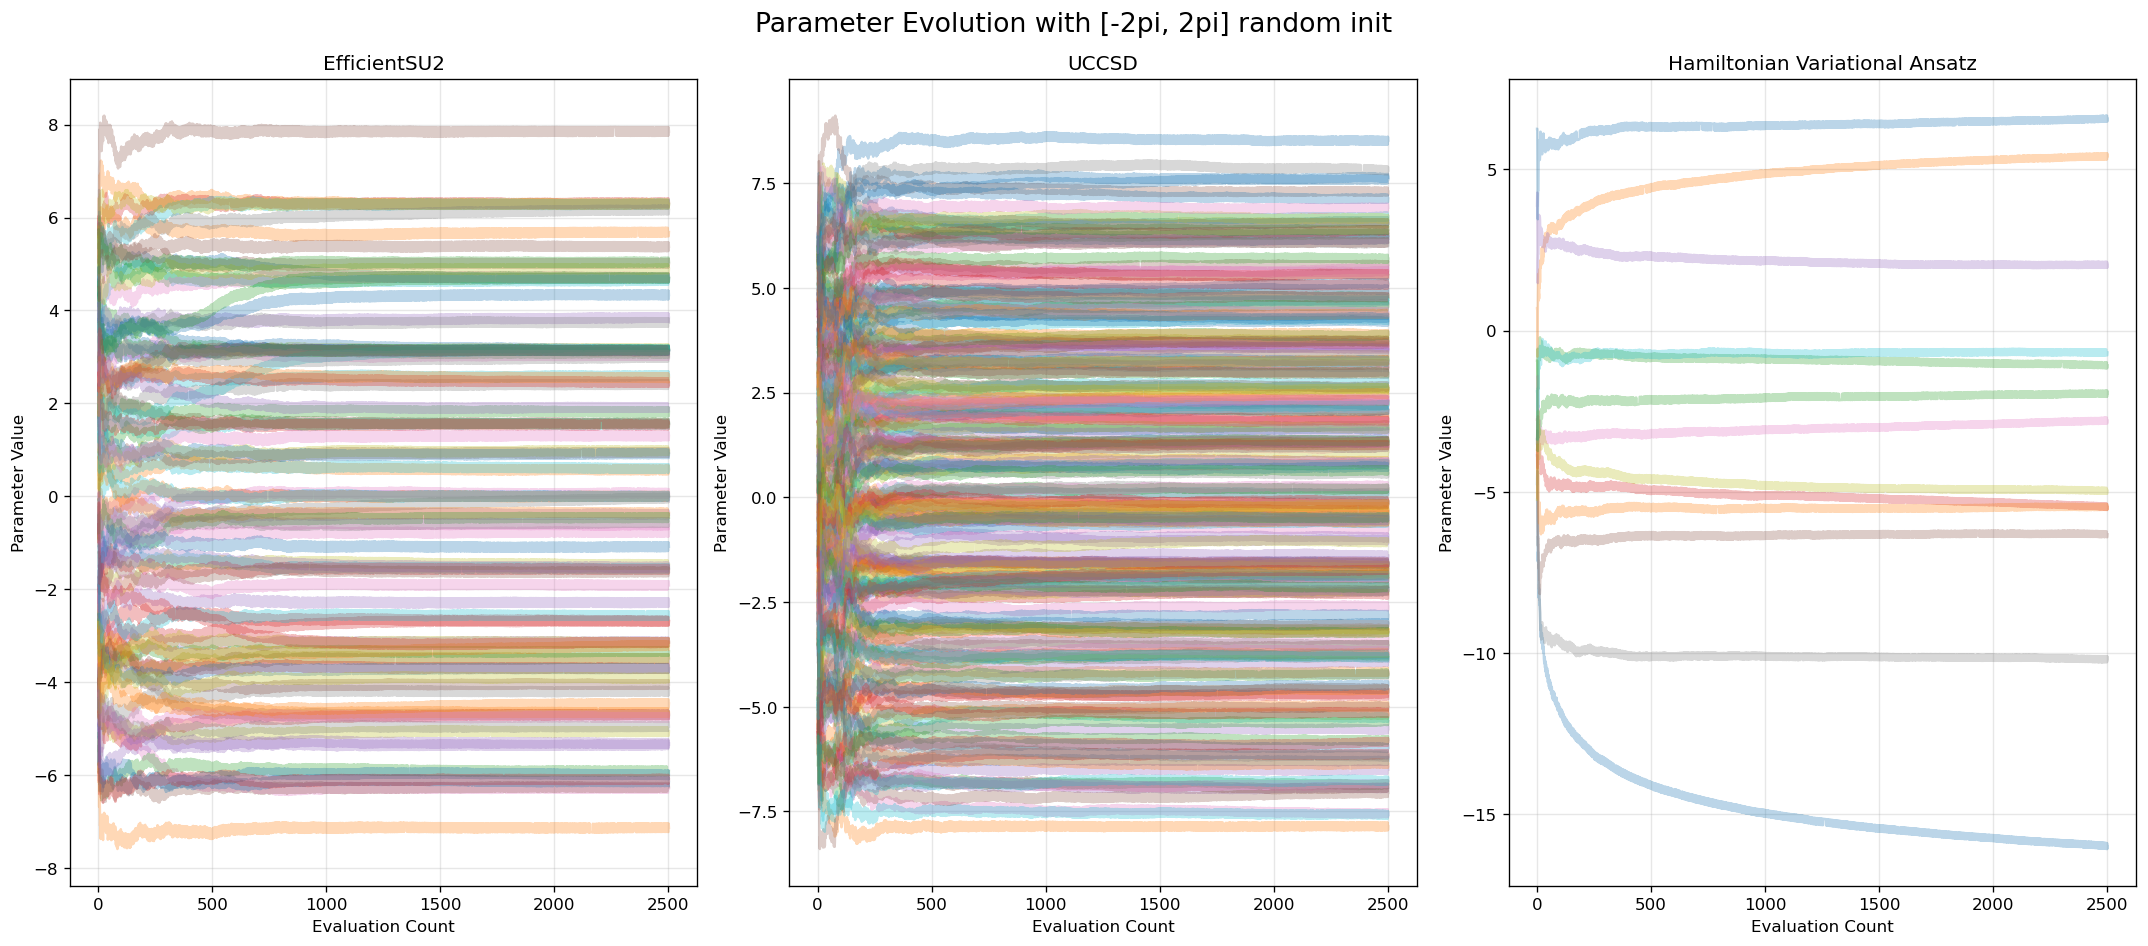

In [20]:
plt.figure(figsize=(18, 8))

# Plot 1: Parameter evolution for EfficientSU2
plt.subplot(1, 3, 1)
params_array1 = np.array(parameters1)
for i in range(min(96, params_array1.shape[1])):  # Plot first 96 parameters
    plt.plot(counts1, params_array1[:, i], alpha=0.3, label=f'θ_{i}' if i < 5 else '')
plt.xlabel('Evaluation Count')
plt.ylabel('Parameter Value')
plt.title('EfficientSU2')
plt.grid(True, alpha=0.3)
if len(parameters1) > 0 and len(parameters1[0]) <= 5:
    plt.legend()
    
# Plot 2: Parameter evolution for UCCSD
plt.subplot(1, 3, 2)
params_array2 = np.array(parameters2)
for i in range(min(204, params_array2.shape[1])):  # Plot first 204 parameters
    plt.plot(counts2, params_array2[:, i], alpha=0.3, label=f'θ_{i}' if i < 5 else '')
plt.xlabel('Evaluation Count')
plt.ylabel('Parameter Value')
plt.title('UCCSD')
plt.grid(True, alpha=0.3)
if len(parameters2) > 0 and len(parameters2[0]) <= 5:
    plt.legend()

# Plot 3: Parameter evolution for Hamiltonian Variational Ansatz
plt.subplot(1, 3, 3)
params_array3 = np.array(parameters3)
for i in range(min(100, params_array3.shape[1])):  # Plot first 100 parameters
    plt.plot(counts3, params_array3[:, i], alpha=0.3, label=f'θ_{i}' if i < 5 else '')
plt.xlabel('Evaluation Count')
plt.ylabel('Parameter Value')
plt.title('Hamiltonian Variational Ansatz')
plt.grid(True, alpha=0.3)
if len(parameters3) > 0 and len(parameters3[0]) <= 5:
    plt.legend()
    
plt.suptitle('Parameter Evolution with [-2pi, 2pi] random init', fontsize=16)
plt.tight_layout()
plt.show()


## 5. Classical Optimization: L-BFGS-B (Limited-Memory BFGS with Bounds)

L-BFGS-B is a gradient-based optimizer that often outperforms SPSA when accurate gradients are available, making it ideal for noiseless simulations or high-fidelity quantum devices.

### 5.1 Algorithm Overview

L-BFGS-B is a quasi-Newton method that builds an approximate Hessian matrix from successive gradient evaluations while using limited memory to remain computationally tractable.

**Core procedure:**
1. **Evaluate** both energy and gradient ∇f(θ) at current parameters
2. **Update** internal low-rank Hessian approximation using gradient history
3. **Propose** new parameters using curvature information while respecting parameter bounds
4. **Repeat** until convergence

The "-B" extension allows explicit upper and lower bounds on each parameter, which is valuable for keeping rotation angles within meaningful ranges (e.g., [-π, π]).

In [21]:
iterations = 1000
lbfgs = L_BFGS_B(maxiter=iterations, iprint=1)

### VQE using EfficientSU2 with L-BFGS-B

In [22]:
if check_results_file('results/vqe_result_efficient_su2_LBFGS.json', dist=dist, ang=ang, k=k):
    print("Results file already exists. Loading existing results.")
    existing_results = load_vqe_results('results/vqe_result_efficient_su2_LBFGS.json')

    result_vqe1L = existing_results['vqe_result']
    counts1L = existing_results['counts']
    raw_values1L = existing_results['raw_values']
    parameters1L = existing_results['parameters']

else:
    print("No existing results file found. Running VQE...")
    counts = []
    values = []
    parameters = []

    vqe1L = VQE(noiseless_estimator, circuit1, optimizer=lbfgs, callback=store_intermediate_result)
    raw_result_vqe1L = vqe1L.compute_minimum_eigenvalue(operator=trunc_op)
    result_vqe1L = problem.interpret(raw_result_vqe1L).total_energies[0].real

    counts1L = counts.copy()
    raw_values1L = values.copy()
    parameters1L = parameters.copy()

    result_vqe1L_dict = create_dict('efficient_su2', result_vqe1L, ref_value, counts1L, raw_values1L, parameters1L, dist, ang, k)

    save_vqe_results(result_vqe1L_dict, filename='results/vqe_result_efficient_su2_LBFGS.json', new_params=True)

print(f"VQE on Aer qasm simulator (no noise): {result_vqe1L:.5f}")
print(f"Delta from reference energy value is {(result_vqe1L - ref_value):.5f}")
print(f"Total evaluations: {len(counts1L)}")

Results file already exists. Loading existing results.
Results loaded from results/vqe_result_efficient_su2_LBFGS.json
VQE on Aer qasm simulator (no noise): -55.45675
Delta from reference energy value is 0.05660
Total evaluations: 15132


### VQE using UCCSD with L-BFGS-B

In [23]:
if check_results_file('results/vqe_result_uccsd_LBFGS.json', dist=dist, ang=ang, k=k):
    print("Results file already exists. Loading existing results.")
    existing_results = load_vqe_results('results/vqe_result_uccsd_LBFGS.json')

    result_vqe2L = existing_results['vqe_result']
    counts2L = existing_results['counts']
    raw_values2L = existing_results['raw_values']
    parameters2L = existing_results['parameters']

else:
    print("No existing results file found. Running VQE...")
    counts = []
    values = []
    parameters = []

    vqe2L = VQE(noiseless_estimator, circuit2.decompose(reps=2), optimizer=lbfgs, callback=store_intermediate_result)
    raw_result_vqe2L = vqe2L.compute_minimum_eigenvalue(operator=trunc_op)
    result_vqe2L = problem.interpret(raw_result_vqe2L).total_energies[0].real

    counts2L = counts.copy()
    raw_values2L = values.copy()
    parameters2L = parameters.copy()

    result_vqe2L_dict = create_dict('uccsd', result_vqe2L, ref_value, counts2L, raw_values2L, parameters2L, dist, ang, k)

    save_vqe_results(result_vqe2L_dict, filename='results/vqe_result_uccsd_LBFGS.json', new_params=True)

print(f"VQE on Aer qasm simulator (no noise): {result_vqe2L:.5f}")
print(f"Delta from reference energy value is {(result_vqe2L - ref_value):.5f}")
print(f"Total evaluations: {len(counts2L)}")

Results file already exists. Loading existing results.
Results loaded from results/vqe_result_uccsd_LBFGS.json
VQE on Aer qasm simulator (no noise): -55.44102
Delta from reference energy value is 0.07233
Total evaluations: 15170


### VQE using Hamiltonian Variational Ansatz with L-BFGS-B

In [24]:
if check_results_file('results/vqe_result_hva_LBFGS.json', dist=dist, ang=ang, k=k):
    print("Results file already exists. Loading existing results.")
    existing_results = load_vqe_results('results/vqe_result_hva_LBFGS.json')

    result_vqe3L = existing_results['vqe_result']
    counts3L = existing_results['counts']
    raw_values3L = existing_results['raw_values']
    parameters3L = existing_results['parameters']
else:
    print("No existing results file found. Running VQE...")
    counts = []
    values = []
    parameters = []

    vqe3L = VQE(noiseless_estimator, circuit3, optimizer=lbfgs, callback=store_intermediate_result)
    raw_result_vqe3L = vqe3L.compute_minimum_eigenvalue(operator=trunc_op)
    result_vqe3L = problem.interpret(raw_result_vqe3L).total_energies[0].real

    counts3L = counts.copy()
    raw_values3L = values.copy()
    parameters3L = parameters.copy()

    result_vqe3L_dict = create_dict('hva', result_vqe3L, ref_value, counts3L, raw_values3L, parameters3L, dist, ang, k)

    save_vqe_results(result_vqe3L_dict, filename='results/vqe_result_hva_LBFGS.json', new_params=True)

print(f"VQE on Aer qasm simulator (no noise): {result_vqe3L:.5f}")
print(f"Delta from reference energy value is {(result_vqe3L - ref_value):.5f}")
print(f"Total evaluations: {len(counts3L)}")

Results file already exists. Loading existing results.
Results loaded from results/vqe_result_hva_LBFGS.json
VQE on Aer qasm simulator (no noise): -52.41410
Delta from reference energy value is 3.09925
Total evaluations: 1764


In [25]:
# Same as before, we need to interpret the raw values
values1L = interpret_values(raw_values1L, problem)
values2L = interpret_values(raw_values2L, problem)
values3L = interpret_values(raw_values3L, problem)

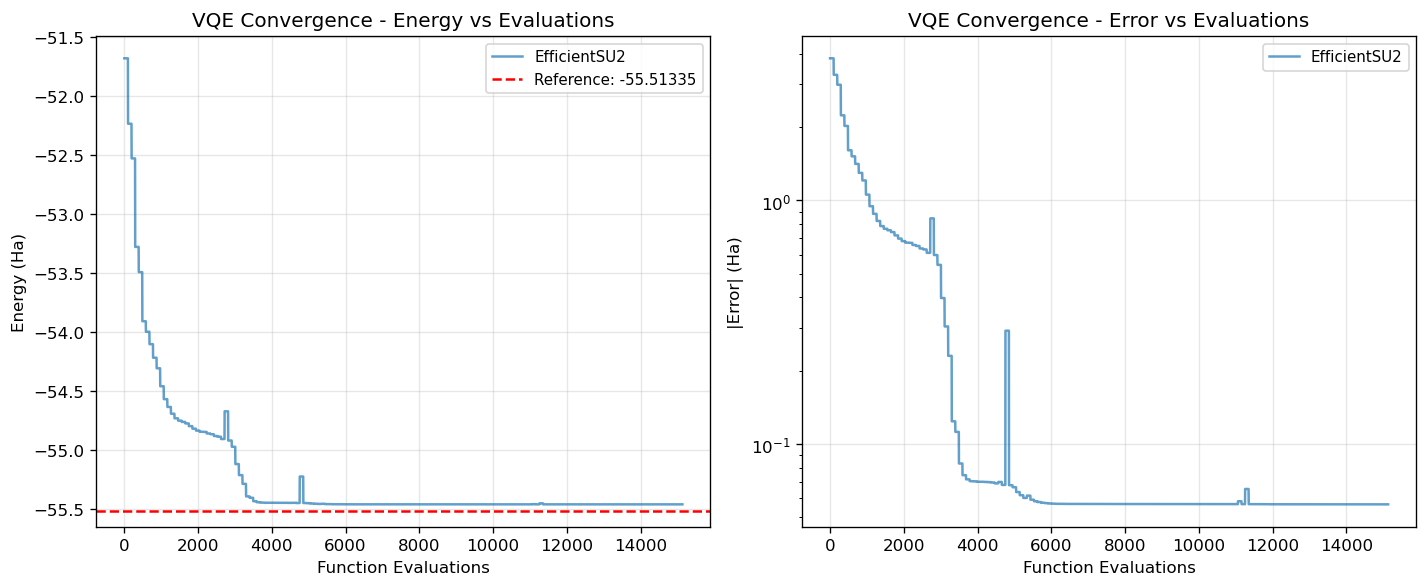

In [26]:
plot_convergence(counts1L, values1L, ref_value, label='EfficientSU2')

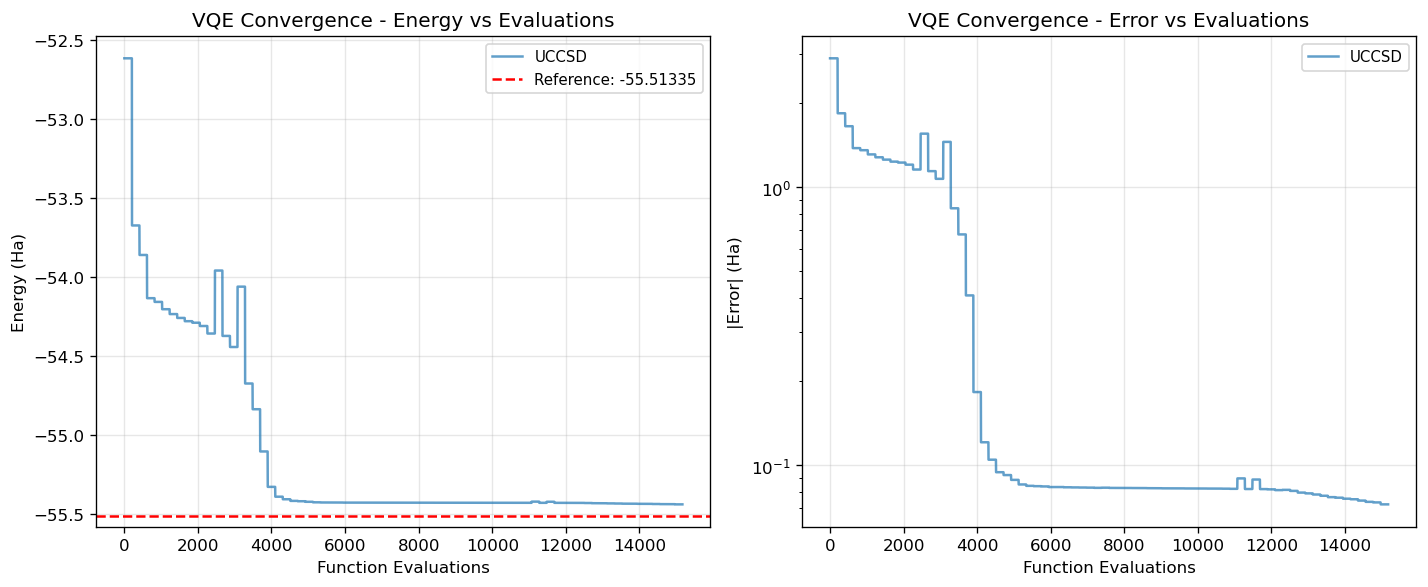

In [27]:
plot_convergence(counts2L, values2L, ref_value, label='UCCSD')

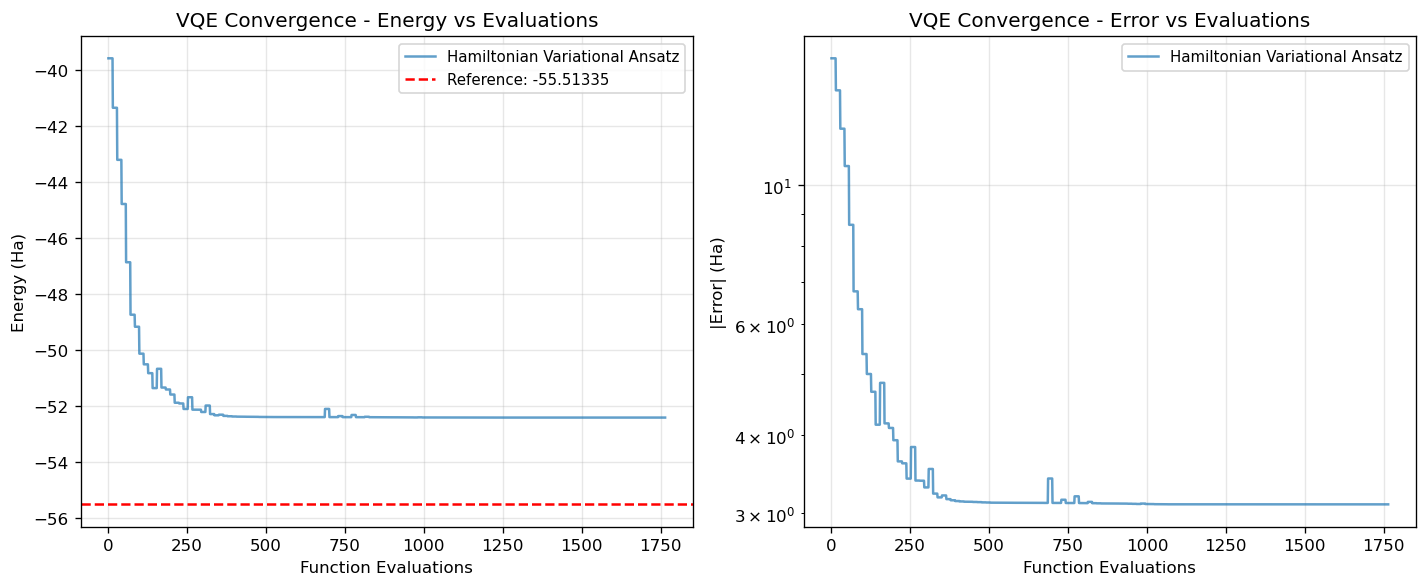

In [28]:
plot_convergence(counts3L, values3L, ref_value, label='Hamiltonian Variational Ansatz')

---
# Pennylane and Qiskit comparison
---

This section compares **PennyLane** and **Qiskit** implementations of the VQE.  
By running the same molecule with an identical custom ansatz on both frameworks, we can directly measure differences in execution time, optimizer behavior, and ground-state energy accuracy.  
The goal is to validate results across platforms and highlight any performance or precision gaps.


In [29]:
# Unlike Qiskit, I did not create a custom wrapper to create the molecule,
# but I'll show here the code to do that

# First we define the symbols and coordinates of the atoms
# These are taken from the Computational Chemistry Comparison and Benchmark DataBase (CCCBDB) (https://cccbdb.nist.gov/geom3x.asp?method=1&basis=20)

symbols = ["N", "H", "H", "H"]
coordinates = np.array([ # in Angstrom
    [0.0000, 0.0000, 0.1278],    # N1
    [-0.5845, 0.7368, -0.2982],  # H2  
    [0.9304, 0.1378, -0.2982],   # H3
    [-0.3459, -0.8747, -0.2982]  # H4
])

# Create the molecule object
pl_molecule = pl_Molecule(symbols, coordinates, unit="angstrom")
pl_n_electrons = pl_molecule.n_electrons
pl_n_orbitals = pl_molecule.n_orbitals

# Generate the molecular Hamiltonian
# Here we use parity mapping as before
pl_H, pl_qubits = pl_molecular_hamiltonian(pl_molecule, method='pyscf', mapping='parity')

print(f"\nNumber of qubits: {pl_qubits}")
print(f"Electrons: {pl_molecule.n_electrons}")
print(f"Orbitals: {pl_molecule.n_orbitals}")
print(f"molecule: {pl_molecule}")


Number of qubits: 16
Electrons: 10
Orbitals: 8
molecule: <Molecule = H3N, Charge: 0, Basis: STO-3G, Orbitals: 8, Electrons: 10>


In [30]:
# Now we define the simulated device on which we will run the VQE
pl_device = qml.device("lightning.qubit", wires=pl_qubits)

### Custom Ansatz for Qiskit-PennyLane Comparison

We use a custom ansatz to ensure that the VQE circuits in Qiskit and PennyLane are exactly the same, so any differences in results come only from the simulator or backend, not from the circuit structure.  

The chosen ansatz is a simple Hardware Efficient Ansatz (HEA) with RY rotations and CNOT entanglers:  
- An initial layer of Hadamard gates puts all qubits into superposition.  
- Each layer applies a parameterized RY rotation on every qubit.  
- Circular CNOT entanglers create correlations between neighboring qubits.  

This design is easy to reproduce in both frameworks, shallow enough for fast simulation, and flexible enough to approximate the NH3 ground state.


In [31]:
# Custom ansatz implementation
def pl_ansatz(params, wires):

    n_layers = len(params) // len(wires)
    
    # Initial layer of Hadamard gates
    for wire in wires:
        qml.Hadamard(wires=wire)

    # Parameterized layers
    for layer in range(n_layers):
        # Single-qubit rotations
        for i, wire in enumerate(wires):
            qml.RY(params[layer * len(wires) + i], wires=wire)

        # Entangling gates (circular topology)
        for i in range(len(wires)):
            qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])

In [32]:
# VQE cost function for the optimizer
@qml.qnode(pl_device)
def pl_cost_function(pl_params, pl_hamiltonian):

    pl_ansatz(pl_params, range(pl_qubits))
    return qml.expval(pl_hamiltonian)

n_layers = 4
pl_n_params_custom = n_layers * pl_qubits

pl_key = pl_random.PRNGKey(42)
pl_params_custom = pl_random.normal(pl_key, (pl_n_params_custom,)) * 0.1

print(f"Number of qubits: {pl_qubits}")
print(f"Number of electrons: {pl_n_electrons}")
print(f"Parameters for custom ansatz: {pl_n_params_custom}")

Number of qubits: 16
Number of electrons: 10
Parameters for custom ansatz: 64


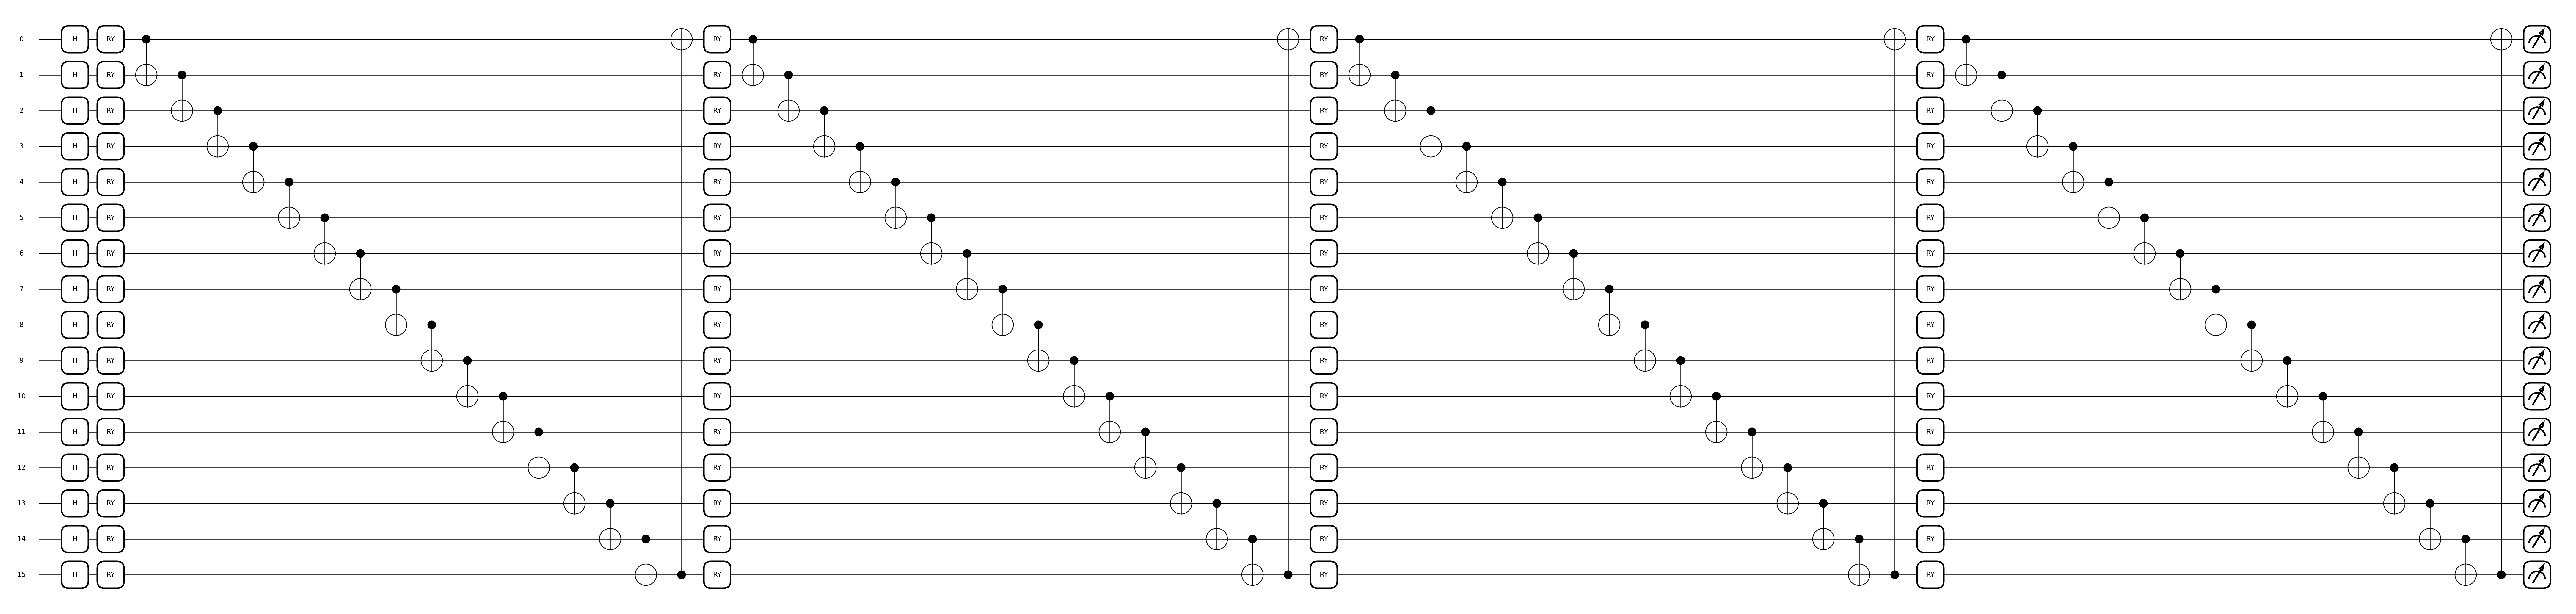

In [33]:
draw_pl_ansatz(pl_ansatz, n_qubits=pl_qubits, n_layers=n_layers, dev=pl_device, method="mpl")

In [34]:
# I defined a custom function which performs the optimization
# using scipy optimizers and a custom callback to monitor the progress
def pl_optimize_vqe(pl_params, pl_hamiltonian, pl_ansatz_type="custom", method="BFGS", maxiter=100, 
                use_callback=True):

    # Check if results already exist
    existing_files = glob.glob(f"results/vqe_progress_{pl_ansatz_type}_*.json")
    if existing_files:
        print(f"VQE optimization already completed for {pl_ansatz_type} ansatz.")
        print(f"Found existing result file: {existing_files[-1]}")
        print("Skipping computation...")
        
        # Load and return existing results
        try:
            with open(existing_files[-1], 'r') as f:
                data = json.load(f)
            
            # Create a mock result object
            class pl_MockResult:
                def __init__(self, data):
                    self.fun = data['energies'][-1] if data['energies'] else None
                    self.x = np.array(data['parameters'][-1]) if data['parameters'] else pl_params
                    self.nit = data['total_iterations']
                    self.success = True
                    self.callback_data = {
                        'energies': data['energies'],
                        'parameters': data['parameters'],
                        'times': data['times'],
                        'iterations': data['total_iterations']
                    }
            
            return pl_MockResult(data)
        except Exception as e:
            print(f"Could not load existing file.")
            print("Proceeding with new optimization...")
    
    print(f"Starting VQE optimization with {pl_ansatz_type} ansatz...")
    print(f"Optimization method: {method}")
    print(f"Maximum iterations: {maxiter}")
    print(f"Callback monitoring: {'Enabled' if use_callback else 'Disabled'}")
    
    # Initialize callback if requested
    pl_callback = None
    if use_callback:
        pl_callback = pl_VQECallback(pl_ansatz_type, save_to_file=True)
    
    # Convert JAX cost function for scipy
    def pl_objective(pl_params_flat):
        energy = float(pl_cost_function(pl_params_flat, pl_hamiltonian))
        return energy
    
    def pl_gradient(pl_params_flat):
        grad_fn = pl_jit(pl_value_and_grad(lambda p: pl_cost_function(p, pl_hamiltonian)))
        _, grad = grad_fn(pl_params_flat)
        return np.array(grad)
    
    # Store objective function in callback for energy calculation
    if pl_callback:
        pl_callback.objective_func = pl_objective
    
    pl_start_time = time.time()
    
    # Run optimization
    pl_result = pl_minimize(
        pl_objective,
        pl_params,
        method=method,
        jac=pl_gradient,
        callback=pl_callback,
        options={'maxiter': maxiter, 'disp': True}
)
    
    pl_end_time = time.time()
    
    print(f"\nOptimization completed in {pl_end_time - pl_start_time:.2f} seconds")
    print(f"Final energy: {pl_result.fun:.8f} Hartree")
    print(f"Number of iterations: {pl_result.nit}")
    print(f"Optimization success: {pl_result.success}")
    
    # Save final results if callback was used
    if pl_callback:
        pl_callback.save_progress()
        pl_result.callback_data = {
            'energies': pl_callback.energies,
            'parameters': pl_callback.parameters,
            'times': pl_callback.times,
            'iterations': pl_callback.iteration
        }
        print(f"Total callback iterations: {pl_callback.iteration}")
    
    return pl_result

In [35]:
# Calculate starting energy of the circuit initialized with small normal values
pl_initial_energy = pl_cost_function(pl_params_custom, pl_H)

print(f"Initial energy (custom ansatz): {pl_initial_energy:.8f} Ha")

Initial energy (custom ansatz): -33.89778663 Ha


In [36]:
# Calculate exact ground state energy with exact eigensolver
# Convert Hamiltonian to sparse matrix representation
pl_H_sparse = pl_H.sparse_matrix()

print(f"Sparse matrix dimension: {pl_H_sparse.shape}")
print(f"Number of non-zero elements: {pl_H_sparse.nnz}")
print(f"Sparsity: {pl_H_sparse.nnz / (pl_H_sparse.shape[0]**2) * 100:.4f}%")

# Use sparse eigenvalue solver to find the lowest eigenvalue
pl_eigenvalue, pl_eigenvector = eigsh(pl_H_sparse, k=1, which='SA', tol=1e-8)
pl_exact_energy = float(pl_eigenvalue[0])

print(f"\nExact ground state energy: {pl_exact_energy:.8f} Ha")

Sparse matrix dimension: (65536, 65536)
Number of non-zero elements: 18153472
Sparsity: 0.4227%

Exact ground state energy: -55.52454749 Ha


In [37]:
# Run VQE optimization with custom ansatz
print("Running VQE with custom ansatz...")
pl_result_custom = pl_optimize_vqe(pl_params_custom, pl_H, "custom", method="L-BFGS-B", maxiter=500)

Running VQE with custom ansatz...
VQE optimization already completed for custom ansatz.
Found existing result file: results/vqe_progress_custom_1757422836.json
Skipping computation...


In [38]:
print(f"\nCustom ansatz VQE energy:      {pl_result_custom.fun:.8f} Ha")

pl_error_custom = abs(pl_result_custom.fun - pl_exact_energy)

print(f"\nCustom ansatz error:           {pl_error_custom:.8f} Ha ({pl_error_custom*1000:.3f} mHa)")



Custom ansatz VQE energy:      -54.26633131 Ha

Custom ansatz error:           1.25821618 Ha (1258.216 mHa)


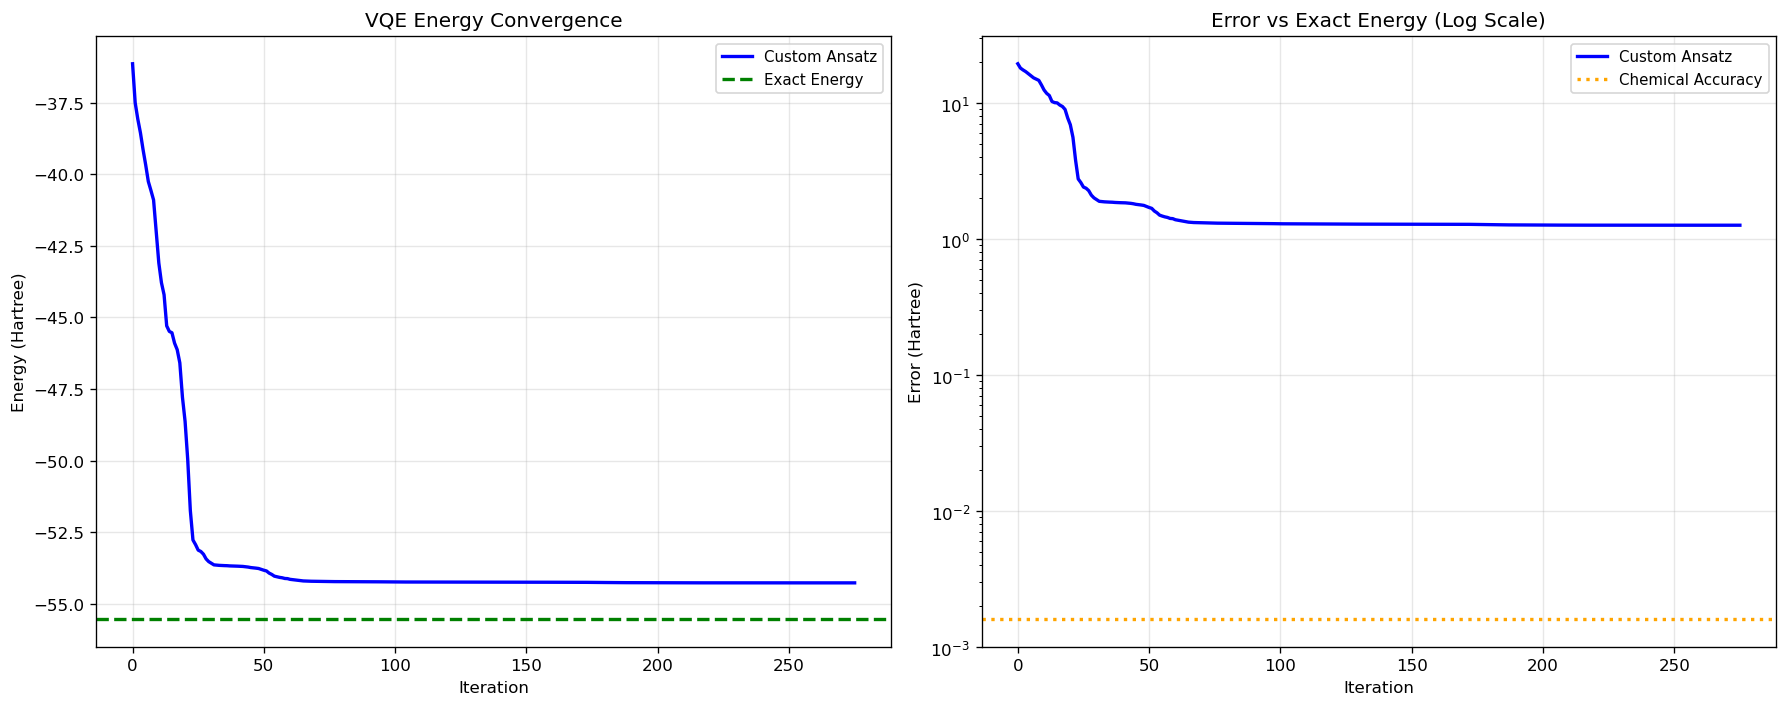

In [39]:
pl_plot_optimization_progress(pl_result_custom, pl_exact_energy)


## Qiskit framework

In [40]:
# First we create the string which identifies the molecule from the same coordinates used before
molecule_string = ""
for i in range(len(symbols)):
    symbol = symbols[i]
    x, y, z = coordinates[i]
    molecule_string += f"{symbol} {x:.6f} {y:.6f} {z:.6f}"
    if i < len(symbols) - 1:
        molecule_string += "; "
        
# Create driver
driver = PySCFDriver(
    atom=molecule_string,
    unit=DistanceUnit.ANGSTROM,
    basis="sto3g"
)

problem = driver.run()
print(f"Electrons: {problem.num_particles[0] + problem.num_particles[1]}")
print(f"Orbitals: {problem.num_spatial_orbitals}")

parity_mapper = ParityMapper()

q_H = parity_mapper.map(problem.second_q_ops()[0])


Electrons: 10
Orbitals: 8


In [41]:
# In order to compare Hamiltonians I implemented a custom function to convert Pennylane Hamiltonian
# to Qiskit Hamiltonian

print("\nFirst few terms of PennyLane Hamiltonian:")
pl_coeffs, pl_ops = pl_H.terms()
for i, (pl_coeff, pl_pauli_term) in enumerate(zip(pl_coeffs[:5], pl_ops[:5])):
    print(f"  {pl_coeff:.8f} * {pl_pauli_term}")
print("  ...")

# >>> Convert PennyLane Hamiltonian to Qiskit <<<
pl_to_q_H = to_qiskit_hamiltonian(pl_H, noq=pl_qubits)

print(f"\nConverted Qiskit Hamiltonian with {pl_to_q_H.num_qubits} qubits")
q_hamiltonian_list = pl_to_q_H.to_list()
for i, (q_pauli_str, q_coeff) in enumerate(q_hamiltonian_list[:5]):
    print(f"  {q_coeff:.8f} * {q_pauli_str}")
print("  ...")

q_H_list = q_H.to_list()
q_qubits = q_H.num_qubits
print(f"\nOriginal Qiskit Hamiltonian with {q_qubits} qubits")
for i, (q_pauli_str, q_coeff) in enumerate(q_H_list[:5]):
    print(f"  {q_coeff:.8f} * {q_pauli_str}")
print("  ...")



First few terms of PennyLane Hamiltonian:
  -34.13111312 * I()
  9.12344303 * Z(0)
  -0.09101676 * X(0) @ X(1) @ Z(2)
  -0.09101676 * Y(0) @ Y(1)
  -0.00000310 * X(0) @ X(1) @ X(2) @ X(3) @ Z(4)
  ...

Converted Qiskit Hamiltonian with 16 qubits
  -34.13111312+0.00000000j * IIIIIIIIIIIIIIII
  9.12344303+0.00000000j * IIIIIIIIIIIIIIIZ
  -0.09101676+0.00000000j * IIIIIIIIIIIIIZXX
  -0.09101676+0.00000000j * IIIIIIIIIIIIIIYY
  -0.00000310+0.00000000j * IIIIIIIIIIIZXXXX
  ...

Original Qiskit Hamiltonian with 16 qubits
  -45.86827811+0.00000000j * IIIIIIIIIIIIIIII
  9.12344303+0.00000000j * IIIIIIIIIIIIIIIZ
  -0.09101676+0.00000000j * IIIIIIIIIIIIIIZX
  0.09101676+0.00000000j * IIIIIIIIIIIIIIIX
  -0.00000318+0.00000000j * IIIIIIIIIIIIIZXX
  ...


In [42]:
# Same ansatz structure as before
def create_q_ansatz(num_qubits, num_layers=4):

    circuit = QuantumCircuit(num_qubits)
    
    # Add parameter list
    params = []
    param_idx = 0
    
    # Initial layer of Hadamard gates (EXACTLY matching PennyLane)
    for qubit in range(num_qubits):
        circuit.h(qubit)
    
    # Parameterized layers (EXACTLY matching PennyLane structure)
    for layer in range(num_layers):
        # Single-qubit RY rotations
        for qubit in range(num_qubits):
            param = Parameter(f'θ_{param_idx}')
            params.append(param)
            circuit.ry(param, qubit)
            param_idx += 1
        
        # Entangling gates (circular topology, EXACTLY matching PennyLane)
        for qubit in range(num_qubits):
            circuit.cx(qubit, (qubit + 1) % num_qubits)
    
    return circuit, params

# Use custom implementation that EXACTLY matches PennyLane
q_ansatz, q_params = create_q_ansatz(q_qubits, n_layers)

print(f"Number of qubits: {q_qubits}")
print(f"Number of layers: {n_layers}")
print(f"Number of parameters: {len(q_params)}")


Number of qubits: 16
Number of layers: 4
Number of parameters: 64


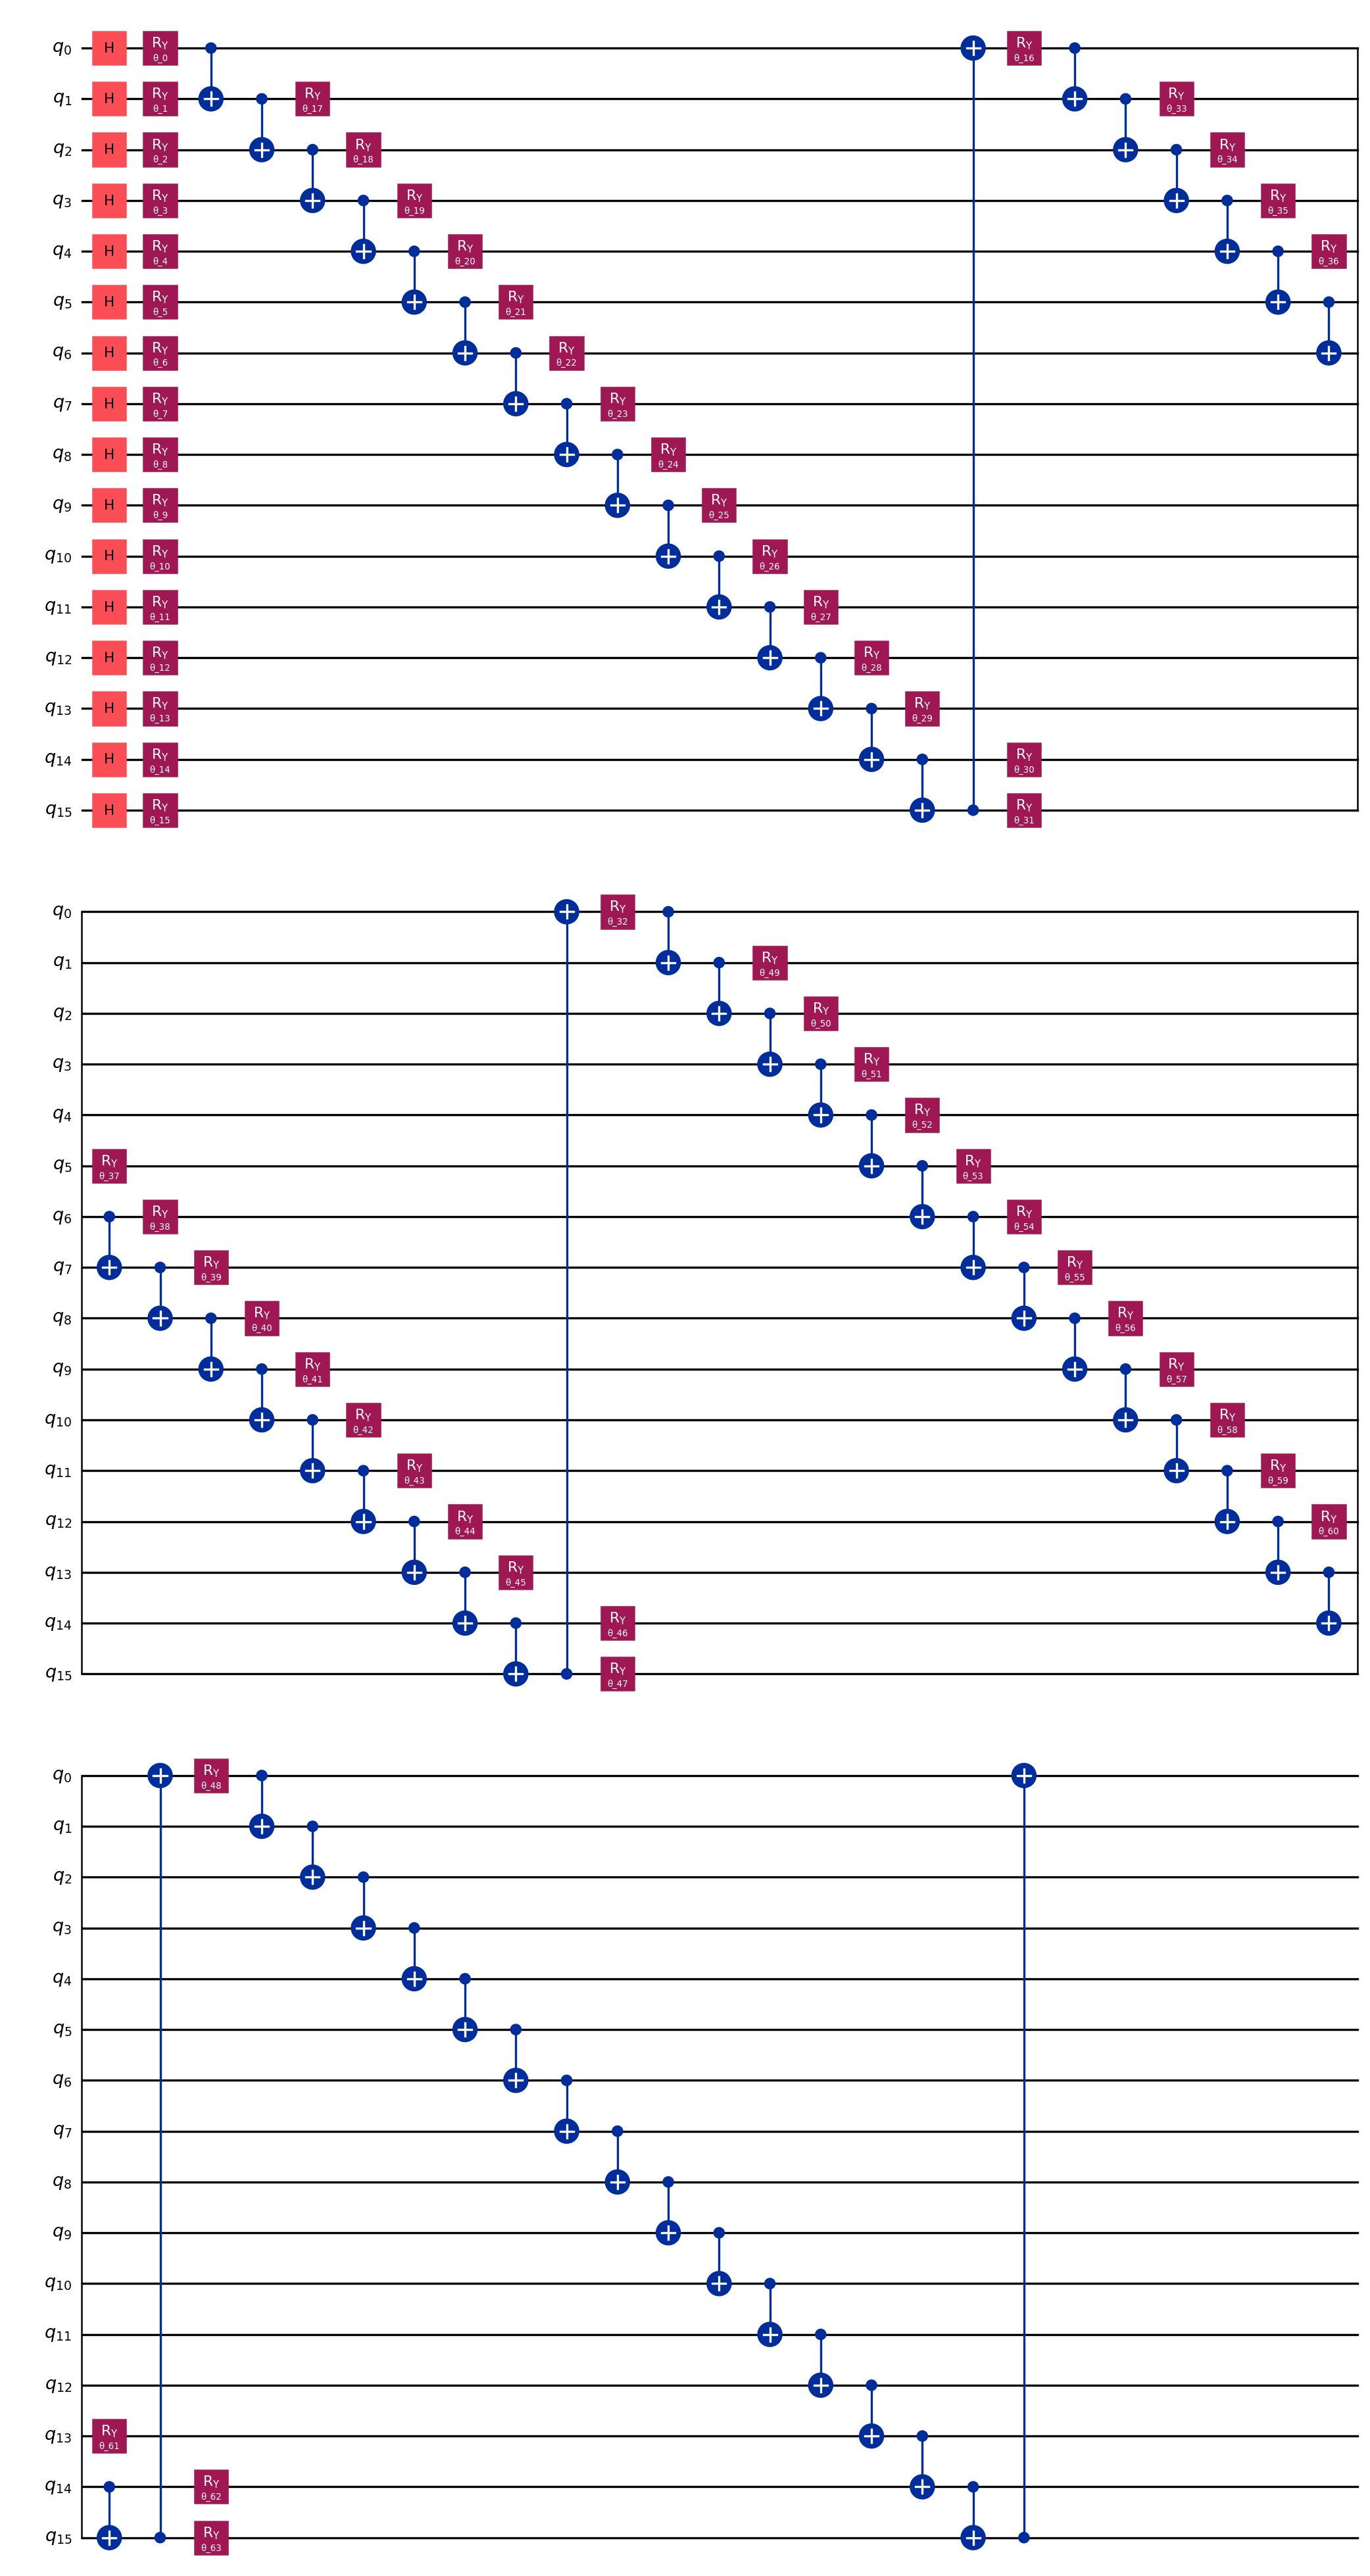

In [43]:
q_ansatz.draw('mpl')

In [44]:
# I take the same exact initial parameters as before
q_initial_params = np.array(pl_params_custom)  # Convert JAX array to numpy

# Setup the same optimizer as PennyLane
q_optimizer = L_BFGS_B(maxiter=500, iprint=1, max_evals_grouped=16)

# Set random seed for reproducibility
seed = 42
algorithm_globals.random_seed = seed

# Create the estimator for expectation value calculations
estimator = AerEstimator()

# Callback for Qiskit VQE to monitor progress
q_counts = []
q_values = []
q_parameters = []

def q_callback(eval_count, parameters_array, mean, std):
    """Callback function for monitoring VQE progress"""
    q_counts.append(eval_count)
    q_values.append(mean)
    q_parameters.append(parameters_array.tolist())
    print(f"Iteration {eval_count:3d}: Energy = {mean:.8f} Hartree")


In [45]:
# Bind parameters to the ansatz circuit
q_initial_circuit = q_ansatz.assign_parameters(q_initial_params)

# Calculate initial energy using estimator 
q_initial_job = estimator.run([(q_initial_circuit, q_H)])
q_initial_energy = q_initial_job.result()[0].data.evs

result = EigenstateResult()
result.eigenvalues = np.array([q_initial_energy])
q_initial_energy = problem.interpret(result).total_energies[0].real


# Calculate exact ground state energy with Qiskit
solver = NumPyMinimumEigensolver()
q_exact_result = solver.compute_minimum_eigenvalue(operator=q_H)
q_exact_energy = problem.interpret(q_exact_result).total_energies[0].real


# Comparison with PennyLane values
print(f"="*60)
print("DIRECT COMPARISON: PennyLane vs Qiskit")
print("="*60)
print(f"Initial energies:")
print(f"  PennyLane: {pl_initial_energy:.8f} Ha")
print(f"  Qiskit:    {q_initial_energy:.8f} Ha")
print(f"  Difference: {abs(pl_initial_energy - q_initial_energy):.10f} Ha")


print(f"\nExact ground state energies:")
print(f"  PennyLane: {pl_exact_energy:.8f} Ha")
print(f"  Qiskit:    {q_exact_energy:.8f} Ha")
print(f"  Difference: {abs(pl_exact_energy - q_exact_energy):.10f} Ha")

DIRECT COMPARISON: PennyLane vs Qiskit
Initial energies:
  PennyLane: -33.89778663 Ha
  Qiskit:    -32.08208815 Ha
  Difference: 1.8156984750 Ha

Exact ground state energies:
  PennyLane: -55.52454749 Ha
  Qiskit:    -55.52454749 Ha
  Difference: 0.0000000000 Ha


In [46]:
# Run the VQE algorithm with L-BFGS-B optimizer (load data if already computed)

# Check if any file matching vqe_progress_qiskit_*.json exists
q_progress_files = glob.glob("results/vqe_progress_qiskit_*.json")
if q_progress_files:
    print(f"Found Qiskit progress file: {q_progress_files}")
    # Load the latest file
    with open(q_progress_files[-1], 'r') as f:
        q_result_data = json.load(f)
    class QiskitMockResult:
        def __init__(self, data):
            self.eigenvalue = data.get('final_energy', None)
            self.cost_function_evals = data.get('function_evaluations', None)
            self.callback_data = {
                'energies': data.get('energies', []),
                'parameters': data.get('parameters', []),
                'counts': data.get('counts', []),
                'iterations': data.get('total_iterations', 0)
            }
    q_result = QiskitMockResult(q_result_data)

    # Set variables as if from a real computation
    q_result = q_result
    q_counts = q_result.callback_data['counts']
    q_values = q_result.callback_data['energies']
    q_parameters = q_result.callback_data['parameters']
    q_iterations = q_result.callback_data['iterations']
    q_optimization_time = q_result_data.get('optimization_time', None)
    q_energy = q_result_data.get('final_energy')

    print("Loaded Qiskit VQE result from file.")
else:
    print("No Qiskit progress file found.")

    # Clear callback data
    q_counts = []
    q_values = []
    q_parameters = []

    # Create and run VQE
    q_vqe = VQE(
        estimator=estimator,
        ansatz=q_ansatz,
        optimizer=q_optimizer,
        callback=q_callback,
        initial_point=q_initial_params
    )

    # Record start time for timing comparison
    q_start_time = time.time()

    # Run the optimization
    q_result = q_vqe.compute_minimum_eigenvalue(operator=q_H)
    q_energy = problem.interpret(q_result).total_energies[0].real

    # Record end time
    q_end_time = time.time()
    q_optimization_time = q_end_time - q_start_time

    q_results_file = save_q_results(q_energy, q_result, q_counts, q_values, q_parameters, q_optimization_time)

    print(f"\nQiskit VQE optimization completed!")
    print(f"Optimization time: {q_optimization_time:.2f} seconds")
    print(f"Final energy: {q_energy:.8f} Ha")
    print(f"Raw eigenvalue: {q_result.eigenvalue:.8f} Ha")
    print(f"Number of function evaluations: {q_result.cost_function_evals}")
    print(f"Total callback iterations: {len(q_counts)}")

Found Qiskit progress file: ['results/vqe_progress_qiskit_1759063181.json']
Loaded Qiskit VQE result from file.


In [47]:
# Extract timing data for comparison
pl_optimization_time = pl_result_custom.callback_data['times'][-1] if pl_result_custom.callback_data['times'] else None
pl_iterations = len(pl_result_custom.callback_data['energies'])

q_iterations = len(q_counts)

print("   Framework         | Final Energy (Ha) | Error (mHa) | Optimization Time (s)")
print("   " + "-" * 85)

# Compare with exact energy if available
pl_error = abs(pl_result_custom.fun - pl_exact_energy)
q_error = abs(q_energy - q_exact_energy)

print(f"   PennyLane        | {pl_result_custom.fun:.8f}         | {pl_error*1000:.3f}          | {pl_optimization_time:.2f} s             ")
print(f"   Qiskit           | {q_energy:.8f}         | {q_error*1000:.3f}          | {q_optimization_time:.2f} s             ")

   Framework         | Final Energy (Ha) | Error (mHa) | Optimization Time (s)
   -------------------------------------------------------------------------------------
   PennyLane        | -54.26633131         | 1258.216          | 1990.34 s             
   Qiskit           | -54.58072493         | 943.823          | 83820.63 s             


In [48]:
# Like always we interpret the raw values to get meaningful energies
interpreted_energies = []
for energy in q_values:
    result = EigenstateResult()
    result.eigenvalues = np.array([energy])
    interpreted_energy = problem.interpret(result).total_energies[0].real
    interpreted_energies.append(interpreted_energy)

# Overwrite the original energies with the interpreted ones
q_values = interpreted_energies

# Remove similar consecutive values with tolerance 1e-8 and track removed indices
filtered_q_values = []
filtered_q_parameters = []
kept_indices = []  # Track which indices we keep
tol = 1e-8

if q_values:
    filtered_q_values.append(q_values[0])  # Always keep the first value
    if q_parameters:  # Check if parameters exist
        filtered_q_parameters.append(q_parameters[0])
    kept_indices.append(0)
    
    for i in range(1, len(q_values)):
        # Check if current value is significantly different from the last kept value
        if abs(q_values[i] - filtered_q_values[-1]) > tol:
            filtered_q_values.append(q_values[i])
            if q_parameters and i < len(q_parameters):  # Check bounds
                filtered_q_parameters.append(q_parameters[i])
            kept_indices.append(i)

# Update both lists
q_values = filtered_q_values
q_parameters = filtered_q_parameters

print(f"Kept {len(kept_indices)} out of {len(interpreted_energies)} iterations")
print(f"Removed {len(interpreted_energies) - len(kept_indices)} iterations")


Kept 204 out of 1494 iterations
Removed 1290 iterations


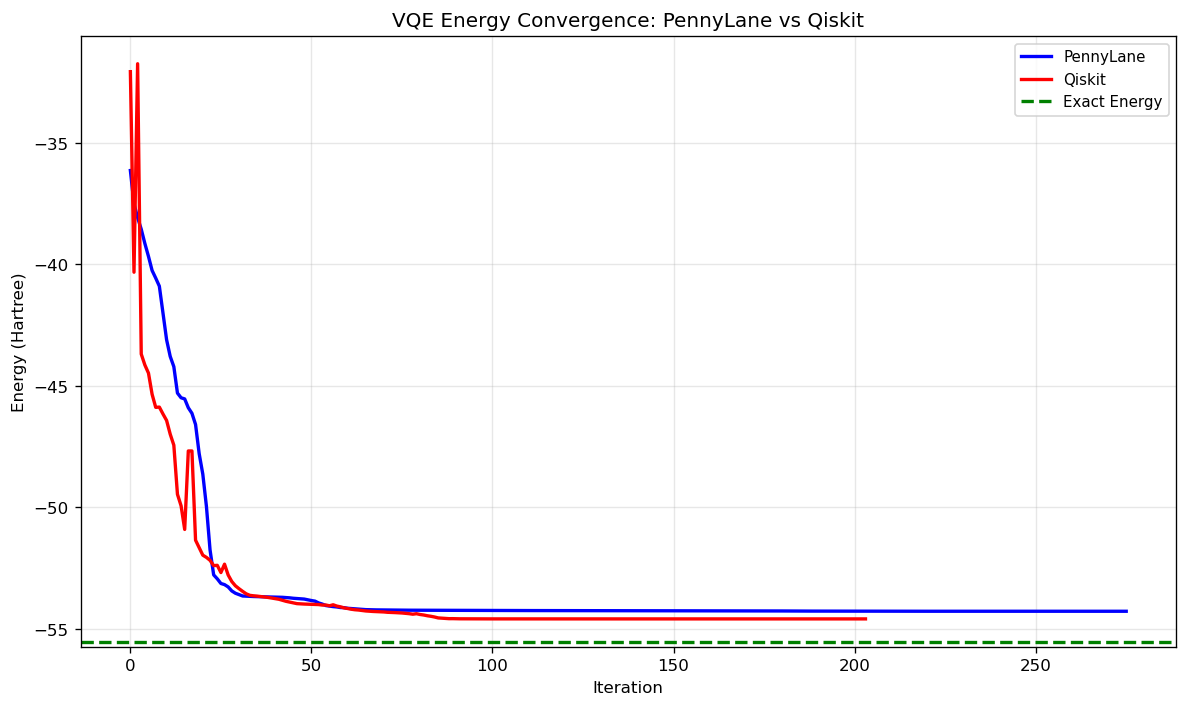

In [49]:
# Now we can plot the two optimizations together
q_energies = q_values
q_iterations = len(q_energies)
pl_energies = pl_result_custom.callback_data['energies']
pl_iterations = len(pl_energies)

# Plot comparison of energy convergence
plt.figure(figsize=(10, 6))
plt.plot(range(pl_iterations), pl_energies, 'b-', label='PennyLane', linewidth=2)
plt.plot(range(q_iterations), q_energies, 'r-', label='Qiskit', linewidth=2)
if pl_exact_energy is not None:
    plt.axhline(y=pl_exact_energy, color='g', linestyle='--', linewidth=2, label='Exact Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energy Convergence: PennyLane vs Qiskit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

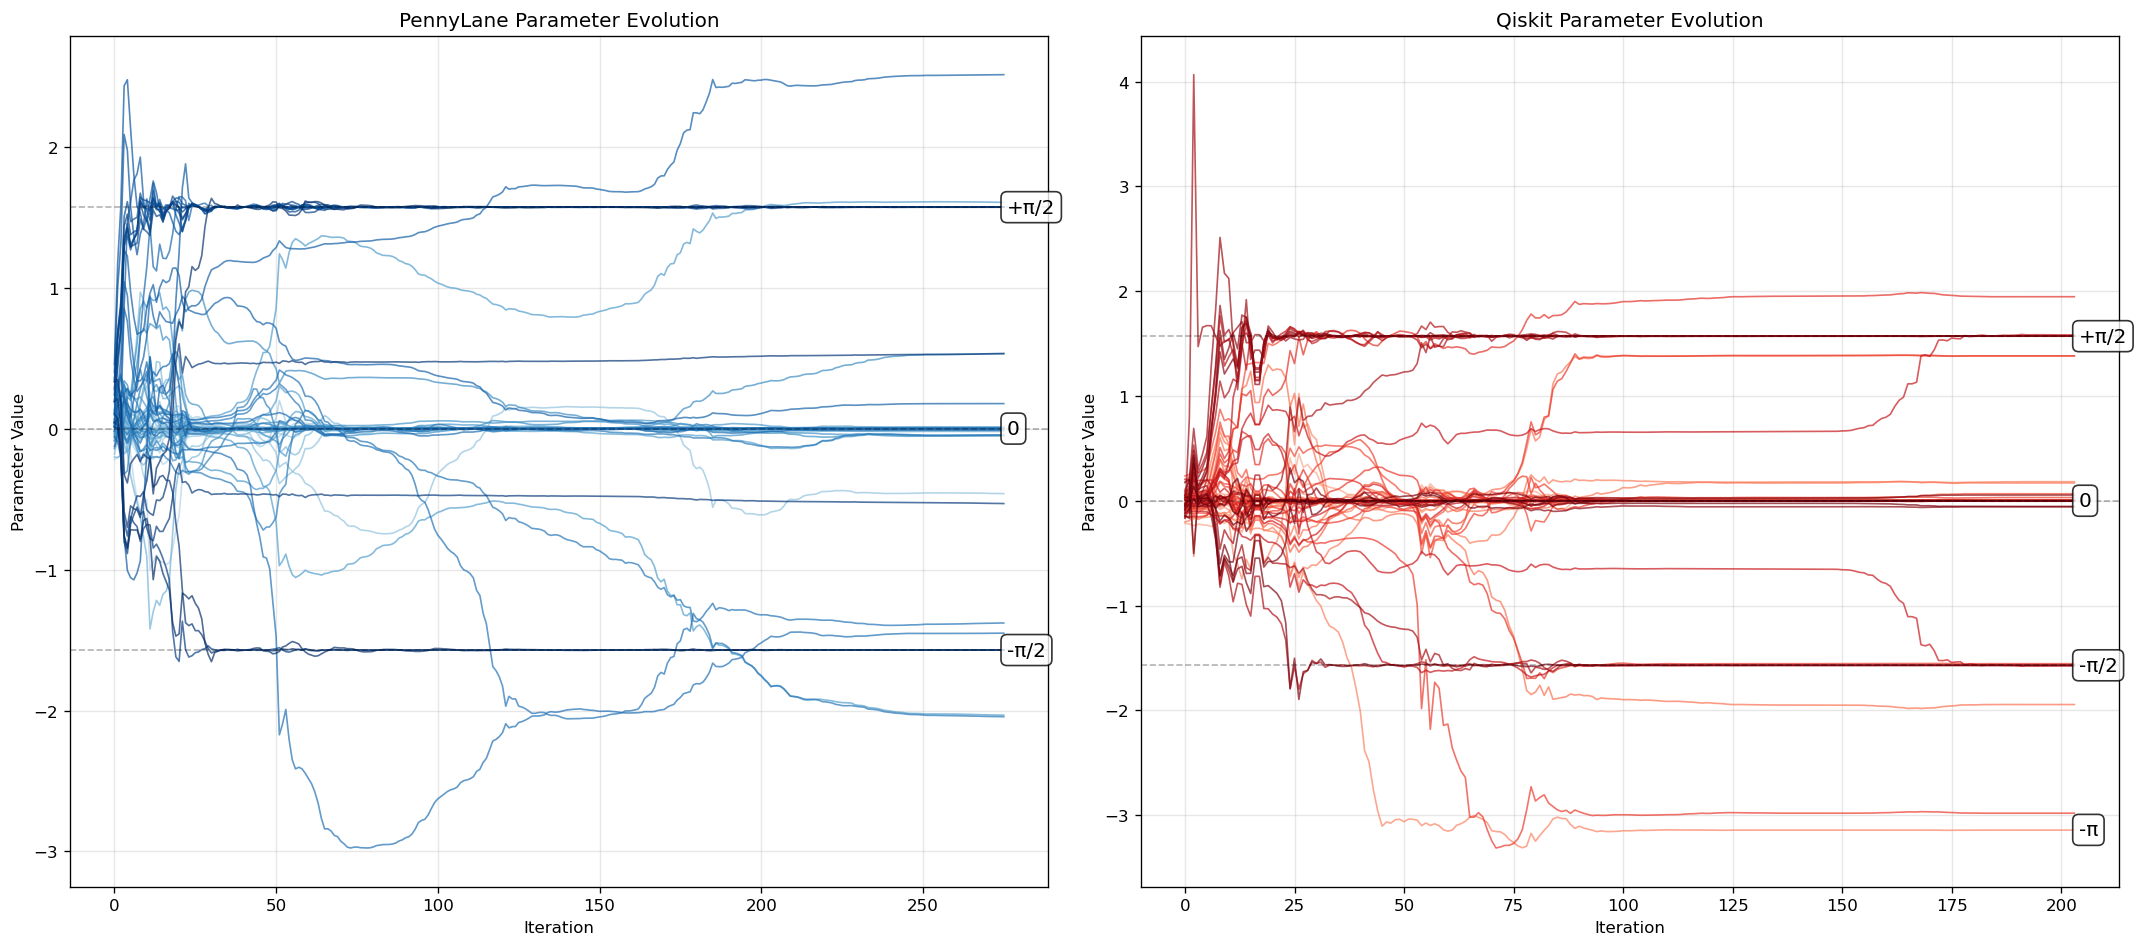

In [50]:
# Here we plot the parameter evolution for both frameworks
plt.figure(figsize=(18, 8))

# Plot 1: Parameter evolution for PennyLane
plt.subplot(1, 2, 1)
params_array = np.array(pl_result_custom.callback_data['parameters'])
n_params = params_array.shape[1]

# Create different shades of blue for each parameter
blue_colors = plt.cm.Blues(np.linspace(0.3, 1.0, n_params))

for i in range(n_params):
    plt.plot(params_array[:, i], color=blue_colors[i], alpha=0.7, linewidth=1)

# Add horizontal markers instead of lines
plt.scatter([], [], marker='_', s=100, color='black', alpha=0.7, label='0')
plt.scatter([], [], marker='_', s=100, color='black', alpha=0.7, label='+π/2')
plt.scatter([], [], marker='_', s=100, color='black', alpha=0.7, label='-π/2')

# Add the actual markers at the reference values
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
plt.axhline(y=np.pi/2, color='black', linestyle='--', alpha=0.3, linewidth=1)
plt.axhline(y=-np.pi/2, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Add text labels at the right edge
plt.text(len(params_array), 0, '0', fontsize=12, ha='left', va='center', 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
plt.text(len(params_array), np.pi/2, '+π/2', fontsize=12, ha='left', va='center',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
plt.text(len(params_array), -np.pi/2, '-π/2', fontsize=12, ha='left', va='center',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
plt.title('PennyLane Parameter Evolution')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.grid(True, alpha=0.3)

# Plot 2: Parameter evolution for Qiskit
plt.subplot(1, 2, 2)
params_array = np.array(q_parameters)
n_params = params_array.shape[1]

# Create different shades of red for each parameter
red_colors = plt.cm.Reds(np.linspace(0.3, 1.0, n_params))

for i in range(n_params):
    plt.plot(params_array[:, i], color=red_colors[i], alpha=0.7, linewidth=1)

# Add horizontal reference lines (subtle)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
plt.axhline(y=np.pi/2, color='black', linestyle='--', alpha=0.3, linewidth=1)
plt.axhline(y=-np.pi/2, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Add text labels at the right edge
plt.text(len(params_array), 0, '0', fontsize=12, ha='left', va='center',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
plt.text(len(params_array), np.pi/2, '+π/2', fontsize=12, ha='left', va='center',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
plt.text(len(params_array), -np.pi/2, '-π/2', fontsize=12, ha='left', va='center',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
plt.text(len(params_array), -np.pi, '-π', fontsize=12, ha='left', va='center',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.title('Qiskit Parameter Evolution')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

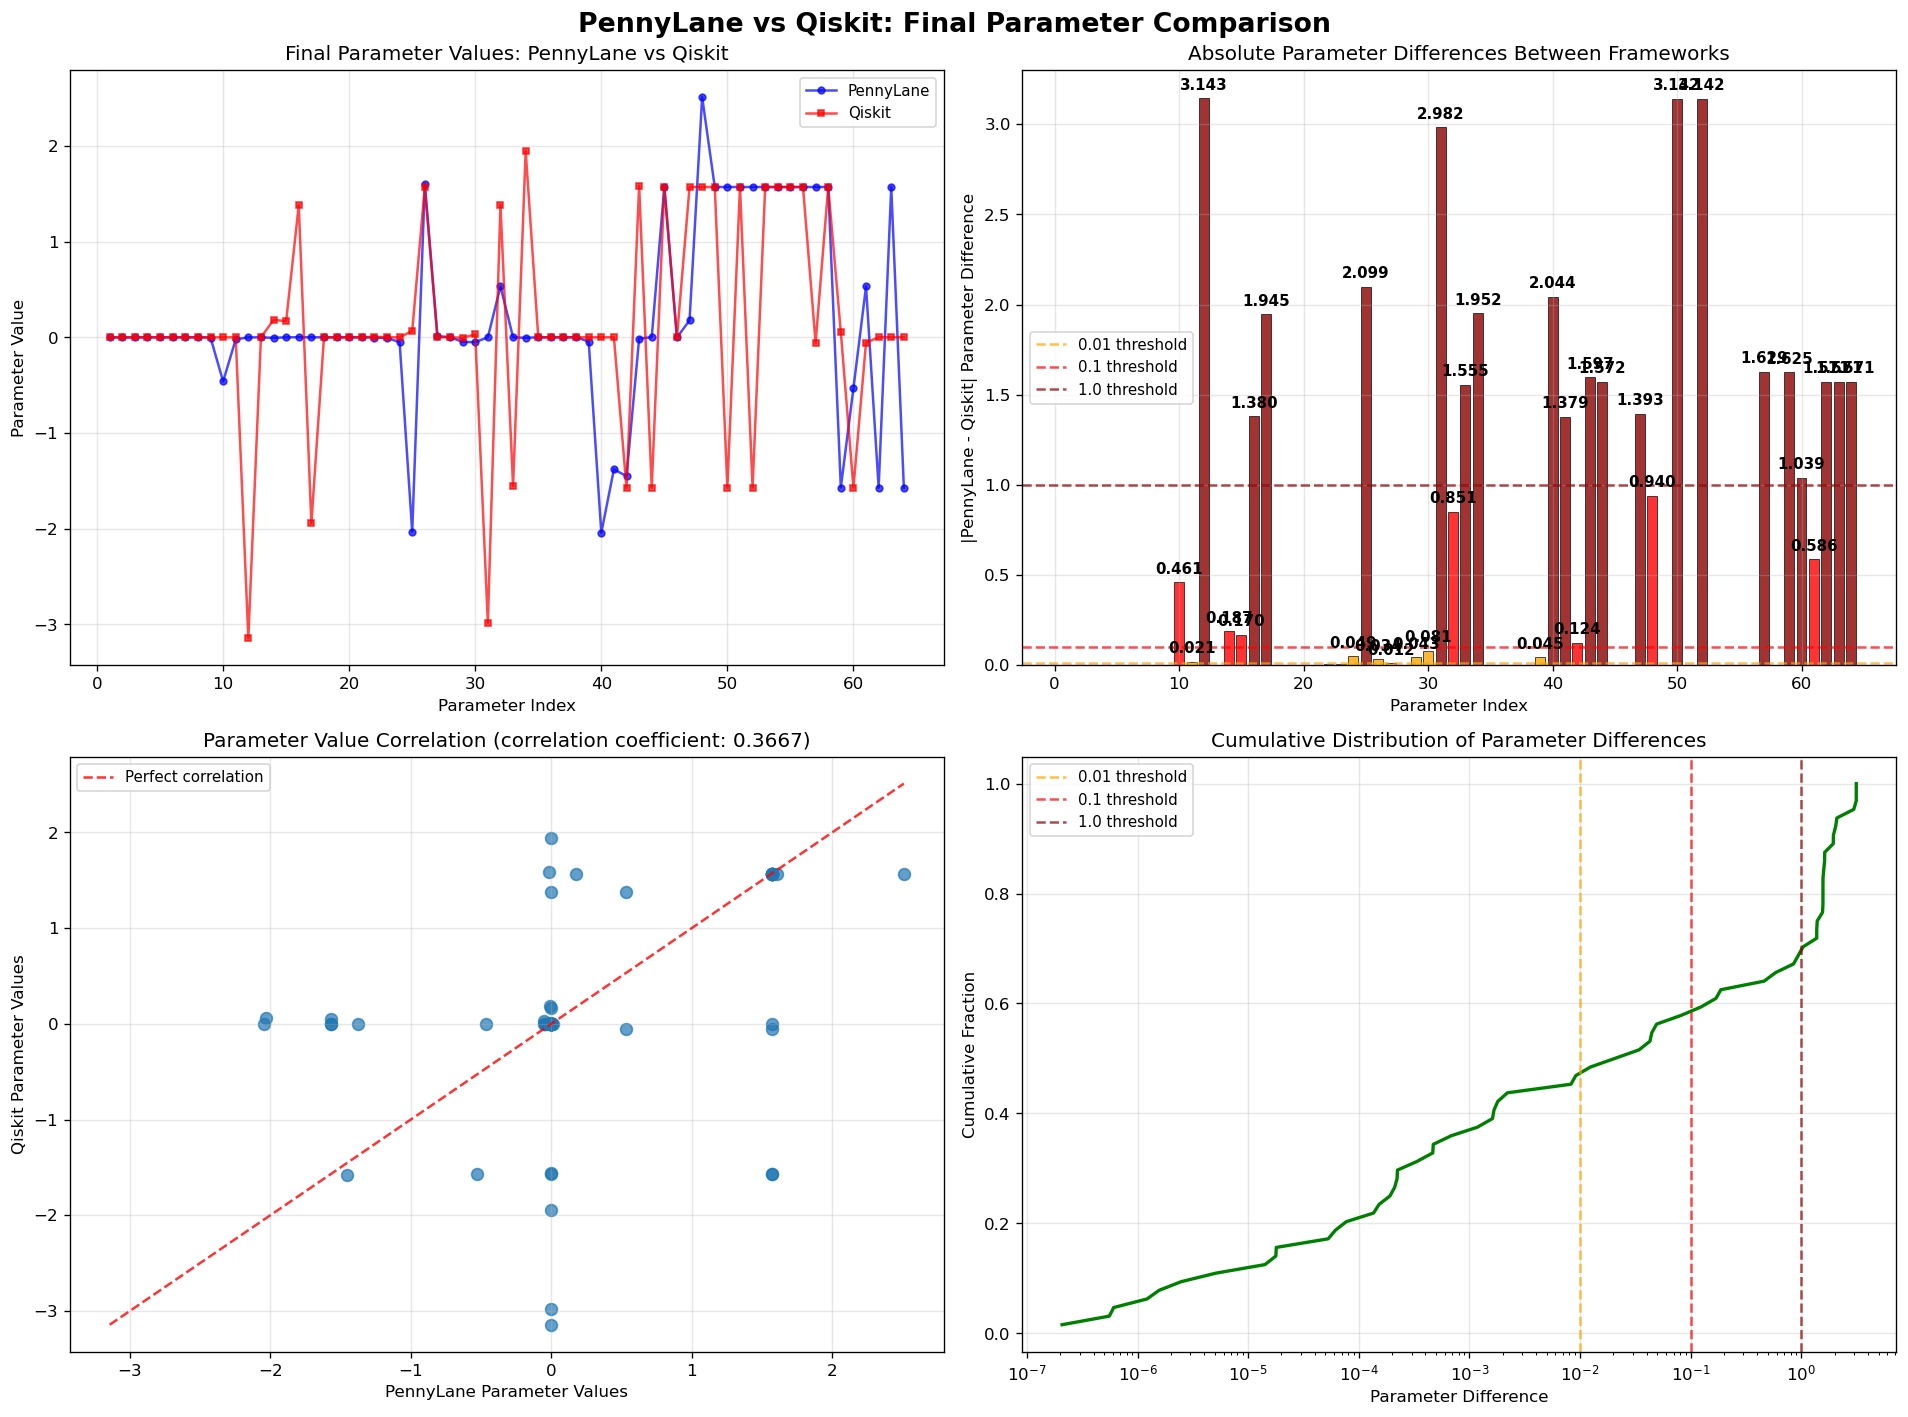

In [51]:
# Extract final parameters from both PennyLane and Qiskit results
pl_final_params = np.array(pl_result_custom.callback_data['parameters'][-1])
q_final_params = np.array(q_parameters[-1])

# Calculate parameter differences
param_diff = np.abs(pl_final_params - q_final_params)
param_indices = np.arange(1, len(param_diff) + 1)

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Final parameter values comparison
ax1.plot(param_indices, pl_final_params, 'b-o', label='PennyLane', markersize=4, alpha=0.7)
ax1.plot(param_indices, q_final_params, 'r-s', label='Qiskit', markersize=4, alpha=0.7)
ax1.set_xlabel('Parameter Index')
ax1.set_ylabel('Parameter Value')
ax1.set_title('Final Parameter Values: PennyLane vs Qiskit')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Absolute differences between parameters
colors = ['darkred' if diff > 1.0 else 'red' if diff > 0.1 else 'orange' if diff > 0.01 else 'lightblue' 
          for diff in param_diff]
bars = ax2.bar(param_indices, param_diff, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add threshold lines
ax2.axhline(y=0.01, color='orange', linestyle='--', alpha=0.7, label='0.01 threshold')
ax2.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='0.1 threshold')
ax2.axhline(y=1.0, color='darkred', linestyle='--', alpha=0.7, label='1.0 threshold')

# Label significant differences
for i, (bar, diff) in enumerate(zip(bars, param_diff)):
    if diff > 0.01:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(param_diff)*0.01,
               f'{diff:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_xlabel('Parameter Index')
ax2.set_ylabel('|PennyLane - Qiskit| Parameter Difference')
ax2.set_title('Absolute Parameter Differences Between Frameworks')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Parameter correlation scatter plot
ax3.scatter(pl_final_params, q_final_params, alpha=0.7, s=50)
# Add perfect correlation line
min_val = min(np.min(pl_final_params), np.min(q_final_params))
max_val = max(np.max(pl_final_params), np.max(q_final_params))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect correlation')
ax3.set_xlabel('PennyLane Parameter Values')
ax3.set_ylabel('Qiskit Parameter Values')
ax3.set_title('Parameter Value Correlation (correlation coefficient: 'f'{np.corrcoef(pl_final_params, q_final_params)[0,1]:.4f})')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative difference distribution
sorted_diffs = np.sort(param_diff)
cumulative = np.arange(1, len(sorted_diffs) + 1) / len(sorted_diffs)
ax4.plot(sorted_diffs, cumulative, 'g-', linewidth=2)
ax4.axvline(x=0.01, color='orange', linestyle='--', alpha=0.7, label='0.01 threshold')
ax4.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='0.1 threshold')
ax4.axvline(x=1.0, color='darkred', linestyle='--', alpha=0.7, label='1.0 threshold')
ax4.set_xlabel('Parameter Difference')
ax4.set_ylabel('Cumulative Fraction')
ax4.set_title('Cumulative Distribution of Parameter Differences')
ax4.set_xscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('PennyLane vs Qiskit: Final Parameter Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

<p align="center">
  <img src="Bloch-sphere-and-effects-of-rotation-gates.png" alt="Rotation of each gate" width="500">
</p>


When a variational circuit uses only $R_Y$ rotations, each parameter directly sets the angle of a rotation about the $y$-axis on the Bloch sphere. The single-qubit gate

$$
R_Y(\theta) = e^{-i\theta Y/2}
$$

rotates the Bloch vector by an angle $\theta$ around the $y$-axis, mapping

$$
|0\rangle \;\longmapsto\;
|\psi(\theta)\rangle
  = \cos\!\left(\frac{\theta}{2}\right)|0\rangle
    + \sin\!\left(\frac{\theta}{2}\right)|1\rangle .
$$

The probability of measuring $|1\rangle$ is therefore

$$
P_1(\theta) = \sin^2\!\left(\frac{\theta}{2}\right).
$$

Because $\sin^2(\theta/2)$ is periodic with period $2\pi$ and symmetric about $\theta=\pi$, many cost functions depend only on this probability (or on expectation values that share this periodicity). The resulting optimization landscape thus has multiple equivalent minima corresponding to angles that yield the same expectation values:

$$
R_Y(\theta) \equiv R_Y(\theta + 2k\pi), 
\qquad
R_Y(\theta) \equiv R_Y(\pi - \theta)
\quad (k \in \mathbb{Z}).
$$

From a landscape perspective, this creates flat valleys or symmetric minima around

$$
\theta \approx 0, \;\; \pm \frac{\pi}{2}, \;\; \pm \pi,
$$

so the optimizer can “settle” in any of these positions with nearly identical cost. These are exactly the angles you observe clustering in your optimized parameters. The choice of $R_Y$ alone reinforces this behavior because it restricts rotations to a single axis, making the cost function effectively a simple, periodic function of each parameter.


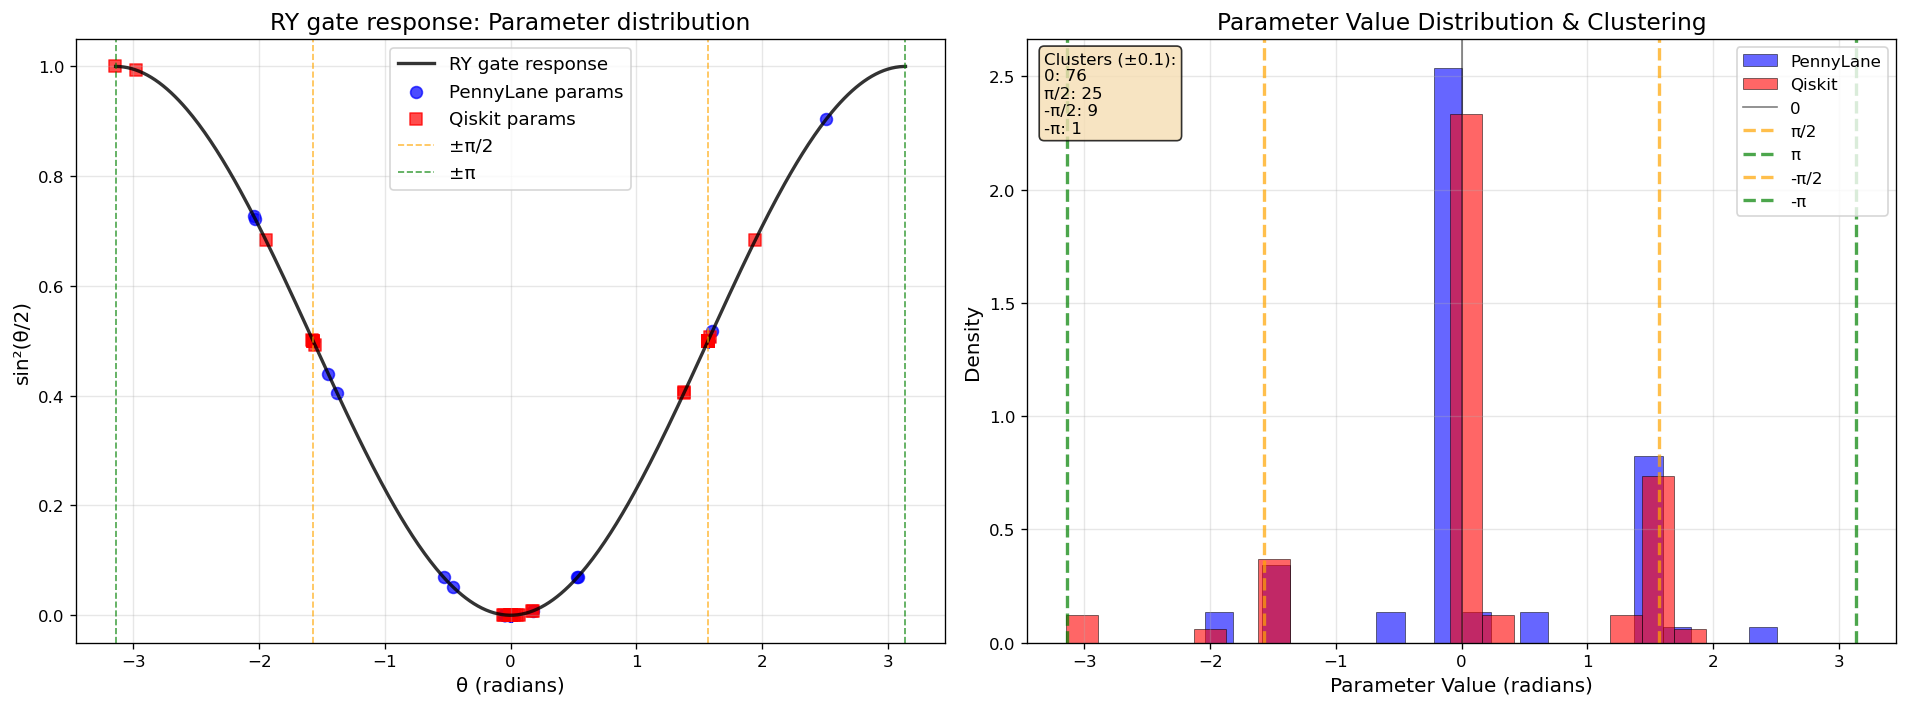

In [52]:
# --- Combined plot with density visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Original RY gate response with parameters
theta = np.linspace(-np.pi, np.pi, 400)
ry_prob = np.sin(theta/2)**2

ax1.plot(theta, ry_prob, 'k-', lw=2, label='RY gate response', alpha=0.8)
ax1.scatter(pl_final_params, np.sin(pl_final_params/2)**2, 
           color='blue', s=50, alpha=0.7, label='PennyLane params', marker='o')
ax1.scatter(q_final_params, np.sin(q_final_params/2)**2, 
           color='red', s=50, alpha=0.7, label='Qiskit params', marker='s')

# Reference lines
ax1.axvline(np.pi/2, color='orange', ls='--', lw=1, alpha=0.7, label='±π/2')
ax1.axvline(np.pi, color='green', ls='--', lw=1, alpha=0.7, label='±π')
ax1.axvline(-np.pi/2, color='orange', ls='--', lw=1, alpha=0.7)
ax1.axvline(-np.pi, color='green', ls='--', lw=1, alpha=0.7)

ax1.set_xlabel('θ (radians)', fontsize=12)
ax1.set_ylabel('sin²(θ/2)', fontsize=12)
ax1.set_title('RY gate response: Parameter distribution', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Right plot: Parameter density histogram
ax2.hist(pl_final_params, bins=20, alpha=0.6, color='blue', 
         label='PennyLane', density=True, edgecolor='black', linewidth=0.5)
ax2.hist(q_final_params, bins=20, alpha=0.6, color='red', 
         label='Qiskit', density=True, edgecolor='black', linewidth=0.5)

# Add vertical lines for key values
ax2.axvline(0, color='black', ls='-', lw=1, alpha=0.5, label='0')
ax2.axvline(np.pi/2, color='orange', ls='--', lw=2, alpha=0.7, label='π/2')
ax2.axvline(np.pi, color='green', ls='--', lw=2, alpha=0.7, label='π')
ax2.axvline(-np.pi/2, color='orange', ls='--', lw=2, alpha=0.7, label='-π/2')
ax2.axvline(-np.pi, color='green', ls='--', lw=2, alpha=0.7, label='-π')

# Count parameters near key values (within 0.1 radians)
tolerance = 0.1
all_params = np.concatenate([pl_final_params, q_final_params])
key_values = [0, np.pi/2, np.pi, -np.pi/2, -np.pi, 3*np.pi/2, -3*np.pi/2]
key_labels = ['0', 'π/2', 'π', '-π/2', '-π', '3π/2', '-3π/2']

clustering_info = []
for val, label in zip(key_values, key_labels):
    count = np.sum(np.abs(all_params - val) < tolerance)
    if count > 0:
        clustering_info.append(f"{label}: {count}")

ax2.text(0.02, 0.98, f"Clusters (±{tolerance:.1f}):\n" + "\n".join(clustering_info), 
         transform=ax2.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax2.set_xlabel('Parameter Value (radians)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Parameter Value Distribution & Clustering', fontsize=14)
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---
## Effect of custom ansatz depth
---

This section examines how the number of layers in the custom ansatz (from 1 to 5) impacts VQE results.  
By running multiple trials at each depth, we evaluate how circuit size influences convergence speed and the accuracy of the estimated ground-state energy.


In [53]:
# We now try to learn how the number of layers in our custom ansatz affects the final energy
# and the convergence of the optimization
# We will run the same optimization as before but changing only the number of layers
# We will use Pennylane implementation since it's faster

# VQE for different number of layers [1, 2, 3, 4, 5] with varying runs per layer
n_layers_list = [1, 2, 3, 4, 5]
runs_per_layer = [25, 25, 25, 11, 7]  # Different number of runs for each layer
pl_final_energies = []
pl_convergence = []
pl_all_runs = {}  # Store all runs for each layer

for i, n_layers in enumerate(n_layers_list):
    n_runs_per_layer = runs_per_layer[i]
    print(f"\nRunning VQE for n_layers = {n_layers} with {n_runs_per_layer} runs")
    n_params = n_layers * pl_qubits
    
    layer_energies = []
    layer_convergence = []
    
    for run in range(n_runs_per_layer):
        print(f"  Run {run + 1}/{n_runs_per_layer}")
        
        result_file_pattern = f"diff_layers/vqe_progress_custom_{n_layers}layers_run{run}_*.json"
        result_files = glob.glob(result_file_pattern)
        
        if result_files:
            # Load existing result
            result_files.sort()
            with open(result_files[-1], 'r') as f:
                data = json.load(f)
            layer_energies.append(data['energies'][-1])
            layer_convergence.append(data['energies'])
            print(f"    Loaded previous result: {data['energies'][-1]:.8f} Ha")
        else:
            # New initial parameters for each run (different random seed)
            pl_key_tmp = pl_random.PRNGKey(42 + run)  # Different seed for each run
            pl_params_tmp = pl_random.normal(pl_key_tmp, (n_params,)) * 0.1
            
            # Run VQE
            pl_result_tmp = pl_optimize_vqe(
                pl_params_tmp, 
                pl_H, 
                pl_ansatz_type=f"custom_{n_layers}layers_run{run}", 
                method="L-BFGS-B", 
                maxiter=500
            )
            layer_energies.append(pl_result_tmp.fun)
            layer_convergence.append(pl_result_tmp.callback_data['energies'])
            print(f"    Final energy: {pl_result_tmp.fun:.8f} Ha")
        
    # Store results for this layer
    pl_all_runs[n_layers] = {
        'energies': layer_energies,
        'convergence': layer_convergence,
        'mean_energy': np.mean(layer_energies),
        'std_energy': np.std(layer_energies),
        'best_energy': min(layer_energies),
        'worst_energy': max(layer_energies)
    }
    
    print(f"  Layer {n_layers} summary:")
    print(f"    Mean energy: {np.mean(layer_energies):.8f} ± {np.std(layer_energies):.8f} Ha")
    print(f"    Best energy: {min(layer_energies):.8f} Ha")
    print(f"    Worst energy: {max(layer_energies):.8f} Ha")


Running VQE for n_layers = 1 with 25 runs
  Run 1/25
    Loaded previous result: -55.45541977 Ha
  Run 2/25
    Loaded previous result: -55.45541977 Ha
  Run 3/25
    Loaded previous result: -55.45541977 Ha
  Run 4/25
    Loaded previous result: -55.45541977 Ha
  Run 5/25
    Loaded previous result: -55.45541977 Ha
  Run 6/25
    Loaded previous result: -55.45541977 Ha
  Run 7/25
    Loaded previous result: -55.45541977 Ha
  Run 8/25
    Loaded previous result: -55.45541977 Ha
  Run 9/25
    Loaded previous result: -55.45541977 Ha
  Run 10/25
    Loaded previous result: -55.45541977 Ha
  Run 11/25
    Loaded previous result: -54.83041429 Ha
  Run 12/25
    Loaded previous result: -55.45541977 Ha
  Run 13/25
    Loaded previous result: -55.45541977 Ha
  Run 14/25
    Loaded previous result: -55.45541977 Ha
  Run 15/25
    Loaded previous result: -55.45541977 Ha
  Run 16/25
    Loaded previous result: -55.45541977 Ha
  Run 17/25
    Loaded previous result: -55.45541977 Ha
  Run 18/25
  

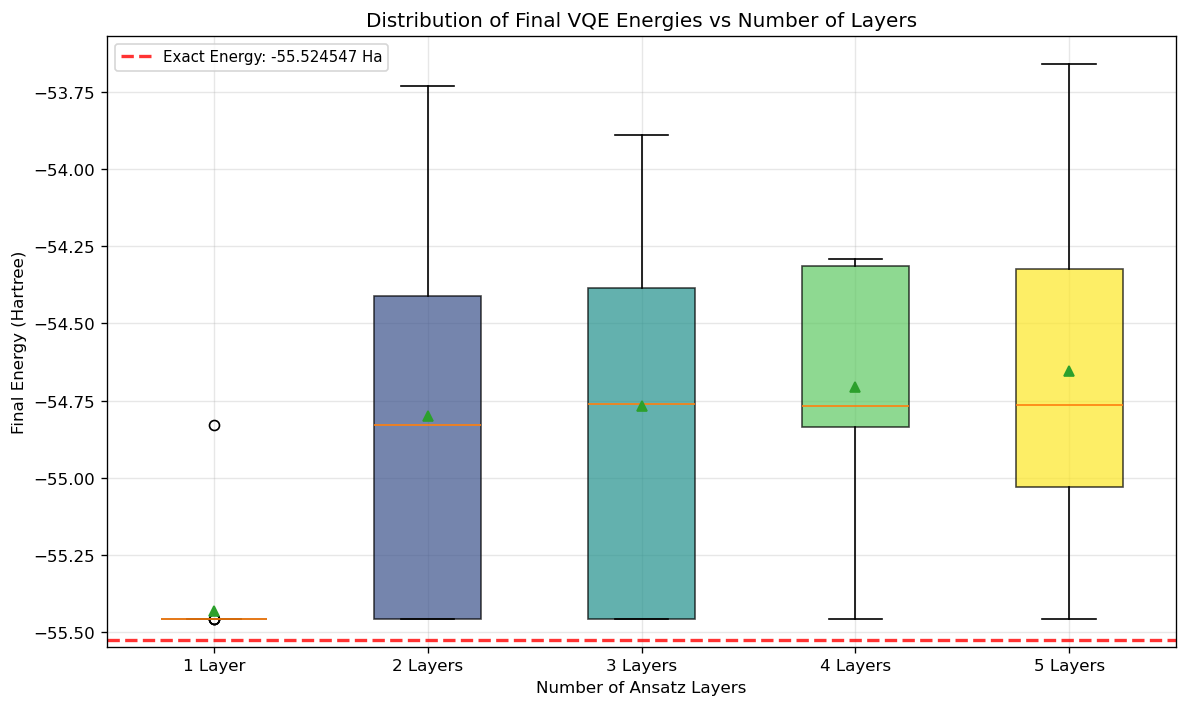

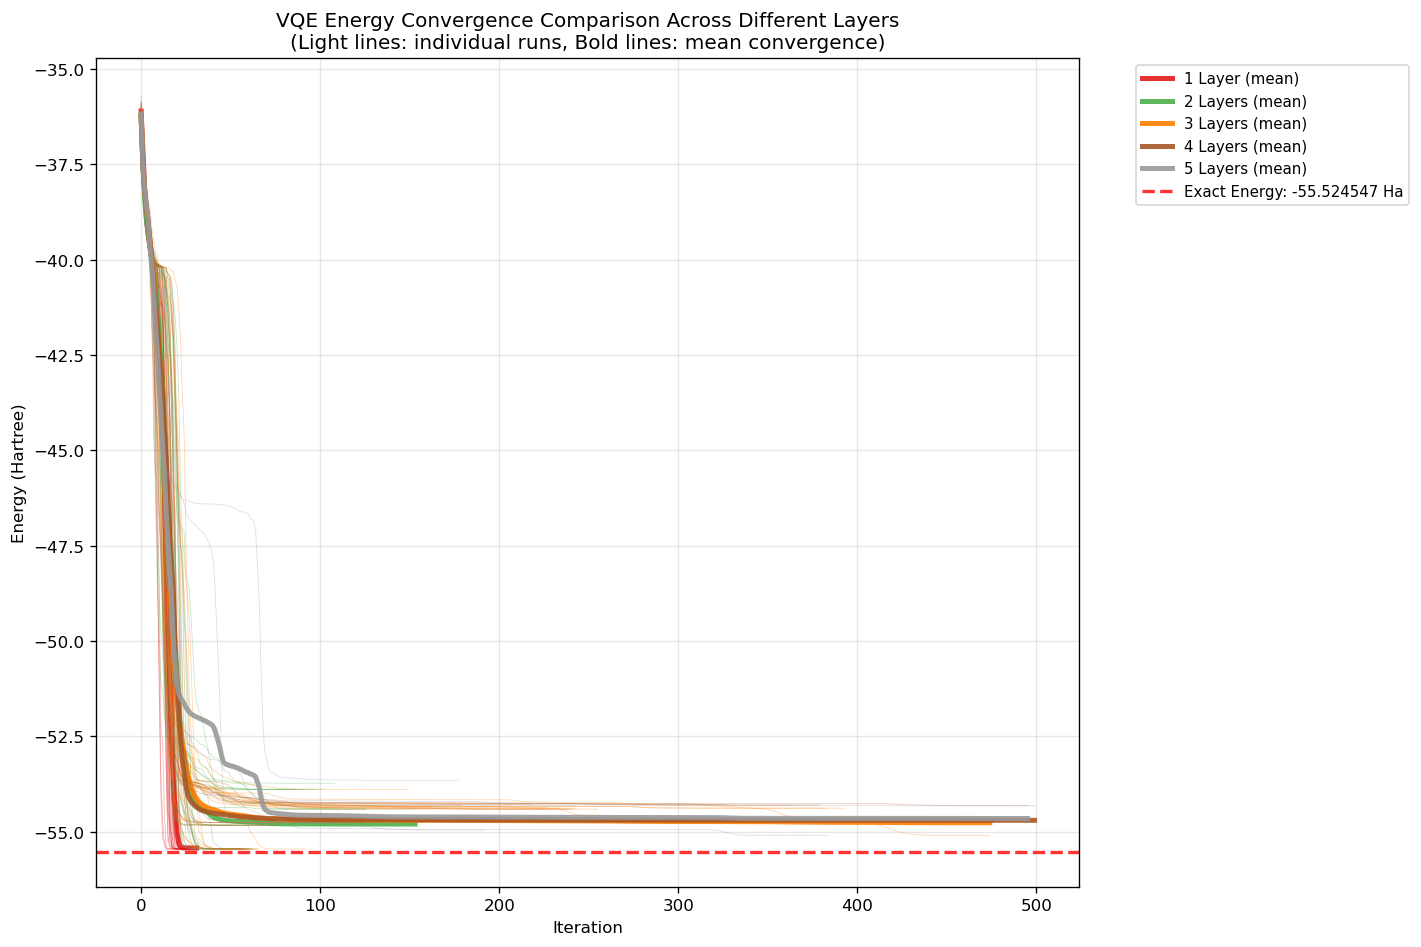

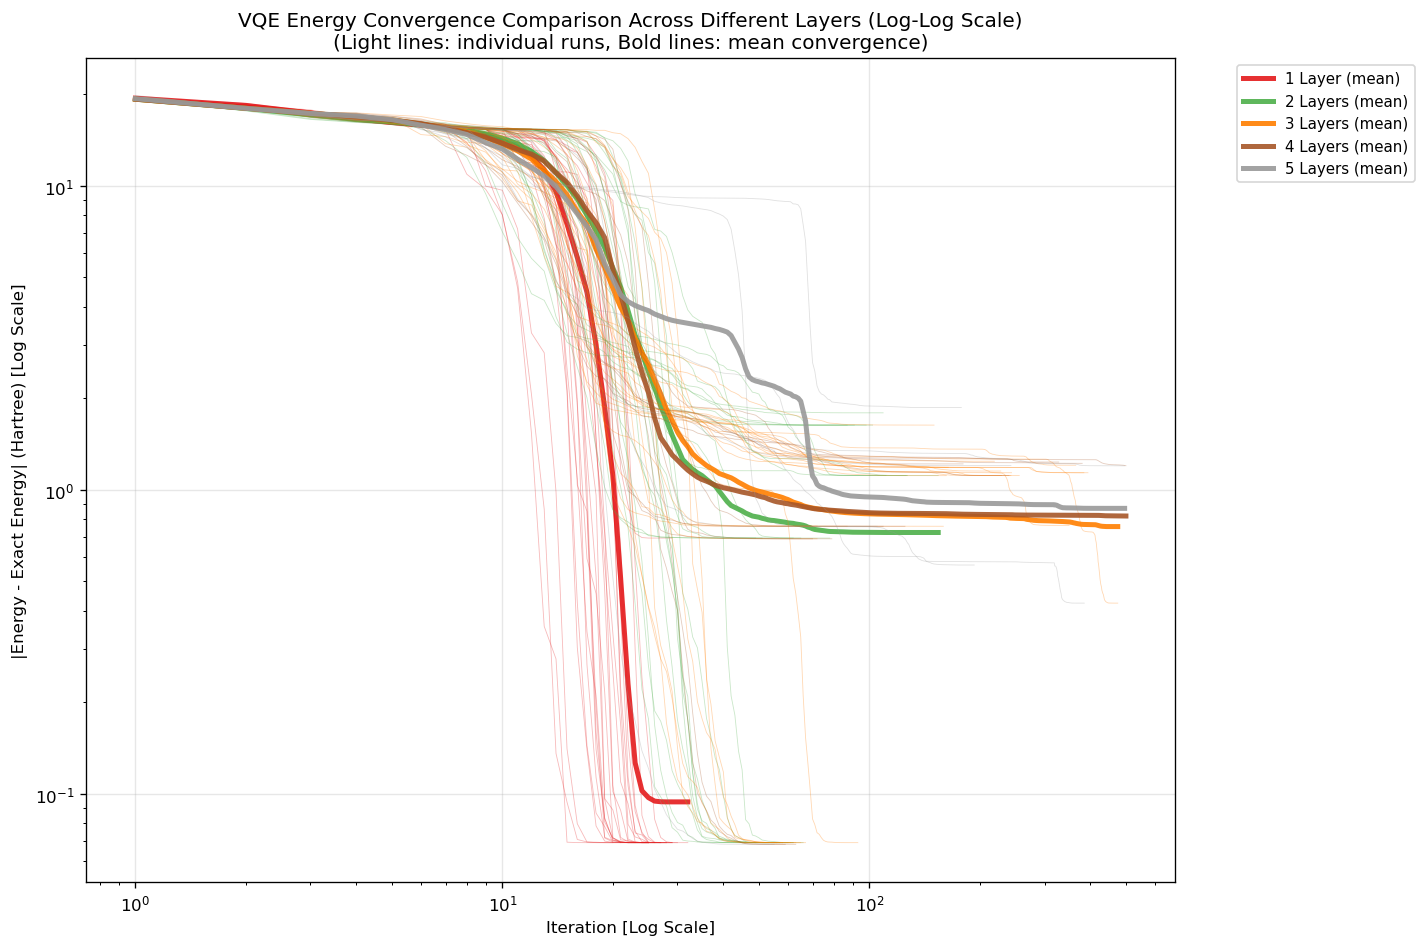


SUMMARY STATISTICS FOR DIFFERENT LAYERS
Layers   Mean Energy     Std Dev      Best Energy     Worst Energy   
--------------------------------------------------------------------------------
1        -55.43041955    0.12247556   -55.45541977    -54.83041429   
2        -54.80052661    0.61761234   -55.45541963    -53.73244662   
3        -54.76728838    0.48655773   -55.45541972    -53.89150261   
4        -54.70424679    0.41495427   -55.45628781    -54.29012123   
5        -54.65527045    0.55489896   -55.45628775    -53.65985546   
--------------------------------------------------------------------------------
Exact ground state energy: -55.52454749 Ha

Error from exact energy:
  1 layer: 0.06912772 Ha (best run)
  2 layers: 0.06912786 Ha (best run)
  3 layers: 0.06912776 Ha (best run)
  4 layers: 0.06825967 Ha (best run)
  5 layers: 0.06825974 Ha (best run)


In [54]:
# 1. Boxplot for final energy distribution per layer
plt.figure(figsize=(10, 6))

# Prepare data for boxplot
boxplot_data = []
labels = []
for n_layers in n_layers_list:
    if n_layers in pl_all_runs:
        boxplot_data.append(pl_all_runs[n_layers]['energies'])
        labels.append(f'{n_layers} Layer{"s" if n_layers > 1 else ""}')

# Create boxplot
box_plot = plt.boxplot(boxplot_data, tick_labels=labels, patch_artist=True, showmeans=True)

# Color the boxes
colors = plt.cm.viridis(np.linspace(0, 1, len(boxplot_data)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add exact energy reference line if available
plt.axhline(y=pl_exact_energy, color='red', linestyle='--', linewidth=2, 
            label=f'Exact Energy: {pl_exact_energy:.6f} Ha', alpha=0.8)
plt.legend()

plt.xlabel('Number of Ansatz Layers')
plt.ylabel('Final Energy (Hartree)')
plt.title('Distribution of Final VQE Energies vs Number of Layers')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Convergence lines plot with different colors per layer (NORMAL SCALE)
plt.figure(figsize=(12, 8))

# Define colors for each layer
layer_colors = plt.cm.Set1(np.linspace(0, 1, len(n_layers_list)))

# Plot convergence for each layer (showing all runs)
for i, n_layers in enumerate(n_layers_list):
    if n_layers in pl_all_runs:
        convergence_data = pl_all_runs[n_layers]['convergence']
        color = layer_colors[i]
        
        # Plot all runs for this layer with some transparency
        for j, run_convergence in enumerate(convergence_data):
            if run_convergence:  # Check if convergence data exists
                iterations = range(len(run_convergence))
                plt.plot(iterations, run_convergence, 
                        color=color, alpha=0.3, linewidth=0.5)
        
        # Plot the mean convergence line for this layer (thicker line)
        if convergence_data:
            # Calculate mean convergence (pad shorter sequences with their last value)
            max_iterations = max(len(conv) for conv in convergence_data if conv)
            padded_convergences = []
            
            for conv in convergence_data:
                if conv:
                    # Pad with last value if sequence is shorter
                    padded = conv + [conv[-1]] * (max_iterations - len(conv))
                    padded_convergences.append(padded)
            
            if padded_convergences:
                mean_convergence = np.mean(padded_convergences, axis=0)
                iterations = range(len(mean_convergence))
                plt.plot(iterations, mean_convergence, 
                        color=color, linewidth=3, 
                        label=f'{n_layers} Layer{"s" if n_layers > 1 else ""} (mean)', 
                        alpha=0.9)

# Add exact energy reference line if available
plt.axhline(y=pl_exact_energy, color='red', linestyle='--', linewidth=2, 
            label=f'Exact Energy: {pl_exact_energy:.6f} Ha', alpha=0.8)

plt.xlabel('Iteration')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energy Convergence Comparison Across Different Layers\n(Light lines: individual runs, Bold lines: mean convergence)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Convergence lines plot with different colors per layer (LOG-LOG SCALE)
plt.figure(figsize=(12, 8))

# Define colors for each layer
layer_colors = plt.cm.Set1(np.linspace(0, 1, len(n_layers_list)))

# Plot convergence for each layer (showing all runs)
for i, n_layers in enumerate(n_layers_list):
    if n_layers in pl_all_runs:
        convergence_data = pl_all_runs[n_layers]['convergence']
        color = layer_colors[i]
        
        # Plot all runs for this layer with some transparency
        for j, run_convergence in enumerate(convergence_data):
            if run_convergence:  # Check if convergence data exists
                # Convert to energy difference from exact (for log scale)
                energy_diff = [abs(energy - pl_exact_energy) for energy in run_convergence]
                # Use log scale for both x and y axes
                iterations = range(1, len(energy_diff) + 1)  # Start from 1 for log scale
                plt.loglog(iterations, energy_diff, 
                        color=color, alpha=0.3, linewidth=0.5)
        
        # Plot the mean convergence line for this layer (thicker line)
        if convergence_data:
            # Calculate mean convergence (pad shorter sequences with their last value)
            max_iterations = max(len(conv) for conv in convergence_data if conv)
            padded_convergences = []
            
            for conv in convergence_data:
                if conv:
                    # Pad with last value if sequence is shorter
                    padded = conv + [conv[-1]] * (max_iterations - len(conv))
                    padded_convergences.append(padded)
            
            if padded_convergences:
                mean_convergence = np.mean(padded_convergences, axis=0)
                # Convert to energy difference from exact (for log scale)
                mean_energy_diff = [abs(energy - pl_exact_energy) for energy in mean_convergence]
                iterations = range(1, len(mean_energy_diff) + 1)  # Start from 1 for log scale
                plt.loglog(iterations, mean_energy_diff, 
                        color=color, linewidth=3, 
                        label=f'{n_layers} Layer{"s" if n_layers > 1 else ""} (mean)', 
                        alpha=0.9)

plt.xlabel('Iteration [Log Scale]')
plt.ylabel('|Energy - Exact Energy| (Hartree) [Log Scale]')
plt.title('VQE Energy Convergence Comparison Across Different Layers (Log-Log Scale)\n(Light lines: individual runs, Bold lines: mean convergence)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Summary statistics table
print("\n" + "="*80)
print("SUMMARY STATISTICS FOR DIFFERENT LAYERS")
print("="*80)
print(f"{'Layers':<8} {'Mean Energy':<15} {'Std Dev':<12} {'Best Energy':<15} {'Worst Energy':<15}")
print("-"*80)

for n_layers in n_layers_list:
    if n_layers in pl_all_runs:
        stats = pl_all_runs[n_layers]
        print(f"{n_layers:<8} {stats['mean_energy']:<15.8f} {stats['std_energy']:<12.8f} "
              f"{stats['best_energy']:<15.8f} {stats['worst_energy']:<15.8f}")

print("-"*80)
print(f"Exact ground state energy: {pl_exact_energy:.8f} Ha")
print("\nError from exact energy:")
for n_layers in n_layers_list:
    if n_layers in pl_all_runs:
        error = abs(pl_all_runs[n_layers]['best_energy'] - pl_exact_energy)
        print(f"  {n_layers} layer{'s' if n_layers > 1 else ''}: {error:.8f} Ha (best run)")

---
## Effect of different initial parameters on convergence
---

Here we test how random starting values affect the optimizer's ability to reach the minimum energy, comparing 1-layer vs 2-layer ansatz circuits.  
Multiple runs with identical settings but different random seeds reveal the sensitivity of VQE convergence to initial parameters across different circuit depths.

In [55]:
# Load data for both 1 layer and 2 layers to compare initial parameter effects
compare_layers = [1, 2]
layer_data = {}

for n_layers in compare_layers:
    pl_final_energies = []
    pl_convergence = []
    n_runs_per_layer = runs_per_layer[n_layers_list.index(n_layers)]
    
    print(f"\nLoading data for {n_layers} layer{'s' if n_layers > 1 else ''}:")
    
    for run in range(n_runs_per_layer):
        ansatz_type = f"custom_{n_layers}layers_run{run}"
        result_file_pattern = f"diff_layers/vqe_progress_{ansatz_type}_*.json"
        result_files = glob.glob(result_file_pattern)
        if result_files:
            result_files.sort()
            with open(result_files[-1], 'r') as f:
                data = json.load(f)
            pl_final_energies.append(data['energies'][-1])
            pl_convergence.append(data['energies'])
            if run < 3:  # Only print first few to avoid spam
                print(f"  Run {run}: {data['energies'][-1]:.8f} Ha")
    
    layer_data[n_layers] = {
        'final_energies': pl_final_energies,
        'convergence': pl_convergence,
        'n_runs': len(pl_final_energies)
    }
    
    print(f"  Loaded {len(pl_final_energies)} runs total")

print(f"\nSummary:")
for n_layers in compare_layers:
    data = layer_data[n_layers]
    mean_energy = np.mean(data['final_energies'])
    std_energy = np.std(data['final_energies'])
    print(f"  {n_layers} layer{'s' if n_layers > 1 else ''}: {len(data['final_energies'])} runs, "
          f"mean = {mean_energy:.8f} ± {std_energy:.8f} Ha")


Loading data for 1 layer:
  Run 0: -55.45541977 Ha
  Run 1: -55.45541977 Ha
  Run 2: -55.45541977 Ha
  Loaded 25 runs total

Loading data for 2 layers:
  Run 0: -55.45541953 Ha
  Run 1: -54.40992717 Ha
  Run 2: -55.45541958 Ha
  Loaded 25 runs total

Summary:
  1 layer: 25 runs, mean = -55.43041955 ± 0.12247556 Ha
  2 layers: 25 runs, mean = -54.80052661 ± 0.61761234 Ha


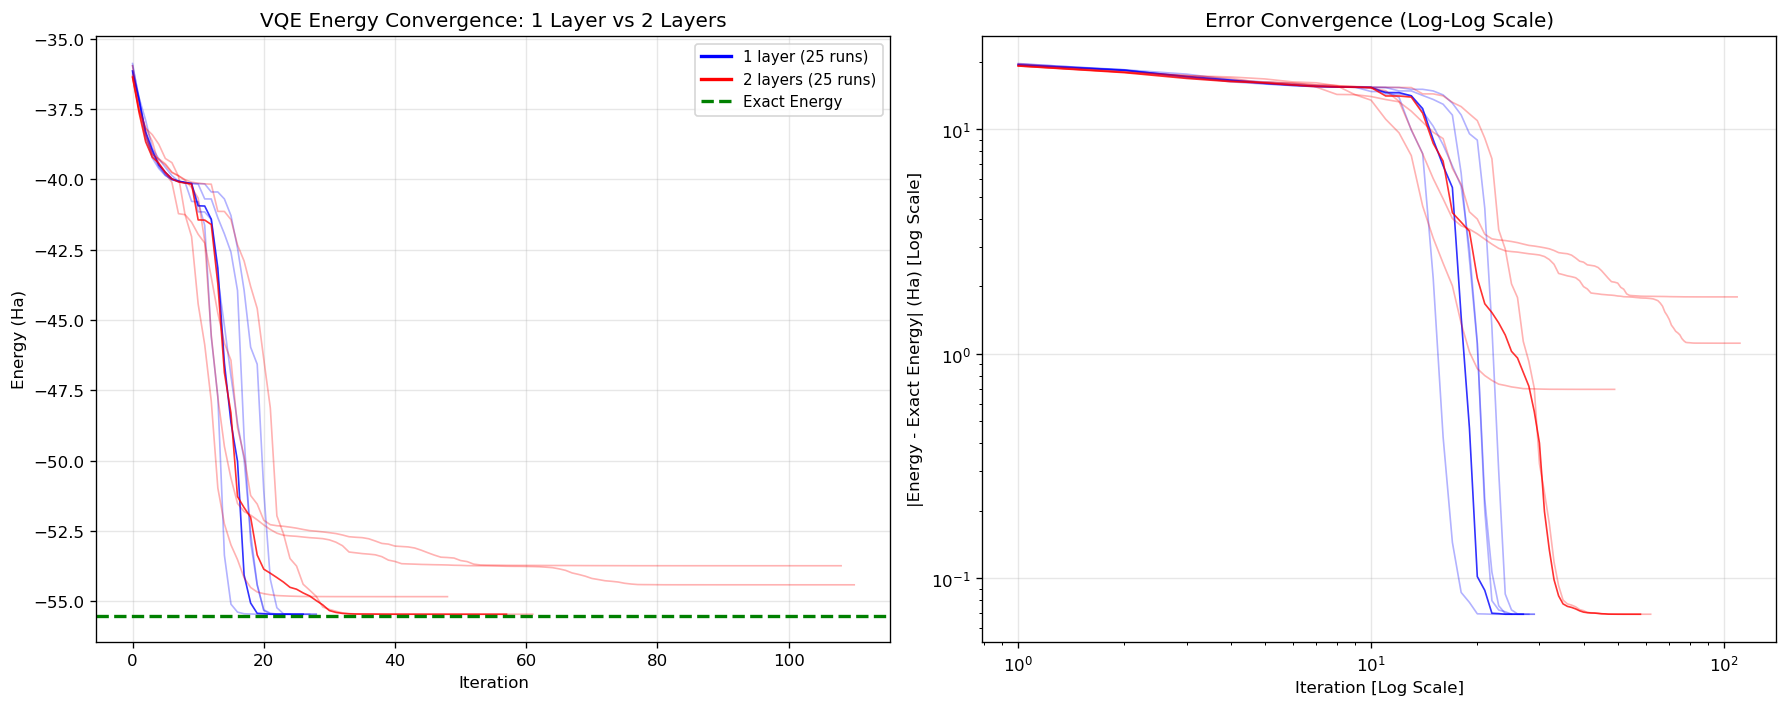

In [56]:
# Create comparison plots for 1 layer vs 2 layers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Convergence trajectories comparison
colors = ['blue', 'red']
layer_colors = {1: 'blue', 2: 'red'}

for n_layers in compare_layers:
    data = layer_data[n_layers]
    color = layer_colors[n_layers]
    
    for i, energies in enumerate(data['convergence'][:5]):  # Show first 5 runs only
        alpha = 0.3 if i > 0 else 0.8  # Make first run more visible
        ax1.plot(range(len(energies)), energies, color=color, alpha=alpha, linewidth=1)
    
    # Add a representative line for legend
    ax1.plot([], [], color=color, linewidth=2, 
             label=f'{n_layers} layer{"s" if n_layers > 1 else ""} ({data["n_runs"]} runs)')

if pl_exact_energy is not None:
    ax1.axhline(y=pl_exact_energy, color='green', linestyle='--', linewidth=2, label='Exact Energy')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Energy (Ha)')
ax1.set_title('VQE Energy Convergence: 1 Layer vs 2 Layers')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Log-log error convergence
for n_layers in compare_layers:
    data = layer_data[n_layers]
    color = layer_colors[n_layers]
    
    for i, energies in enumerate(data['convergence'][:5]):
        if energies and pl_exact_energy is not None:
            energy_diff = [abs(energy - pl_exact_energy) for energy in energies]
            energy_diff = [max(diff, 1e-12) for diff in energy_diff]
            iterations = range(1, len(energy_diff) + 1)
            alpha = 0.3 if i > 0 else 0.8
            ax2.loglog(iterations, energy_diff, color=color, alpha=alpha, linewidth=1)

ax2.set_xlabel('Iteration [Log Scale]')
ax2.set_ylabel('|Energy - Exact Energy| (Ha) [Log Scale]')
ax2.set_title('Error Convergence (Log-Log Scale)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

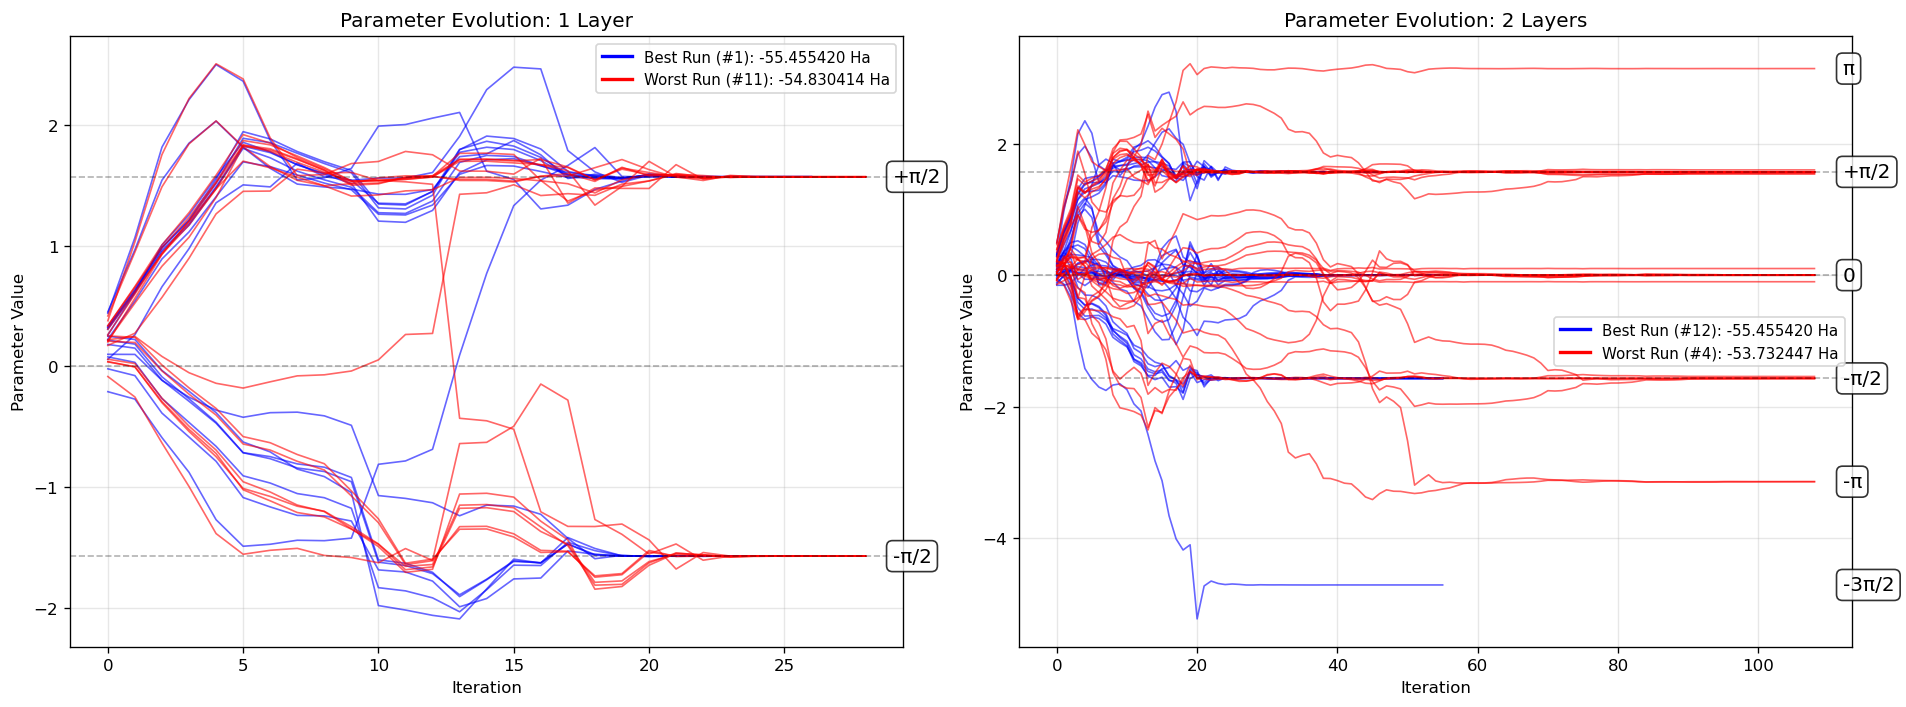

In [57]:
# Compare parameter evolution: best vs worst runs across different layer counts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for layer_idx, n_layers in enumerate(compare_layers):
    ax = axes[layer_idx]
    data = layer_data[n_layers]
    
    # Load parameter trajectories for this layer count
    param_trajectories = []
    for run in range(data['n_runs']):
        ansatz_type = f"custom_{n_layers}layers_run{run}"
        result_file_pattern = f"diff_layers/vqe_progress_{ansatz_type}_*.json"
        result_files = glob.glob(result_file_pattern)
        if result_files:
            result_files.sort()
            with open(result_files[-1], 'r') as f:
                file_data = json.load(f)
            param_trajectories.append(np.array(file_data['parameters']))
        else:
            param_trajectories.append(None)
    
    # Find best and worst runs
    final_energies = data['final_energies']
    min_idx = int(np.argmin(final_energies))
    max_idx = int(np.argmax(final_energies))
    
    # Plot parameter evolution
    if param_trajectories[min_idx] is not None:
        for i in range(param_trajectories[min_idx].shape[1]):
            ax.plot(param_trajectories[min_idx][:, i], color='blue', alpha=0.6, linewidth=1)
        ax.plot([], [], color='blue', linewidth=2, label=f'Best Run (#{min_idx+1}): {final_energies[min_idx]:.6f} Ha')
    
    if param_trajectories[max_idx] is not None and max_idx != min_idx:
        for i in range(param_trajectories[max_idx].shape[1]):
            ax.plot(param_trajectories[max_idx][:, i], color='red', alpha=0.6, linewidth=1)
        ax.plot([], [], color='red', linewidth=2, label=f'Worst Run (#{max_idx+1}): {final_energies[max_idx]:.6f} Ha')
    
    # Add horizontal reference lines (subtle)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(y=np.pi/2, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(y=-np.pi/2, color='black', linestyle='--', alpha=0.3, linewidth=1)
    
    # Add text labels at the right edge
    max_iterations = [29, 112]
    ax.text(max_iterations[layer_idx], np.pi/2, '+π/2', fontsize=12, ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    ax.text(max_iterations[layer_idx], -np.pi/2, '-π/2', fontsize=12, ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    if layer_idx == 1:
        ax.text(max_iterations[layer_idx], 0, '0', fontsize=12, ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        ax.text(max_iterations[layer_idx], np.pi, 'π', fontsize=12, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        ax.text(max_iterations[layer_idx], -np.pi, '-π', fontsize=12, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        ax.text(max_iterations[layer_idx], -3*np.pi/2, '-3π/2', fontsize=12, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Parameter Value')
    ax.set_title(f'Parameter Evolution: {n_layers} Layer{"s" if n_layers > 1 else ""}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

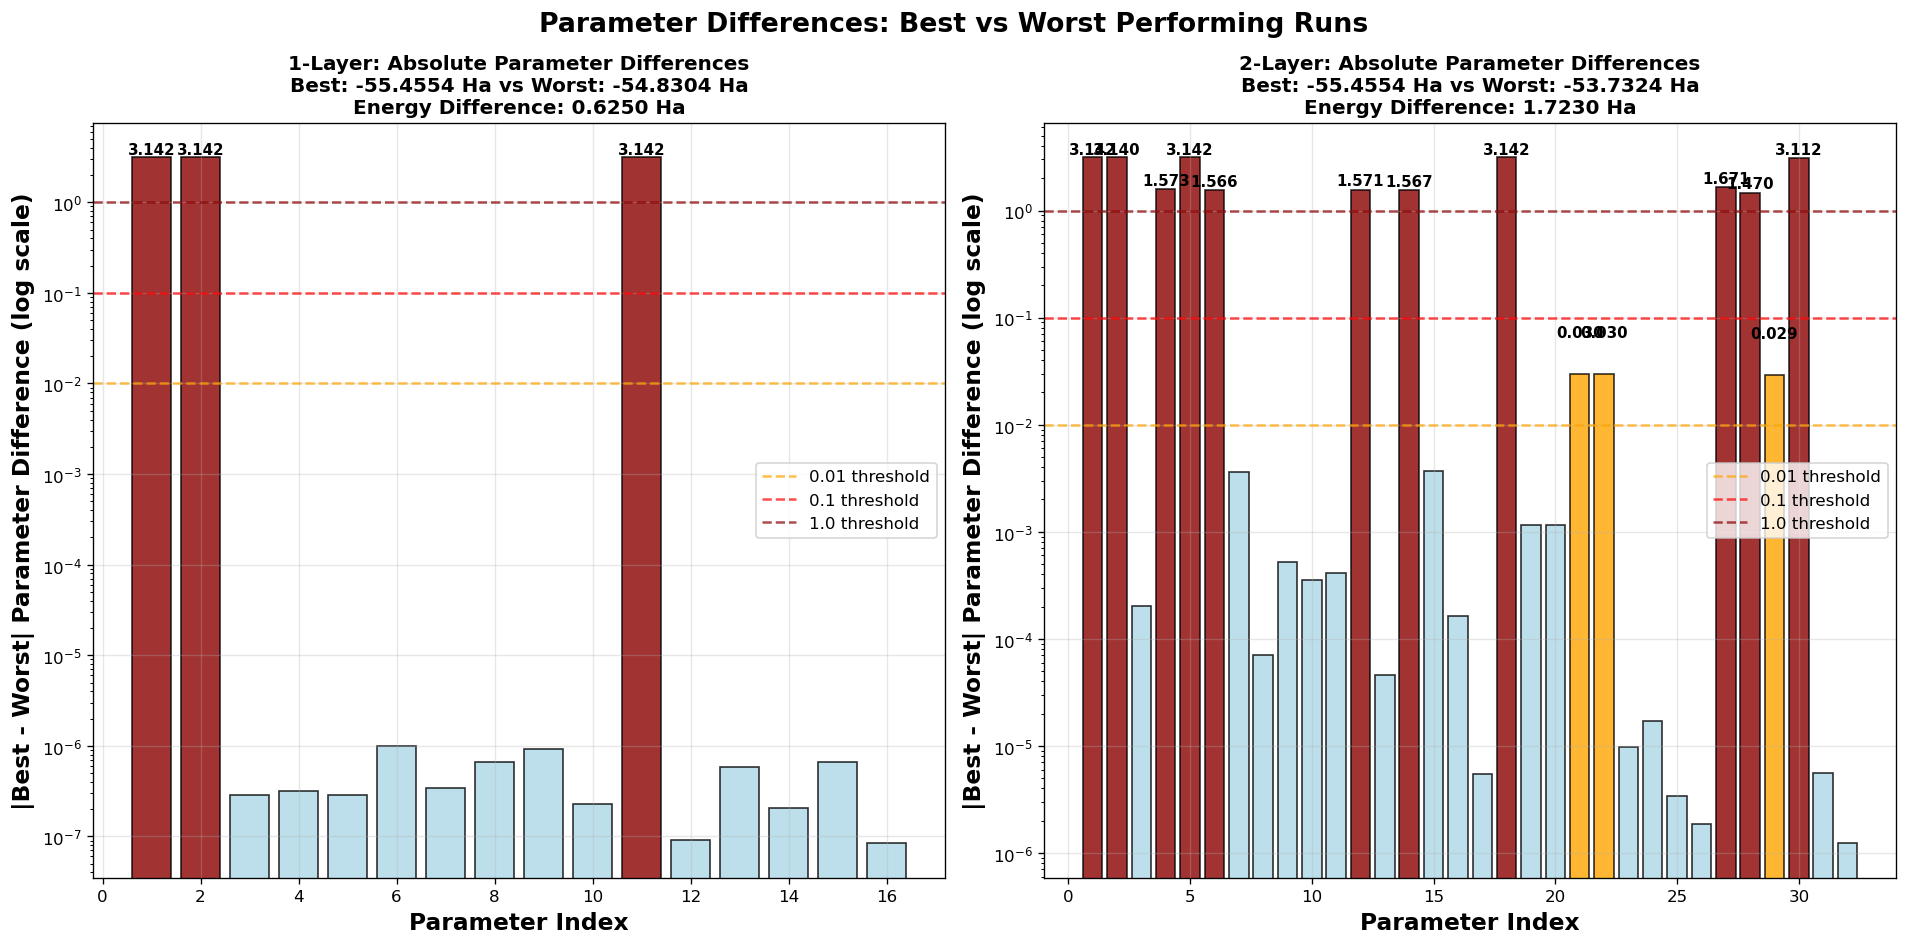

In [58]:
# Create focused difference plots between best and worst parameters
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for layer_idx, n_layers in enumerate(compare_layers):
    ax = axes[layer_idx]
    data = layer_data[n_layers]
    
    # Load final parameter values for all runs
    all_final_params = []
    final_energies = data['final_energies']
    
    for run in range(data['n_runs']):
        ansatz_type = f"custom_{n_layers}layers_run{run}"
        result_file_pattern = f"diff_layers/vqe_progress_{ansatz_type}_*.json"
        result_files = glob.glob(result_file_pattern)
        if result_files:
            result_files.sort()
            with open(result_files[-1], 'r') as f:
                file_data = json.load(f)
            if file_data['parameters']:
                all_final_params.append(np.array(file_data['parameters'][-1]))
            else:
                all_final_params.append(None)
        else:
            all_final_params.append(None)
    
    # Filter out None values
    valid_params = [(i, params) for i, params in enumerate(all_final_params) if params is not None]
    valid_energies = [final_energies[i] for i, _ in valid_params]
    valid_param_arrays = [params for _, params in valid_params]
    
    if not valid_param_arrays:
        continue
        
    # Find best and worst runs
    min_energy_idx = np.argmin(valid_energies)
    max_energy_idx = np.argmax(valid_energies)
    
    best_params = valid_param_arrays[min_energy_idx]
    worst_params = valid_param_arrays[max_energy_idx]
    
    # Calculate absolute differences
    param_diff = np.abs(best_params - worst_params)
    param_indices = np.arange(1, len(param_diff) + 1)
    
    # Create bar plot with color coding based on difference magnitude
    colors = ['darkred' if diff > 1.0 else 'red' if diff > 0.1 else 'orange' if diff > 0.01 else 'lightblue' 
              for diff in param_diff]
    
    bars = ax.bar(param_indices, param_diff, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add horizontal lines for reference
    ax.axhline(y=0.01, color='orange', linestyle='--', alpha=0.7, label='0.01 threshold')
    ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='0.1 threshold')
    ax.axhline(y=1.0, color='darkred', linestyle='--', alpha=0.7, label='1.0 threshold')
    
    # Add value labels on bars for significant differences
    for i, (bar, diff) in enumerate(zip(bars, param_diff)):
        if diff > 0.01:  # Only label significant differences
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max(param_diff)*0.01,
                   f'{diff:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Parameter Index', fontsize=14, fontweight='bold')
    ax.set_ylabel('|Best - Worst| Parameter Difference', fontsize=14, fontweight='bold')
    ax.set_title(f'{n_layers}-Layer: Absolute Parameter Differences\n'
                f'Best: {valid_energies[min_energy_idx]:.4f} Ha vs Worst: {valid_energies[max_energy_idx]:.4f} Ha\n'
                f'Energy Difference: {valid_energies[max_energy_idx] - valid_energies[min_energy_idx]:.4f} Ha', 
                fontsize=12, fontweight='bold')
    
    # Set y-axis to log scale if there's a wide range of differences
    if np.max(param_diff) / np.min(param_diff[param_diff > 0]) > 100:
        ax.set_yscale('log')
        ax.set_ylabel('|Best - Worst| Parameter Difference (log scale)', fontsize=14, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    


plt.suptitle('Parameter Differences: Best vs Worst Performing Runs', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Effect of different initialization types on convergence
---

This part compares five distinct parameter-initialization schemes:`zeros`, `small_normal`, `uniform`, `pm_pi_over2`, and `sobol`.  
We analyze how each scheme influences optimization stability, convergence rate, and final energy accuracy.

**Parameter initialization types**

- **zeros** – All parameters start at 0.  
- **small_normal** – Samples from a normal distribution with small variance for slight randomization.  
- **uniform** – Draws from a uniform distribution (typically in \[-π, π]) for broader coverage.  
- **pm_pi_over2** – Each parameter is randomly set to +π/2 or −π/2, with a small jitter to each parameter following a normal distribution with zero mean and 0.1 variance.  
- **sobol** – Generates parameters using a Sobol low-discrepancy sequence.  
  This is a deterministic, quasi-random method that fills the multi-dimensional space more evenly than pure random sampling, giving good initial coverage for optimization.

In [59]:
n_layers = 1
n_initializations = 50
init_types = ['zeros', 'small_normal', 'uniform', 'pm_pi_over2', 'sobol']
n_params = n_layers * pl_qubits
results_dir = "diff_init_types"
os.makedirs(results_dir, exist_ok=True)

# Storage
final_energies = {t: [] for t in init_types}
convergence    = {t: [] for t in init_types}

# --- Main loop over initialization types ---
for init_type in init_types:
    if init_type == 'zeros':
        n_runs = 1
    else:
        n_runs = n_initializations
    print(f"\n=== Running {n_runs} VQE runs for {init_type} initialization ===")
    for i in range(n_runs):
        ansatz_type = f"{init_type}_{n_layers}layers_run{i+1}"
        pattern = f"{results_dir}/vqe_progress_{ansatz_type}_*.json"
        existing = sorted(glob.glob(pattern))

        if existing:
            # Load last result if it exists
            print(f"Found existing result file: {existing[-1]}")
            with open(existing[-1], 'r') as f:
                data = json.load(f)
            final_energies[init_type].append(data['energies'][-1])
            convergence[init_type].append(data['energies'])
            print(f"Loaded {existing[-1]}   Final energy: {data['energies'][-1]:.8f} Hartree")
            continue

        # --- Generate one parameter vector for this scheme ---
        params_dict = generate_single_initializations(n_params=n_params,
                                                      seed=5052000 + i)
        pl_params_tmp = np.array(params_dict[init_type])

        print(f"Run {i+1}/{n_runs}  (init={init_type})")
        pl_result_tmp = pl_optimize_vqe(
            pl_params_tmp,
            pl_H,
            pl_ansatz_type=ansatz_type,
            method="L-BFGS-B",
            maxiter=500
        )

        final_energies[init_type].append(pl_result_tmp.fun)
        convergence[init_type].append(pl_result_tmp.callback_data['energies'])



=== Running 1 VQE runs for zeros initialization ===
Found existing result file: diff_init_types/vqe_progress_zeros_1layers_run1_1758489627.json
Loaded diff_init_types/vqe_progress_zeros_1layers_run1_1758489627.json   Final energy: -55.45541977 Hartree

=== Running 50 VQE runs for small_normal initialization ===
Found existing result file: diff_init_types/vqe_progress_small_normal_1layers_run1_1758490971.json
Loaded diff_init_types/vqe_progress_small_normal_1layers_run1_1758490971.json   Final energy: -55.45541977 Hartree
Found existing result file: diff_init_types/vqe_progress_small_normal_1layers_run2_1758491164.json
Loaded diff_init_types/vqe_progress_small_normal_1layers_run2_1758491164.json   Final energy: -55.45541977 Hartree
Found existing result file: diff_init_types/vqe_progress_small_normal_1layers_run3_1758491355.json
Loaded diff_init_types/vqe_progress_small_normal_1layers_run3_1758491355.json   Final energy: -55.45541977 Hartree
Found existing result file: diff_init_types/

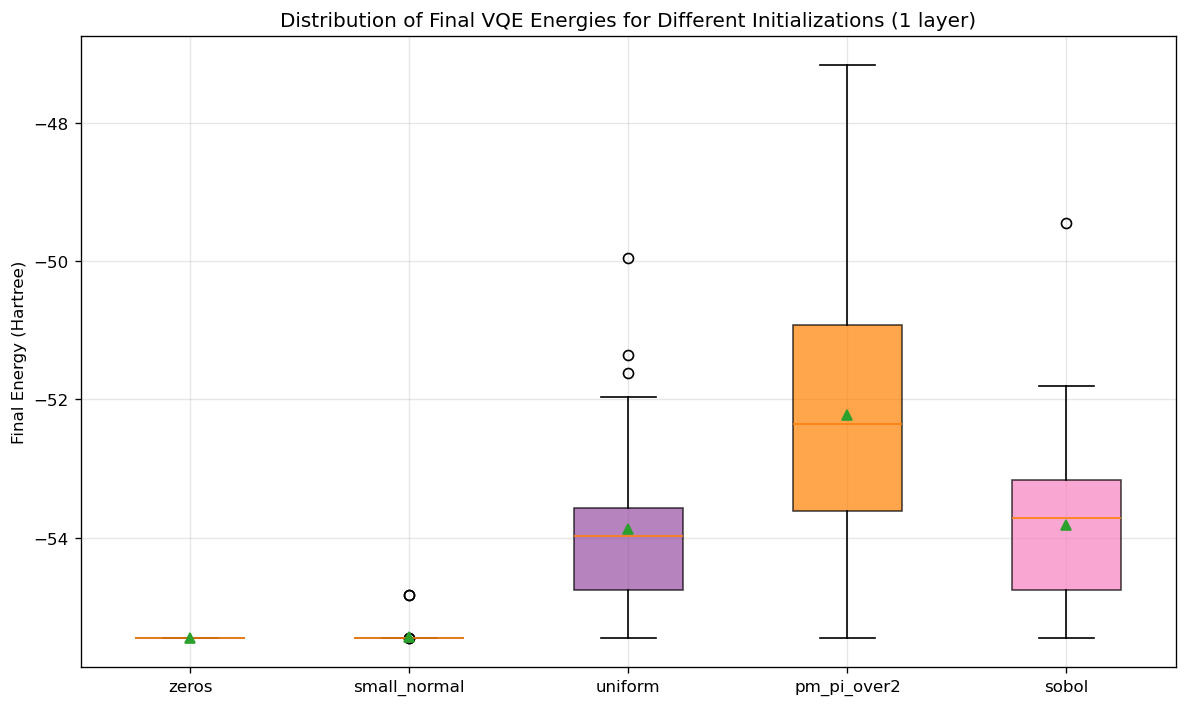

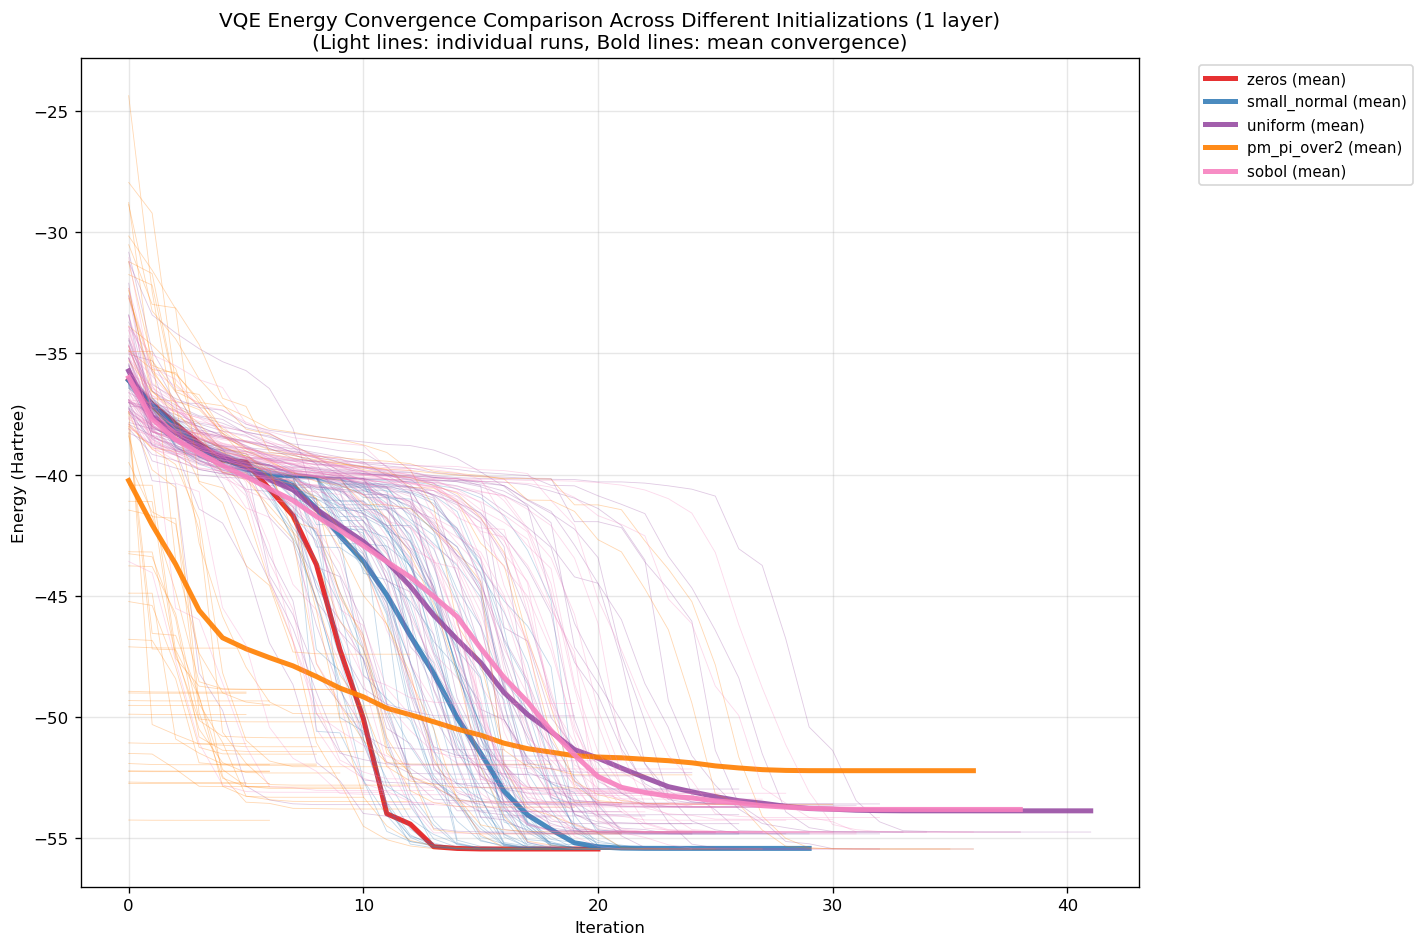

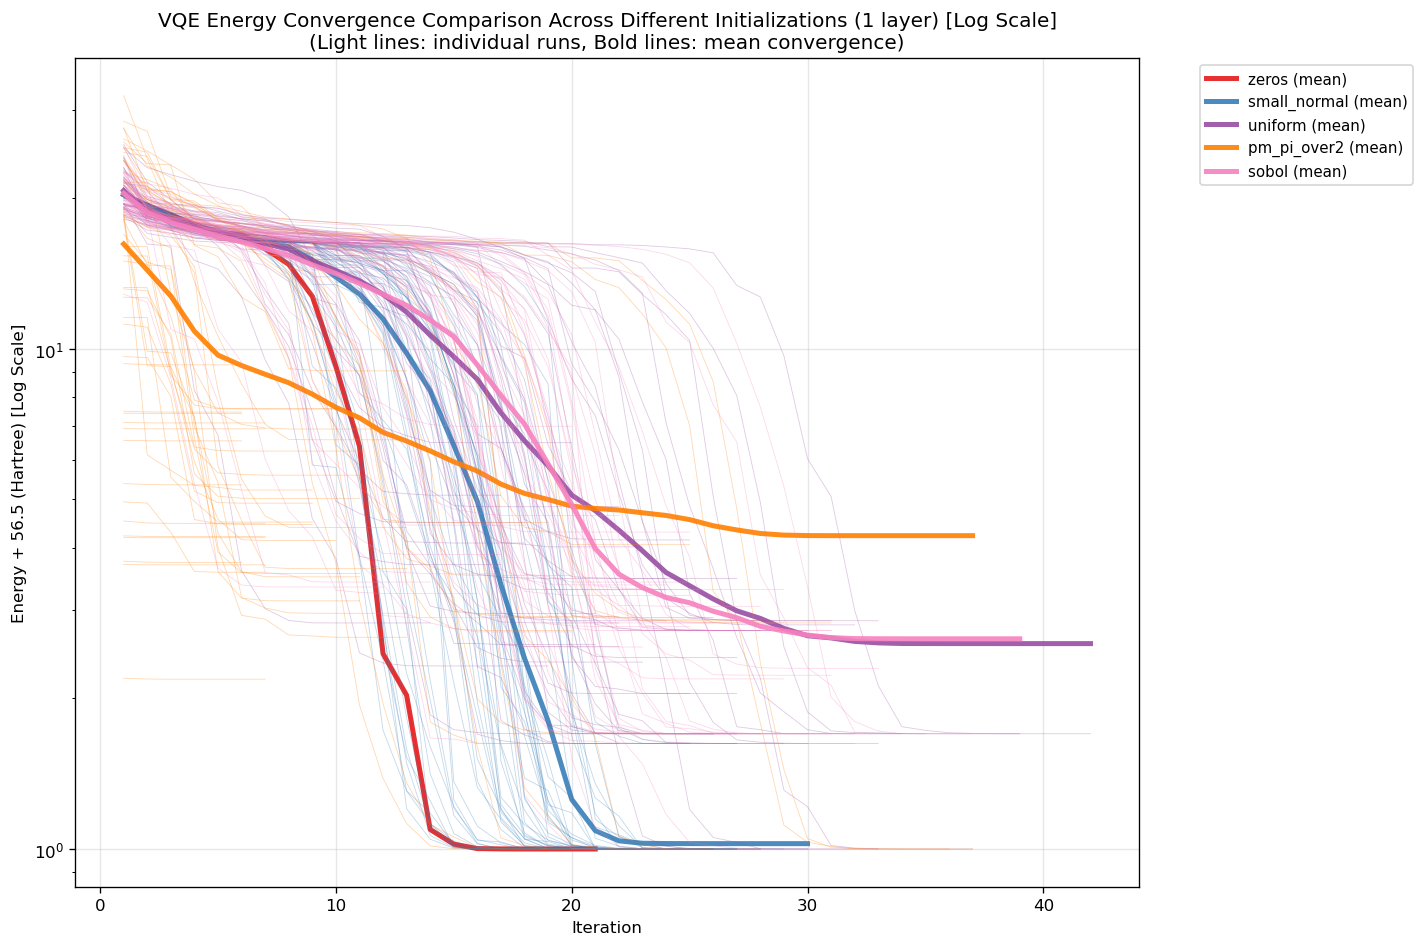

In [60]:
# --- Plot distributions of final energies ---

# Define consistent colors for each initialization type (used across all plots)
init_type_colors = {
    'zeros': plt.cm.Set1(0),
    'small_normal': plt.cm.Set1(0.2), 
    'uniform': plt.cm.Set1(0.4),
    'pm_pi_over2': plt.cm.Set1(0.5),
    'sobol': plt.cm.Set1(0.8)
}

plt.figure(figsize=(10, 6))

# Prepare data for boxplot
boxplot_data = []
labels = []
colors = []
for t in init_types:
    boxplot_data.append(final_energies[t])
    labels.append(t)
    colors.append(init_type_colors[t])

# Create boxplot with proper styling
box_plot = plt.boxplot(boxplot_data, tick_labels=labels, patch_artist=True, showmeans=True)

# Color the boxes with consistent colors
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel("Final Energy (Hartree)")
plt.title(f"Distribution of Final VQE Energies for Different Initializations ({n_layers} layer{'s' if n_layers > 1 else ''})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Convergence lines plot with different colors per initialization type (NORMAL SCALE)
plt.figure(figsize=(12, 8))

# Plot convergence for each initialization type (showing all runs)
for i, t in enumerate(init_types):
    if convergence[t]:
        color = init_type_colors[t]
        
        # Plot all runs for this initialization type with some transparency
        for j, run_convergence in enumerate(convergence[t]):
            if run_convergence:  # Check if convergence data exists
                iterations = range(len(run_convergence))
                plt.plot(iterations, run_convergence, 
                        color=color, alpha=0.3, linewidth=0.5)
        
        # Plot the mean convergence line for this initialization type (thicker line)
        # Calculate mean convergence (pad shorter sequences with their last value)
        max_iterations = max(len(conv) for conv in convergence[t] if conv)
        padded_convergences = []
        
        for conv in convergence[t]:
            if conv:
                # Pad with last value if sequence is shorter
                padded = conv + [conv[-1]] * (max_iterations - len(conv))
                padded_convergences.append(padded)
        
        if padded_convergences:
            mean_convergence = np.mean(padded_convergences, axis=0)
            iterations = range(len(mean_convergence))
            plt.plot(iterations, mean_convergence, 
                    color=color, linewidth=3, 
                    label=f'{t} (mean)', 
                    alpha=0.9)

plt.xlabel('Iteration')
plt.ylabel('Energy (Hartree)')
plt.title(f'VQE Energy Convergence Comparison Across Different Initializations ({n_layers} layer{"s" if n_layers > 1 else ""})\n(Light lines: individual runs, Bold lines: mean convergence)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Optional: Convergence lines plot with different colors per initialization type (LOG SCALE)
plt.figure(figsize=(12, 8))

# Calculate offset to shift all energies to positive values for log scale
all_energies = []
for t in init_types:
    if convergence[t]:
        for run_convergence in convergence[t]:
            if run_convergence:
                all_energies.extend(run_convergence)

min_energy = min(all_energies) if all_energies else -60
offset = abs(min_energy) + 1  # Add 1 to ensure all values are positive

# Plot convergence for each initialization type (showing all runs)
for i, t in enumerate(init_types):
    if convergence[t]:
        color = init_type_colors[t]
        
        # Plot all runs for this initialization type with some transparency
        for j, run_convergence in enumerate(convergence[t]):
            if run_convergence:  # Check if convergence data exists
                iterations = range(1, len(run_convergence) + 1)  # Start from 1 for log scale
                shifted_energies = [energy + offset for energy in run_convergence]
                plt.semilogy(iterations, shifted_energies, 
                        color=color, alpha=0.3, linewidth=0.5)
        
        # Plot the mean convergence line for this initialization type (thicker line)
        # Calculate mean convergence (pad shorter sequences with their last value)
        max_iterations = max(len(conv) for conv in convergence[t] if conv)
        padded_convergences = []
        
        for conv in convergence[t]:
            if conv:
                # Pad with last value if sequence is shorter
                padded = conv + [conv[-1]] * (max_iterations - len(conv))
                padded_convergences.append(padded)
        
        if padded_convergences:
            mean_convergence = np.mean(padded_convergences, axis=0)
            iterations = range(1, len(mean_convergence) + 1)  # Start from 1 for log scale
            shifted_mean = [energy + offset for energy in mean_convergence]
            plt.semilogy(iterations, shifted_mean, 
                    color=color, linewidth=3, 
                    label=f'{t} (mean)', 
                    alpha=0.9)

plt.xlabel('Iteration')
plt.ylabel(f'Energy + {offset:.1f} (Hartree) [Log Scale]')
plt.title(f'VQE Energy Convergence Comparison Across Different Initializations ({n_layers} layer{"s" if n_layers > 1 else ""}) [Log Scale]\n(Light lines: individual runs, Bold lines: mean convergence)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

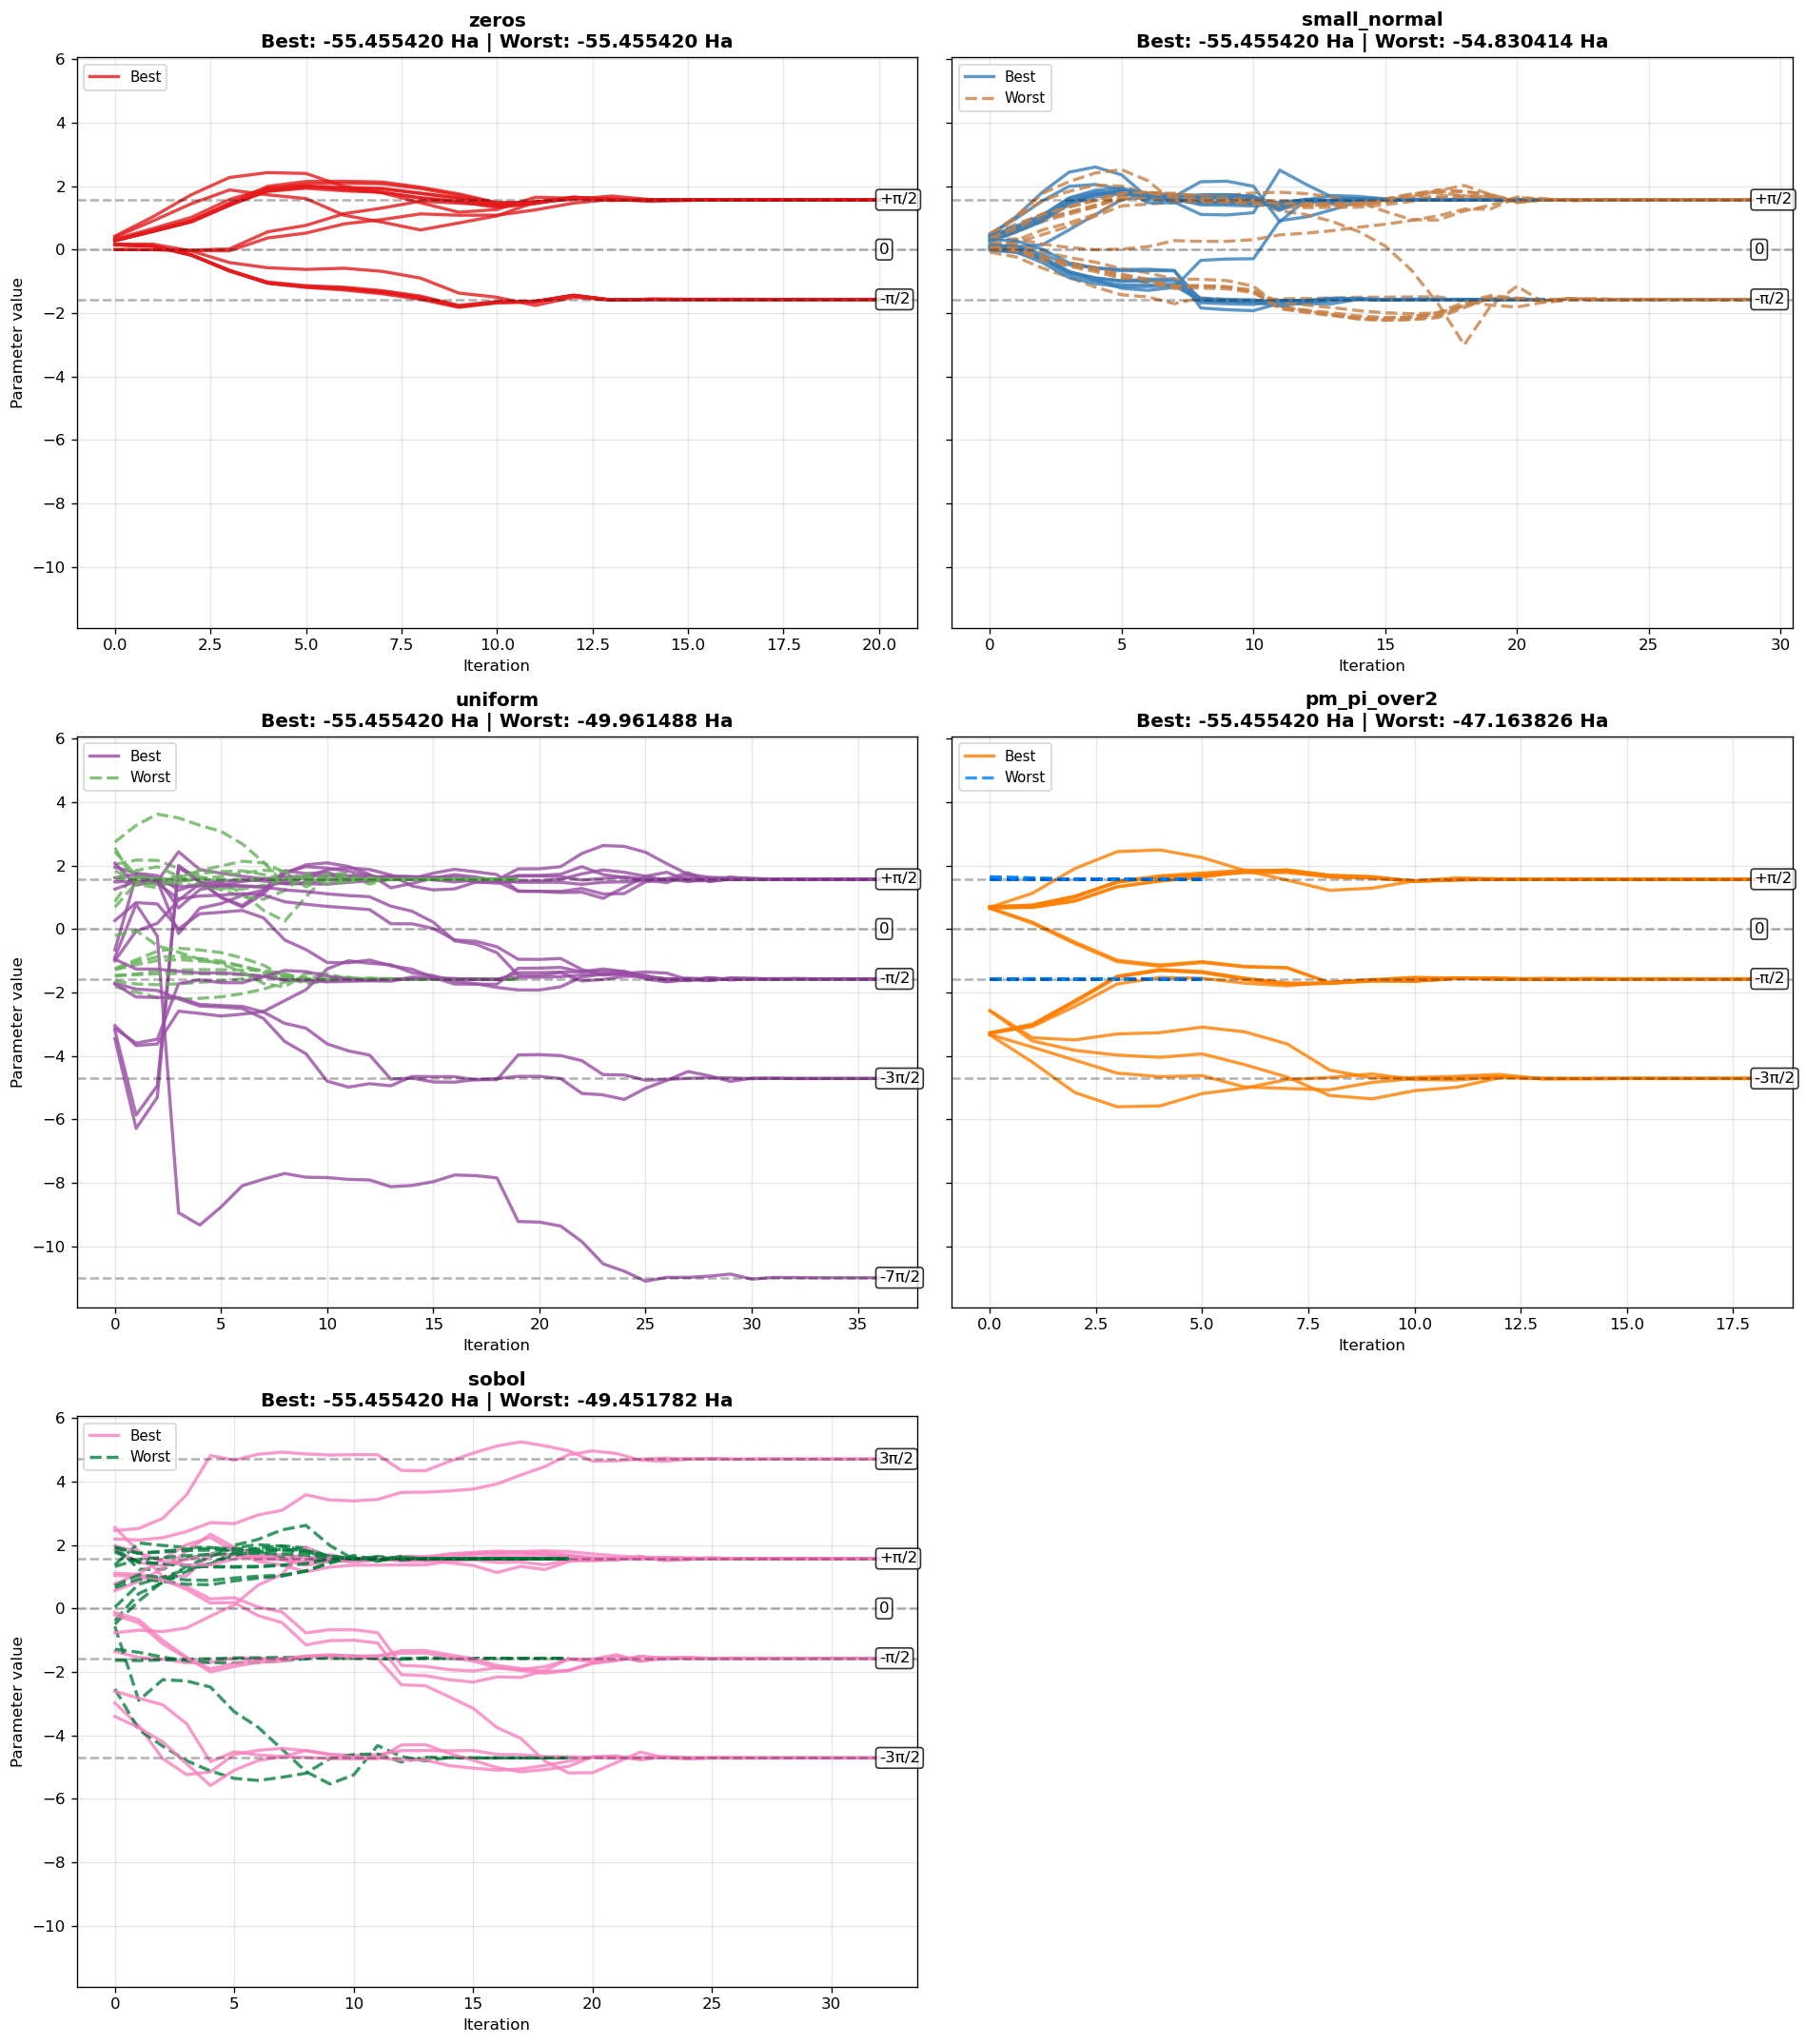

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

for idx, init_type in enumerate(init_types):
    ax = axes[idx]
    
    # Gather all runs for this init type
    run_files = []
    final_energies = []
    param_trajs = []
    
    if init_type == 'zeros':
        run_range = [0]
    else:
        run_range = range(50)   # n_initializations
    
    for i in run_range:
        ansatz_type = f"{init_type}_{n_layers}layers_run{i+1}"
        pattern = f"{results_dir}/vqe_progress_{ansatz_type}_*.json"
        files = sorted(glob.glob(pattern))
        if not files:
            continue
        with open(files[-1], "r") as f:
            d = json.load(f)
        final_energies.append(d["energies"][-1])
        param_trajs.append(np.array(d["parameters"]))
        run_files.append(files[-1])
    
    if not final_energies:
        ax.set_title(f"{init_type}\n(no data)")
        continue
    
    # Pick best and worst runs
    best_idx = int(np.argmin(final_energies))
    worst_idx = int(np.argmax(final_energies))
    best_params = param_trajs[best_idx]
    worst_params = param_trajs[worst_idx]
    best_energy = final_energies[best_idx]
    worst_energy = final_energies[worst_idx]
    
    # Get base color for this initialization type
    base_color = init_type_colors[init_type]
    
    # Create opposite color (complement)
    opposite_color = (1 - base_color[0], 1 - base_color[1], 1 - base_color[2])
    
    # Create color variations for best run
    n_params = best_params.shape[1]
    best_color_variations = []
    worst_color_variations = []
    
    for i in range(n_params):
        # Create variations by blending with white/black
        alpha = 0.3 + 0.7 * i / max(1, n_params - 1)  # From 0.3 to 1.0
        best_color_variations.append(tuple(list(base_color[:3]) + [alpha]))
        worst_color_variations.append(tuple(list(opposite_color[:3]) + [alpha]))
    
    # Plot each parameter trajectory with different shades
    for p in range(n_params):
        # Best run in base color
        ax.plot(best_params[:, p], color=best_color_variations[p], lw=2, alpha=0.8, 
                linestyle='-', label='Best' if p == 0 else "")
        # Worst run in opposite color
        if idx != 0:  
            ax.plot(worst_params[:, p], color=worst_color_variations[p], lw=2, alpha=0.8, 
                    linestyle='--', label='Worst' if p == 0 else "")
    
    # Add horizontal guides
    ax.axhline(0, color='black', ls='--', alpha=0.3)
    ax.axhline(np.pi/2, color='black', ls='--', alpha=0.3)
    ax.axhline(-np.pi/2, color='black', ls='--', alpha=0.3)
    if idx == 2:
        ax.axhline(-3*np.pi/2, color='black', ls='--', alpha=0.3)
        ax.axhline(-7*np.pi/2, color='black', ls='--', alpha=0.3)
    if idx == 3 or idx == 4:
        ax.axhline(-3*np.pi/2, color='black', ls='--', alpha=0.3)
    if idx == 4:
        ax.axhline(3*np.pi/2, color='black', ls='--', alpha=0.3)

    ax.set_title(f"{init_type}\nBest: {best_energy:.6f} Ha | Worst: {worst_energy:.6f} Ha", 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel("Iteration")
    if idx % 2 == 0:  # Left column
        ax.set_ylabel("Parameter value")
    ax.grid(alpha=0.3)
    
    ax.legend(loc='upper left')
    
    # Add text labels at the right edge
    max_iter = max(best_params.shape[0], worst_params.shape[0]) - 1

    # Add reference line labels
    ax.text(max_iter, np.pi/2, '+π/2', fontsize=10, ha='left', va='center',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    ax.text(max_iter, -np.pi/2, '-π/2', fontsize=10, ha='left', va='center',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    ax.text(max_iter, 0, '0', fontsize=10, ha='left', va='center',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

    # Add additional labels for certain initialization types that may have wider parameter ranges
    if idx == 2 or idx == 3 or idx == 4:  # uniform, pm_pi_over2, sobol
        ax.text(max_iter, -3*np.pi/2, '-3π/2', fontsize=10, ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    if idx == 2:
        ax.text(max_iter, -7*np.pi/2, '-7π/2', fontsize=10, ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
    if idx == 4:  # sobol might have even wider ranges
        ax.text(max_iter, 3*np.pi/2, '3π/2', fontsize=10, ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Hide the last subplot if we have an odd number of init types
if len(init_types) % 2 == 1:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()


---
# Noise model
---

### Scope and limitations

- Full noisy simulation for the NH3 system was not executed due to local hardware constraints. On PennyLane, simulating mixed-state dynamics for 12+ qubits with dense chemistry Hamiltonians exceeded available memory on a laptop (practically requiring 64 GB of RAM).  
- Attempts with Qiskit Aer Estimator for comparable noise configurations produced unstable or failed runs in this environment.


---
# Results
---

- Problem setup: NH3 mapped with parity and symmetry tapering (14 → 12 qubits). The electronic Hamiltonian contained 1,682 Pauli terms; truncation to ~k ≈ 339 preserved chemical accuracy (~1.6 mHa) while cutting measurement cost.
- Ansätze: EfficientSU2 (hardware-efficient), UCCSD (chemistry-inspired), and Hamiltonian Variational Ansatz were benchmarked. In noiseless settings, UCCSD typically reached lower energies with fewer evaluations.
- Optimizers: L-BFGS-B converged faster and more stably in the noiseless regime; SPSA is preferable for noisy execution due to robustness and constant evaluation cost per iteration.
- Cross-framework validation: A custom HEA with identical structure and parameters matched between PennyLane and Qiskit. Initial and exact energies agreed to a certain degree..
- Ansatz depth: Increasing layers increased the search space without providing better results, the best ansatz proved to be the smallest.
- Initialization sensitivity: Convergence depended on starting parameters. Small-normal and zeros initializations were the best; 
- Noise study: Full NH3 noisy simulations were deferred due to memory limits locally and unstable Aer runs under the same constraints.
